# **TopoTool: A python-based tool for topographic analysis by instantly accessing Digital Elevation Model (DEM)**

This tool helps you to instantly get **Digital Elevation Model (DEM)** around the world at 30-meter resolution using the Shuttle Radar Topography Mission (SRTM) data. For any chosen location, the tool calculates various topographic parameters such as slope, flow accumation, and Topographic Wetness Index (TWI). By comparing maps of these parameters, we can select potential storm water retention sites and solve drainage problems.

Additionally, the tool maps **building footprint** data to make informed decisions on where to prioritize storm water retention.

Developed by **Joash Omolo**, and **Boneya Hassan Hadinda**

[Hydrology and Hydroinformatics Innovation (H2I) Lab],

Contact: joashomondi254@gmail.com

Please uncomment the following line each time before you run the tool for a new location (e.g., different counties). This action will delete the entire output folder of your previous work.

In [ ]:
#!rm -rf '/content/project'

# **Step 1**: Install modules

In [ ]:
!pip install rasterio wget ipyleaflet rioxarray richdem pyogrio
#!git clone https://github.com/cognoma/figshare.git

!pip install pygeos
!sudo apt-get install swig
!sudo apt-get install libgflags-dev libgoogle-glog-dev libgtest-dev libssl-dev
!sudo apt-get install cmake
!pip install --no-cache-dir s2geometry
!pip install elevation
!sudo apt-get install gdal-bin


  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 329.4/329.4 kB 2.1 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Using cached jedi-0.19.1-py2.py3-none-any.whl.metadata (22 kB)
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.5/21.5 MB 37.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.0/61.0 kB 4.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 23.1/23.1 MB 29.7 MB/s eta 0:00:00
Using cached jedi-0.19.1-py2.py3-none-any.whl (1.6 MB)
  Created wheel for wget: filename=wget-3.2-py3-none-any.whl size=9656 sha256=7dd6ab405f54d7844b290e7f155d62e88d0245dcb3679af414d9b61b9981bb20
  Stored in directory: /root/.cache/pip/wheels/8b/f1/7f/5c94f0a7a505ca1c81cd1d9208ae2064675d97582078e6c769
  Created wheel for richdem: filename=richdem-0.3.4-cp310-cp310-linux_x86_64.whl size=7844527 sha256=9f4af8cb5c22f688d36b70bceef319ae9391c85663f06f706055a3b8049414a4
  Stored in directory: /root/.cache/pip/wheels/01/61/27/5c305116

# **Step 2**: Import modules

In [ ]:
import rasterio, math, os, glob, wget, shutil, fiona, json, folium, rasterio, functools, gzip, multiprocessing, tempfile, elevation, shapely
from rasterio.merge import merge
import geopandas as gpd
import pandas as pd
import rioxarray as rxr
import richdem as rd
import numpy as np
from pyogrio import read_dataframe
import matplotlib.pyplot as plt
from ipyleaflet import Map, basemaps, basemap_to_tiles, DrawControl
from google.colab import files
#from figshare.figshare import Figshare
from zipfile import ZipFile
import branca.colormap as cm
from matplotlib import colors as colors
from mpl_toolkits.axes_grid1 import make_axes_locatable
from typing import List, Optional, Tuple
from rasterio.plot import show
import s2geometry as s2
import tensorflow as tf
import tqdm.notebook
%matplotlib inline

# **Step 3**: Define functions

In [ ]:
def clear_m():
    global rects,polys
    rects = set()
    polys = set()

def handle_draw(self, action, geo_json):
    global rects,polys
    polygon=[]
    for coords in geo_json['geometry']['coordinates'][0][:-1][:]:
        polygon.append(tuple(coords))
    polygon = tuple(polygon)
    if geo_json['properties']['style']['color'] == '#0096FF':  # poly
        if action == 'created':
            polys.add(polygon)
        elif action == 'deleted':
            polys.discard(polygon)
    if geo_json['properties']['style']['color'] == '#0096FF':  # rect
        if action == 'created':
            rects.add(polygon)
        elif action == 'deleted':
            rects.discard(polygon)


def mapvalue2color(value, cmap):
    """
    Map a pixel value of image to a color in the rgba format.
    As a special case, nans will be mapped totally transparent.

    Inputs
        -- value - pixel value of image, could be np.nan
        -- cmap - a linear colormap from branca.colormap.linear
    Output
        -- a color value in the rgba format (r, g, b, a)
    """
    if np.isnan(value):
        return (1, 0, 0, 0)
    else:
        return colors.to_rgba(cmap(value), 1)

In [ ]:
def get_filename_and_region_dataframe(
    your_own_wkt_polygon: str) -> Tuple[str, gpd.geodataframe.GeoDataFrame]:
  """Returns output filename and a geopandas dataframe with one region row."""

  if your_own_wkt_polygon:
    filename = f'open_buildings_v3_{data_type}_your_own_wkt_polygon.csv.gz'
    region_df = gpd.GeoDataFrame(
        geometry=gpd.GeoSeries.from_wkt([your_own_wkt_polygon]),
        crs='EPSG:4326')
    if not isinstance(region_df.iloc[0].geometry,
                      shapely.geometry.polygon.Polygon) and not isinstance(
                          region_df.iloc[0].geometry,
                          shapely.geometry.multipolygon.MultiPolygon):
      raise ValueError("`your_own_wkt_polygon` must be a POLYGON or "
                      "MULTIPOLYGON.")
    print(f'Preparing your_own_wkt_polygon.')
    return filename, region_df


def get_bounding_box_s2_covering_tokens(
    region_geometry: shapely.geometry.base.BaseGeometry) -> List[str]:
  region_bounds = region_geometry.bounds
  s2_lat_lng_rect = s2.S2LatLngRect_FromPointPair(
      s2.S2LatLng_FromDegrees(region_bounds[1], region_bounds[0]),
      s2.S2LatLng_FromDegrees(region_bounds[3], region_bounds[2]))
  coverer = s2.S2RegionCoverer()
  # NOTE: Should be kept in-sync with s2 level in BUILDING_DOWNLOAD_PATH.
  coverer.set_fixed_level(6)
  coverer.set_max_cells(1000000)
  return [cell.ToToken() for cell in coverer.GetCovering(s2_lat_lng_rect)]


def s2_token_to_shapely_polygon(
    s2_token: str) -> shapely.geometry.polygon.Polygon:
  s2_cell = s2.S2Cell(s2.S2CellId_FromToken(s2_token, len(s2_token)))
  coords = []
  for i in range(4):
    s2_lat_lng = s2.S2LatLng(s2_cell.GetVertex(i))
    coords.append((s2_lat_lng.lng().degrees(), s2_lat_lng.lat().degrees()))
  return shapely.geometry.Polygon(coords)


def download_s2_token(
    s2_token: str, region_df: gpd.geodataframe.GeoDataFrame) -> Optional[str]:

  s2_cell_geometry = s2_token_to_shapely_polygon(s2_token)
  region_geometry = region_df.iloc[0].geometry
  prepared_region_geometry = shapely.prepared.prep(region_geometry)
  # If the s2 cell doesn't intersect the country geometry at all then we can
  # know that all rows would be dropped so instead we can just return early.
  if not prepared_region_geometry.intersects(s2_cell_geometry):
    return None
  try:
    # Using tf.io.gfile.GFile gives better performance than passing the GCS path
    # directly to pd.read_csv.
    with tf.io.gfile.GFile(
        os.path.join(BUILDING_DOWNLOAD_PATH, f'{s2_token}_buildings.csv.gz'),
        'rb') as gf:
      # If the s2 cell is fully covered by country geometry then can skip
      # filtering as we need all rows.
      if prepared_region_geometry.covers(s2_cell_geometry):
        with tempfile.NamedTemporaryFile(mode='w+b', delete=False) as tmp_f:
          shutil.copyfileobj(gf, tmp_f)
          return tmp_f.name
      # Else take the slow path.
      # NOTE: We read in chunks to save memory.
      csv_chunks = pd.read_csv(
          gf, chunksize=2000000, dtype=object, compression='gzip', header=None)
      tmp_f = tempfile.NamedTemporaryFile(mode='w+b', delete=False)
      tmp_f.close()
      for csv_chunk in csv_chunks:
        points = gpd.GeoDataFrame(
            geometry=gpd.points_from_xy(csv_chunk[1], csv_chunk[0]),
            crs='EPSG:4326')
        # sjoin 'within' was faster than using shapely's 'within' directly.
        points = gpd.sjoin(points, region_df, predicate='within')
        csv_chunk = csv_chunk.iloc[points.index]
        csv_chunk.to_csv(
            tmp_f.name,
            mode='ab',
            index=False,
            header=False,
            compression={
                'method': 'gzip',
                'compresslevel': 1
            })
      return tmp_f.name
  except tf.errors.NotFoundError:
    return None


In [ ]:
Urldata_lst = [['Florida', 'Hillsborough', 'https://ndownloader.figshare.com/files/26568590'], ['Florida', 'Polk', 'https://ndownloader.figshare.com/files/26568593'], ['Missouri', 'StLouisCounty', 'https://ndownloader.figshare.com/files/26568596'], ['NorthCarolina', 'Wake', 'https://ndownloader.figshare.com/files/26568599'], ['NorthDakota', 'Cass', 'https://ndownloader.figshare.com/files/26568602'], ['Ohio', 'Hamilton', 'https://ndownloader.figshare.com/files/26568605'], ['Texas', 'Bexar', 'https://ndownloader.figshare.com/files/26568608'], ['Texas', 'Dallas', 'https://ndownloader.figshare.com/files/26568611'], ['Texas', 'Harris', 'https://ndownloader.figshare.com/files/26568620'], ['Texas', 'Travis', 'https://ndownloader.figshare.com/files/26654930'], ['Arkansas', 'Yell', 'https://ndownloader.figshare.com/files/30659084'], ['Alabama', 'Autauga', 'https://ndownloader.figshare.com/files/30659087'], ['Alabama', 'Baldwin', 'https://ndownloader.figshare.com/files/30659090'], ['Alabama', 'Barbour', 'https://ndownloader.figshare.com/files/30659093'], ['Alabama', 'Bibb', 'https://ndownloader.figshare.com/files/30659096'], ['Alabama', 'Blount', 'https://ndownloader.figshare.com/files/30659099'], ['Alabama', 'Bullock', 'https://ndownloader.figshare.com/files/30659102'], ['Alabama', 'Butler', 'https://ndownloader.figshare.com/files/30659105'], ['Alabama', 'Calhoun', 'https://ndownloader.figshare.com/files/30659108'], ['Alabama', 'Chambers', 'https://ndownloader.figshare.com/files/30659111'], ['Alabama', 'Cherokee', 'https://ndownloader.figshare.com/files/30659114'], ['Alabama', 'Chilton', 'https://ndownloader.figshare.com/files/30659117'], ['Alabama', 'Choctaw', 'https://ndownloader.figshare.com/files/30659120'], ['Alabama', 'Clarke', 'https://ndownloader.figshare.com/files/30659123'], ['Alabama', 'Clay', 'https://ndownloader.figshare.com/files/30659126'], ['Alabama', 'Cleburne', 'https://ndownloader.figshare.com/files/30659129'], ['Alabama', 'Coffee', 'https://ndownloader.figshare.com/files/30659132'], ['Alabama', 'Colbert', 'https://ndownloader.figshare.com/files/30659135'], ['Alabama', 'Conecuh', 'https://ndownloader.figshare.com/files/30659141'], ['Alabama', 'Coosa', 'https://ndownloader.figshare.com/files/30659138'], ['Alabama', 'Covington', 'https://ndownloader.figshare.com/files/30659144'], ['Alabama', 'Crenshaw', 'https://ndownloader.figshare.com/files/30659147'], ['Alabama', 'Cullman', 'https://ndownloader.figshare.com/files/30659150'], ['Alabama', 'Dale', 'https://ndownloader.figshare.com/files/30659153'], ['Alabama', 'Dallas', 'https://ndownloader.figshare.com/files/30659156'], ['Alabama', 'DeKalb', 'https://ndownloader.figshare.com/files/30659159'], ['Alabama', 'Elmore', 'https://ndownloader.figshare.com/files/30659162'], ['Alabama', 'Escambia', 'https://ndownloader.figshare.com/files/30659165'], ['Alabama', 'Etowah', 'https://ndownloader.figshare.com/files/30659168'], ['Alabama', 'Fayette', 'https://ndownloader.figshare.com/files/30659171'], ['Alabama', 'Franklin', 'https://ndownloader.figshare.com/files/30659174'], ['Alabama', 'Geneva', 'https://ndownloader.figshare.com/files/30659177'], ['Alabama', 'Greene', 'https://ndownloader.figshare.com/files/30659180'], ['Alabama', 'Hale', 'https://ndownloader.figshare.com/files/30659183'], ['Alabama', 'Henry', 'https://ndownloader.figshare.com/files/30659186'], ['Alabama', 'Houston', 'https://ndownloader.figshare.com/files/30659189'], ['Alabama', 'Jackson', 'https://ndownloader.figshare.com/files/30659192'], ['Alabama', 'Jefferson', 'https://ndownloader.figshare.com/files/30659195'], ['Alabama', 'Lamar', 'https://ndownloader.figshare.com/files/30659198'], ['Alabama', 'Lauderdale', 'https://ndownloader.figshare.com/files/30659201'], ['Alabama', 'Lawrence', 'https://ndownloader.figshare.com/files/30659204'], ['Alabama', 'Lee', 'https://ndownloader.figshare.com/files/30659207'], ['Alabama', 'Limestone', 'https://ndownloader.figshare.com/files/30659210'], ['Alabama', 'Lowndes', 'https://ndownloader.figshare.com/files/30659213'], ['Alabama', 'Macon', 'https://ndownloader.figshare.com/files/30659216'], ['Alabama', 'Madison', 'https://ndownloader.figshare.com/files/30659219'], ['Alabama', 'Marengo', 'https://ndownloader.figshare.com/files/30659222'], ['Alabama', 'Marion', 'https://ndownloader.figshare.com/files/30659225'], ['Alabama', 'Marshall', 'https://ndownloader.figshare.com/files/30659228'], ['Alabama', 'Mobile', 'https://ndownloader.figshare.com/files/30659231'], ['Alabama', 'Monroe', 'https://ndownloader.figshare.com/files/30659234'], ['Alabama', 'Montgomery', 'https://ndownloader.figshare.com/files/30659237'], ['Alabama', 'Morgan', 'https://ndownloader.figshare.com/files/30659240'], ['Alabama', 'Perry', 'https://ndownloader.figshare.com/files/30659243'], ['Alabama', 'Pickens', 'https://ndownloader.figshare.com/files/30659246'], ['Alabama', 'Pike', 'https://ndownloader.figshare.com/files/30659249'], ['Alabama', 'Randolph', 'https://ndownloader.figshare.com/files/30659252'], ['Alabama', 'Russell', 'https://ndownloader.figshare.com/files/30659255'], ['Alabama', 'Shelby', 'https://ndownloader.figshare.com/files/30659258'], ['Alabama', 'StClair', 'https://ndownloader.figshare.com/files/30659261'], ['Alabama', 'Sumter', 'https://ndownloader.figshare.com/files/30659264'], ['Alabama', 'Talladega', 'https://ndownloader.figshare.com/files/30659267'], ['Alabama', 'Tallapoosa', 'https://ndownloader.figshare.com/files/30659270'], ['Alabama', 'Tuscaloosa', 'https://ndownloader.figshare.com/files/30659273'], ['Alabama', 'Walker', 'https://ndownloader.figshare.com/files/30659276'], ['Alabama', 'Washington', 'https://ndownloader.figshare.com/files/30659279'], ['Alabama', 'Wilcox', 'https://ndownloader.figshare.com/files/30659282'], ['Alabama', 'Winston', 'https://ndownloader.figshare.com/files/30659285'], ['Arizona', 'Apache', 'https://ndownloader.figshare.com/files/30659288'], ['Arizona', 'Cochise', 'https://ndownloader.figshare.com/files/30659291'], ['Arizona', 'Coconino', 'https://ndownloader.figshare.com/files/30659294'], ['Arizona', 'Gila', 'https://ndownloader.figshare.com/files/30659297'], ['Arizona', 'Graham', 'https://ndownloader.figshare.com/files/30659300'], ['Arizona', 'Greenlee', 'https://ndownloader.figshare.com/files/30659303'], ['Arizona', 'LaPaz', 'https://ndownloader.figshare.com/files/30659306'], ['Arizona', 'Maricopa', 'https://ndownloader.figshare.com/files/30659309'], ['Arizona', 'Mohave', 'https://ndownloader.figshare.com/files/30659312'], ['Arizona', 'Navajo', 'https://ndownloader.figshare.com/files/30659315'], ['Arizona', 'Pima', 'https://ndownloader.figshare.com/files/30659318'], ['Arizona', 'Pinal', 'https://ndownloader.figshare.com/files/30659321'], ['Arizona', 'SantaCruz', 'https://ndownloader.figshare.com/files/30659324'], ['Arizona', 'Yavapai', 'https://ndownloader.figshare.com/files/30659327'], ['Arizona', 'Yuma', 'https://ndownloader.figshare.com/files/30659330'], ['Arkansas', 'Arkansas', 'https://ndownloader.figshare.com/files/30659333'], ['Arkansas', 'Ashley', 'https://ndownloader.figshare.com/files/30659336'], ['Arkansas', 'Baxter', 'https://ndownloader.figshare.com/files/30659339'], ['Arkansas', 'Benton', 'https://ndownloader.figshare.com/files/30659342'], ['Arkansas', 'Boone', 'https://ndownloader.figshare.com/files/30659345'], ['Arkansas', 'Bradley', 'https://ndownloader.figshare.com/files/30659348'], ['Arkansas', 'Calhoun', 'https://ndownloader.figshare.com/files/30659351'], ['Arkansas', 'Carroll', 'https://ndownloader.figshare.com/files/30659354'], ['Arkansas', 'Chicot', 'https://ndownloader.figshare.com/files/30659357'], ['Arkansas', 'Clark', 'https://ndownloader.figshare.com/files/30659360'], ['Arkansas', 'Clay', 'https://ndownloader.figshare.com/files/30659363'], ['Arkansas', 'Cleburne', 'https://ndownloader.figshare.com/files/30659366'], ['Arkansas', 'Cleveland', 'https://ndownloader.figshare.com/files/30659369'], ['Arkansas', 'Columbia', 'https://ndownloader.figshare.com/files/30659372'], ['Arkansas', 'Conway', 'https://ndownloader.figshare.com/files/30659375'], ['Arkansas', 'Craighead', 'https://ndownloader.figshare.com/files/30659378'], ['Arkansas', 'Crawford', 'https://ndownloader.figshare.com/files/30659381'], ['Arkansas', 'Crittenden', 'https://ndownloader.figshare.com/files/30659384'], ['Arkansas', 'Cross', 'https://ndownloader.figshare.com/files/30659387'], ['Arkansas', 'Dallas', 'https://ndownloader.figshare.com/files/30659390'], ['Arkansas', 'Desha', 'https://ndownloader.figshare.com/files/30659393'], ['Arkansas', 'Drew', 'https://ndownloader.figshare.com/files/30659396'], ['Arkansas', 'Faulkner', 'https://ndownloader.figshare.com/files/30659399'], ['Arkansas', 'Franklin', 'https://ndownloader.figshare.com/files/30659402'], ['Arkansas', 'Fulton', 'https://ndownloader.figshare.com/files/30659405'], ['Arkansas', 'Garland', 'https://ndownloader.figshare.com/files/30659408'], ['Arkansas', 'Grant', 'https://ndownloader.figshare.com/files/30659411'], ['Arkansas', 'Greene', 'https://ndownloader.figshare.com/files/30659414'], ['Arkansas', 'Hempstead', 'https://ndownloader.figshare.com/files/30659417'], ['Arkansas', 'HotSpring', 'https://ndownloader.figshare.com/files/30659420'], ['Arkansas', 'Howard', 'https://ndownloader.figshare.com/files/30659423'], ['Arkansas', 'Independence', 'https://ndownloader.figshare.com/files/30659426'], ['Arkansas', 'Izard', 'https://ndownloader.figshare.com/files/30659429'], ['Arkansas', 'Jackson', 'https://ndownloader.figshare.com/files/30659432'], ['Arkansas', 'Jefferson', 'https://ndownloader.figshare.com/files/30659435'], ['Arkansas', 'Johnson', 'https://ndownloader.figshare.com/files/30659438'], ['Arkansas', 'Lafayette', 'https://ndownloader.figshare.com/files/30659441'], ['Arkansas', 'Lawrence', 'https://ndownloader.figshare.com/files/30659444'], ['Arkansas', 'Lee', 'https://ndownloader.figshare.com/files/30659447'], ['Arkansas', 'Lincoln', 'https://ndownloader.figshare.com/files/30659450'], ['Arkansas', 'LittleRiver', 'https://ndownloader.figshare.com/files/30659453'], ['Arkansas', 'Logan', 'https://ndownloader.figshare.com/files/30659456'], ['Arkansas', 'Lonoke', 'https://ndownloader.figshare.com/files/30659459'], ['Arkansas', 'Madison', 'https://ndownloader.figshare.com/files/30659462'], ['Arkansas', 'Marion', 'https://ndownloader.figshare.com/files/30659465'], ['Arkansas', 'Miller', 'https://ndownloader.figshare.com/files/30659468'], ['Arkansas', 'Mississippi', 'https://ndownloader.figshare.com/files/30659471'], ['Arkansas', 'Monroe', 'https://ndownloader.figshare.com/files/30659474'], ['Arkansas', 'Montgomery', 'https://ndownloader.figshare.com/files/30659477'], ['Arkansas', 'Nevada', 'https://ndownloader.figshare.com/files/30659480'], ['Arkansas', 'Newton', 'https://ndownloader.figshare.com/files/30659483'], ['Arkansas', 'Ouachita', 'https://ndownloader.figshare.com/files/30659486'], ['Arkansas', 'Perry', 'https://ndownloader.figshare.com/files/30659489'], ['Arkansas', 'Phillips', 'https://ndownloader.figshare.com/files/30659492'], ['Arkansas', 'Pike', 'https://ndownloader.figshare.com/files/30659495'], ['Arkansas', 'Poinsett', 'https://ndownloader.figshare.com/files/30659498'], ['Arkansas', 'Polk', 'https://ndownloader.figshare.com/files/30659501'], ['Arkansas', 'Pope', 'https://ndownloader.figshare.com/files/30659504'], ['Arkansas', 'Prairie', 'https://ndownloader.figshare.com/files/30659507'], ['Arkansas', 'Pulaski', 'https://ndownloader.figshare.com/files/30659510'], ['Arkansas', 'Randolph', 'https://ndownloader.figshare.com/files/30659513'], ['Arkansas', 'Saline', 'https://ndownloader.figshare.com/files/30659516'], ['Arkansas', 'Scott', 'https://ndownloader.figshare.com/files/30659519'], ['Arkansas', 'Searcy', 'https://ndownloader.figshare.com/files/30659522'], ['Arkansas', 'Sebastian', 'https://ndownloader.figshare.com/files/30659525'], ['Arkansas', 'Sevier', 'https://ndownloader.figshare.com/files/30659528'], ['Arkansas', 'Sharp', 'https://ndownloader.figshare.com/files/30659531'], ['Arkansas', 'StFrancis', 'https://ndownloader.figshare.com/files/30659534'], ['Arkansas', 'Stone', 'https://ndownloader.figshare.com/files/30659537'], ['Arkansas', 'Union', 'https://ndownloader.figshare.com/files/30659540'], ['Arkansas', 'VanBuren', 'https://ndownloader.figshare.com/files/30659543'], ['Arkansas', 'Washington', 'https://ndownloader.figshare.com/files/30659546'], ['Arkansas', 'White', 'https://ndownloader.figshare.com/files/30659549'], ['Arkansas', 'Woodruff', 'https://ndownloader.figshare.com/files/30659552'], ['Texas', 'Gaines', 'https://ndownloader.figshare.com/files/30659573'], ['California', 'Alameda', 'https://ndownloader.figshare.com/files/30659576'], ['California', 'Alpine', 'https://ndownloader.figshare.com/files/30659579'], ['California', 'Amador', 'https://ndownloader.figshare.com/files/30659582'], ['California', 'Butte', 'https://ndownloader.figshare.com/files/30659585'], ['California', 'Calaveras', 'https://ndownloader.figshare.com/files/30659588'], ['California', 'Colusa', 'https://ndownloader.figshare.com/files/30659591'], ['California', 'ContraCosta', 'https://ndownloader.figshare.com/files/30659594'], ['California', 'DelNorte', 'https://ndownloader.figshare.com/files/30659597'], ['California', 'ElDorado', 'https://ndownloader.figshare.com/files/30659600'], ['California', 'Fresno', 'https://ndownloader.figshare.com/files/30659603'], ['California', 'Glenn', 'https://ndownloader.figshare.com/files/30659606'], ['California', 'Humboldt', 'https://ndownloader.figshare.com/files/30659612'], ['California', 'Imperial', 'https://ndownloader.figshare.com/files/30659609'], ['California', 'Inyo', 'https://ndownloader.figshare.com/files/30659615'], ['California', 'Kern', 'https://ndownloader.figshare.com/files/30659618'], ['California', 'Kings', 'https://ndownloader.figshare.com/files/30659621'], ['California', 'Lake', 'https://ndownloader.figshare.com/files/30659624'], ['California', 'Lassen', 'https://ndownloader.figshare.com/files/30659627'], ['California', 'LosAngeles', 'https://ndownloader.figshare.com/files/30659633'], ['California', 'Madera', 'https://ndownloader.figshare.com/files/30659636'], ['California', 'Marin', 'https://ndownloader.figshare.com/files/30659639'], ['California', 'Mariposa', 'https://ndownloader.figshare.com/files/30659642'], ['California', 'Mendocino', 'https://ndownloader.figshare.com/files/30659645'], ['California', 'Merced', 'https://ndownloader.figshare.com/files/30659648'], ['California', 'Modoc', 'https://ndownloader.figshare.com/files/30659651'], ['California', 'Mono', 'https://ndownloader.figshare.com/files/30659654'], ['California', 'Monterey', 'https://ndownloader.figshare.com/files/30659657'], ['California', 'Napa', 'https://ndownloader.figshare.com/files/30659660'], ['California', 'Nevada', 'https://ndownloader.figshare.com/files/30659663'], ['California', 'Orange', 'https://ndownloader.figshare.com/files/30659666'], ['California', 'Placer', 'https://ndownloader.figshare.com/files/30659669'], ['California', 'Plumas', 'https://ndownloader.figshare.com/files/30659672'], ['California', 'Riverside', 'https://ndownloader.figshare.com/files/30659675'], ['California', 'Sacramento', 'https://ndownloader.figshare.com/files/30659678'], ['California', 'SanBenito', 'https://ndownloader.figshare.com/files/30659681'], ['California', 'SanBernardino', 'https://ndownloader.figshare.com/files/30659684'], ['California', 'SanDiego', 'https://ndownloader.figshare.com/files/30659687'], ['California', 'SanFrancisco', 'https://ndownloader.figshare.com/files/30659690'], ['California', 'SanJoaquin', 'https://ndownloader.figshare.com/files/30659693'], ['California', 'SanLuisObispo', 'https://ndownloader.figshare.com/files/30659696'], ['California', 'SanMateo', 'https://ndownloader.figshare.com/files/30659699'], ['California', 'SantaBarbara', 'https://ndownloader.figshare.com/files/30659702'], ['California', 'SantaClara', 'https://ndownloader.figshare.com/files/30659705'], ['California', 'SantaCruz', 'https://ndownloader.figshare.com/files/30659708'], ['California', 'Shasta', 'https://ndownloader.figshare.com/files/30659711'], ['California', 'Sierra', 'https://ndownloader.figshare.com/files/30659714'], ['California', 'Siskiyou', 'https://ndownloader.figshare.com/files/30659717'], ['California', 'Solano', 'https://ndownloader.figshare.com/files/30659720'], ['California', 'Sonoma', 'https://ndownloader.figshare.com/files/30659723'], ['California', 'Stanislaus', 'https://ndownloader.figshare.com/files/30659726'], ['California', 'Sutter', 'https://ndownloader.figshare.com/files/30659729'], ['California', 'Tehama', 'https://ndownloader.figshare.com/files/30659732'], ['California', 'Trinity', 'https://ndownloader.figshare.com/files/30659735'], ['California', 'Tulare', 'https://ndownloader.figshare.com/files/30659738'], ['California', 'Tuolumne', 'https://ndownloader.figshare.com/files/30659741'], ['California', 'Ventura', 'https://ndownloader.figshare.com/files/30659744'], ['California', 'Yolo', 'https://ndownloader.figshare.com/files/30659747'], ['California', 'Yuba', 'https://ndownloader.figshare.com/files/30659750'], ['Colorado', 'Adams', 'https://ndownloader.figshare.com/files/30659753'], ['Colorado', 'Alamosa', 'https://ndownloader.figshare.com/files/30659756'], ['Colorado', 'Arapahoe', 'https://ndownloader.figshare.com/files/30659759'], ['Colorado', 'Archuleta', 'https://ndownloader.figshare.com/files/30659762'], ['Colorado', 'Baca', 'https://ndownloader.figshare.com/files/30659765'], ['Colorado', 'Bent', 'https://ndownloader.figshare.com/files/30659768'], ['Colorado', 'Boulder', 'https://ndownloader.figshare.com/files/30659771'], ['Colorado', 'Broomfield', 'https://ndownloader.figshare.com/files/30659774'], ['Colorado', 'Chaffee', 'https://ndownloader.figshare.com/files/30659777'], ['Colorado', 'Cheyenne', 'https://ndownloader.figshare.com/files/30659780'], ['Colorado', 'ClearCreek', 'https://ndownloader.figshare.com/files/30659789'], ['Colorado', 'Conejos', 'https://ndownloader.figshare.com/files/30659783'], ['Colorado', 'Costilla', 'https://ndownloader.figshare.com/files/30659786'], ['Colorado', 'Crowley', 'https://ndownloader.figshare.com/files/30659792'], ['Colorado', 'Custer', 'https://ndownloader.figshare.com/files/30659795'], ['Colorado', 'Delta', 'https://ndownloader.figshare.com/files/30659798'], ['Colorado', 'Denver', 'https://ndownloader.figshare.com/files/30659801'], ['Colorado', 'Dolores', 'https://ndownloader.figshare.com/files/30659804'], ['Colorado', 'Douglas', 'https://ndownloader.figshare.com/files/30659807'], ['Colorado', 'Eagle', 'https://ndownloader.figshare.com/files/30659810'], ['Colorado', 'Elbert', 'https://ndownloader.figshare.com/files/30659813'], ['Colorado', 'ElPaso', 'https://ndownloader.figshare.com/files/30659816'], ['Colorado', 'Fremont', 'https://ndownloader.figshare.com/files/30659819'], ['Colorado', 'Garfield', 'https://ndownloader.figshare.com/files/30659822'], ['Colorado', 'Gilpin', 'https://ndownloader.figshare.com/files/30659825'], ['Colorado', 'Grand', 'https://ndownloader.figshare.com/files/30659828'], ['Colorado', 'Gunnison', 'https://ndownloader.figshare.com/files/30659831'], ['Colorado', 'Hinsdale', 'https://ndownloader.figshare.com/files/30659834'], ['Colorado', 'Huerfano', 'https://ndownloader.figshare.com/files/30659837'], ['Colorado', 'Jackson', 'https://ndownloader.figshare.com/files/30659840'], ['Colorado', 'Jefferson', 'https://ndownloader.figshare.com/files/30659843'], ['Colorado', 'Kiowa', 'https://ndownloader.figshare.com/files/30659846'], ['Colorado', 'KitCarson', 'https://ndownloader.figshare.com/files/30659849'], ['Colorado', 'Lake', 'https://ndownloader.figshare.com/files/30659852'], ['Colorado', 'LaPlata', 'https://ndownloader.figshare.com/files/30659855'], ['Colorado', 'Larimer', 'https://ndownloader.figshare.com/files/30659858'], ['Colorado', 'LasAnimas', 'https://ndownloader.figshare.com/files/30659861'], ['Colorado', 'Lincoln', 'https://ndownloader.figshare.com/files/30659864'], ['Colorado', 'Logan', 'https://ndownloader.figshare.com/files/30659867'], ['Colorado', 'Mesa', 'https://ndownloader.figshare.com/files/30659870'], ['Colorado', 'Mineral', 'https://ndownloader.figshare.com/files/30659873'], ['Colorado', 'Moffat', 'https://ndownloader.figshare.com/files/30659876'], ['Colorado', 'Montezuma', 'https://ndownloader.figshare.com/files/30659879'], ['Colorado', 'Montrose', 'https://ndownloader.figshare.com/files/30659882'], ['Colorado', 'Morgan', 'https://ndownloader.figshare.com/files/30659885'], ['Colorado', 'Otero', 'https://ndownloader.figshare.com/files/30659888'], ['Colorado', 'Ouray', 'https://ndownloader.figshare.com/files/30659891'], ['Colorado', 'Park', 'https://ndownloader.figshare.com/files/30659894'], ['Colorado', 'Phillips', 'https://ndownloader.figshare.com/files/30659903'], ['Colorado', 'Pitkin', 'https://ndownloader.figshare.com/files/30659897'], ['Colorado', 'Prowers', 'https://ndownloader.figshare.com/files/30659900'], ['Colorado', 'Pueblo', 'https://ndownloader.figshare.com/files/30659909'], ['Colorado', 'RioBlanco', 'https://ndownloader.figshare.com/files/30659906'], ['Colorado', 'RioGrande', 'https://ndownloader.figshare.com/files/30659912'], ['Colorado', 'Routt', 'https://ndownloader.figshare.com/files/30659915'], ['Colorado', 'Saguache', 'https://ndownloader.figshare.com/files/30659918'], ['Colorado', 'SanJuan', 'https://ndownloader.figshare.com/files/30659921'], ['Colorado', 'SanMiguel', 'https://ndownloader.figshare.com/files/30659924'], ['Colorado', 'Sedgwick', 'https://ndownloader.figshare.com/files/30659927'], ['Colorado', 'Summit', 'https://ndownloader.figshare.com/files/30659930'], ['Colorado', 'Teller', 'https://ndownloader.figshare.com/files/30659933'], ['Colorado', 'Washington', 'https://ndownloader.figshare.com/files/30659936'], ['Colorado', 'Weld', 'https://ndownloader.figshare.com/files/30659939'], ['Colorado', 'Yuma', 'https://ndownloader.figshare.com/files/30659942'], ['Connecticut', 'Fairfield', 'https://ndownloader.figshare.com/files/30659945'], ['Connecticut', 'Hartford', 'https://ndownloader.figshare.com/files/30659948'], ['Connecticut', 'Litchfield', 'https://ndownloader.figshare.com/files/30659951'], ['Connecticut', 'Middlesex', 'https://ndownloader.figshare.com/files/30659954'], ['Connecticut', 'NewHaven', 'https://ndownloader.figshare.com/files/30659957'], ['Connecticut', 'NewLondon', 'https://ndownloader.figshare.com/files/30659960'], ['Connecticut', 'Tolland', 'https://ndownloader.figshare.com/files/30659963'], ['Connecticut', 'Windham', 'https://ndownloader.figshare.com/files/30659966'], ['Delaware', 'Kent', 'https://ndownloader.figshare.com/files/30659969'], ['Delaware', 'NewCastle', 'https://ndownloader.figshare.com/files/30659972'], ['Delaware', 'Sussex', 'https://ndownloader.figshare.com/files/30659975'], ['DistrictofColumbia', 'DistrictofColumbia', 'https://ndownloader.figshare.com/files/30659978'], ['Florida', 'Alachua', 'https://ndownloader.figshare.com/files/30659981'], ['Florida', 'Baker', 'https://ndownloader.figshare.com/files/30659984'], ['Florida', 'Bay', 'https://ndownloader.figshare.com/files/30659987'], ['Florida', 'Bradford', 'https://ndownloader.figshare.com/files/30659990'], ['Florida', 'Brevard', 'https://ndownloader.figshare.com/files/30659993'], ['Florida', 'Broward', 'https://ndownloader.figshare.com/files/30659996'], ['Florida', 'Calhoun', 'https://ndownloader.figshare.com/files/30659999'], ['Florida', 'Charlotte', 'https://ndownloader.figshare.com/files/30660002'], ['Florida', 'Citrus', 'https://ndownloader.figshare.com/files/30660005'], ['Florida', 'Clay', 'https://ndownloader.figshare.com/files/30660008'], ['Florida', 'Collier', 'https://ndownloader.figshare.com/files/30660011'], ['Florida', 'Columbia', 'https://ndownloader.figshare.com/files/30660014'], ['Florida', 'DeSoto', 'https://ndownloader.figshare.com/files/30660017'], ['Florida', 'Dixie', 'https://ndownloader.figshare.com/files/30660020'], ['Florida', 'Duval', 'https://ndownloader.figshare.com/files/30660023'], ['Florida', 'Escambia', 'https://ndownloader.figshare.com/files/30660026'], ['Florida', 'Flagler', 'https://ndownloader.figshare.com/files/30660029'], ['Florida', 'Franklin', 'https://ndownloader.figshare.com/files/30660032'], ['Florida', 'Gadsden', 'https://ndownloader.figshare.com/files/30660035'], ['Florida', 'Gilchrist', 'https://ndownloader.figshare.com/files/30660038'], ['Florida', 'Glades', 'https://ndownloader.figshare.com/files/30660041'], ['Florida', 'Gulf', 'https://ndownloader.figshare.com/files/30660050'], ['Florida', 'Hamilton', 'https://ndownloader.figshare.com/files/30660044'], ['Florida', 'Hardee', 'https://ndownloader.figshare.com/files/30660047'], ['Florida', 'Hendry', 'https://ndownloader.figshare.com/files/30660053'], ['Florida', 'Hernando', 'https://ndownloader.figshare.com/files/30660056'], ['Florida', 'Highlands', 'https://ndownloader.figshare.com/files/30660059'], ['Florida', 'Holmes', 'https://ndownloader.figshare.com/files/30660065'], ['Florida', 'IndianRiver', 'https://ndownloader.figshare.com/files/30660068'], ['Florida', 'Jackson', 'https://ndownloader.figshare.com/files/30660077'], ['Florida', 'Jefferson', 'https://ndownloader.figshare.com/files/30660071'], ['Florida', 'Lafayette', 'https://ndownloader.figshare.com/files/30660074'], ['Florida', 'Lake', 'https://ndownloader.figshare.com/files/30660080'], ['Florida', 'Lee', 'https://ndownloader.figshare.com/files/30660083'], ['Florida', 'Leon', 'https://ndownloader.figshare.com/files/30660086'], ['Florida', 'Levy', 'https://ndownloader.figshare.com/files/30660089'], ['Florida', 'Liberty', 'https://ndownloader.figshare.com/files/30660092'], ['Florida', 'Madison', 'https://ndownloader.figshare.com/files/30660095'], ['Florida', 'Manatee', 'https://ndownloader.figshare.com/files/30660098'], ['Florida', 'Marion', 'https://ndownloader.figshare.com/files/30660101'], ['Florida', 'Martin', 'https://ndownloader.figshare.com/files/30660104'], ['Florida', 'Miami-Dade', 'https://ndownloader.figshare.com/files/30660107'], ['Florida', 'Monroe', 'https://ndownloader.figshare.com/files/30660110'], ['Florida', 'Nassau', 'https://ndownloader.figshare.com/files/30660113'], ['Florida', 'Okaloosa', 'https://ndownloader.figshare.com/files/30660116'], ['Florida', 'Okeechobee', 'https://ndownloader.figshare.com/files/30660119'], ['Florida', 'Orange', 'https://ndownloader.figshare.com/files/30660122'], ['Florida', 'Osceola', 'https://ndownloader.figshare.com/files/30660125'], ['Florida', 'PalmBeach', 'https://ndownloader.figshare.com/files/30660128'], ['Florida', 'Pasco', 'https://ndownloader.figshare.com/files/30660131'], ['Florida', 'Pinellas', 'https://ndownloader.figshare.com/files/30660134'], ['Florida', 'Putnam', 'https://ndownloader.figshare.com/files/30660140'], ['Florida', 'SantaRosa', 'https://ndownloader.figshare.com/files/30660143'], ['Florida', 'Sarasota', 'https://ndownloader.figshare.com/files/30660146'], ['Florida', 'Seminole', 'https://ndownloader.figshare.com/files/30660149'], ['Florida', 'StJohns', 'https://ndownloader.figshare.com/files/30660152'], ['Florida', 'StLucie', 'https://ndownloader.figshare.com/files/30660155'], ['Florida', 'Sumter', 'https://ndownloader.figshare.com/files/30660158'], ['Florida', 'Suwannee', 'https://ndownloader.figshare.com/files/30660161'], ['Florida', 'Taylor', 'https://ndownloader.figshare.com/files/30660164'], ['Florida', 'Union', 'https://ndownloader.figshare.com/files/30660167'], ['Florida', 'Volusia', 'https://ndownloader.figshare.com/files/30660173'], ['Florida', 'Wakulla', 'https://ndownloader.figshare.com/files/30660170'], ['Florida', 'Walton', 'https://ndownloader.figshare.com/files/30660176'], ['Florida', 'Washington', 'https://ndownloader.figshare.com/files/30660179'], ['Georgia', 'Appling', 'https://ndownloader.figshare.com/files/30660185'], ['Georgia', 'Atkinson', 'https://ndownloader.figshare.com/files/30660182'], ['Georgia', 'Bacon', 'https://ndownloader.figshare.com/files/30660188'], ['Georgia', 'Baker', 'https://ndownloader.figshare.com/files/30660191'], ['Georgia', 'Baldwin', 'https://ndownloader.figshare.com/files/30660194'], ['Georgia', 'Banks', 'https://ndownloader.figshare.com/files/30660197'], ['Georgia', 'Barrow', 'https://ndownloader.figshare.com/files/30660200'], ['Georgia', 'Bartow', 'https://ndownloader.figshare.com/files/30660203'], ['Georgia', 'BenHill', 'https://ndownloader.figshare.com/files/30660206'], ['Georgia', 'Berrien', 'https://ndownloader.figshare.com/files/30660209'], ['Georgia', 'Bibb', 'https://ndownloader.figshare.com/files/30660212'], ['Georgia', 'Bleckley', 'https://ndownloader.figshare.com/files/30660224'], ['Georgia', 'Brantley', 'https://ndownloader.figshare.com/files/30660215'], ['Georgia', 'Brooks', 'https://ndownloader.figshare.com/files/30660218'], ['Georgia', 'Bryan', 'https://ndownloader.figshare.com/files/30660221'], ['Georgia', 'Bulloch', 'https://ndownloader.figshare.com/files/30660227'], ['Georgia', 'Burke', 'https://ndownloader.figshare.com/files/30660230'], ['Georgia', 'Butts', 'https://ndownloader.figshare.com/files/30660233'], ['Georgia', 'Calhoun', 'https://ndownloader.figshare.com/files/30660236'], ['Georgia', 'Camden', 'https://ndownloader.figshare.com/files/30660239'], ['Georgia', 'Candler', 'https://ndownloader.figshare.com/files/30660242'], ['Georgia', 'Carroll', 'https://ndownloader.figshare.com/files/30660245'], ['Georgia', 'Catoosa', 'https://ndownloader.figshare.com/files/30660248'], ['Georgia', 'Charlton', 'https://ndownloader.figshare.com/files/30660251'], ['Georgia', 'Chatham', 'https://ndownloader.figshare.com/files/30660257'], ['Georgia', 'Chattahoochee', 'https://ndownloader.figshare.com/files/30660260'], ['Georgia', 'Chattooga', 'https://ndownloader.figshare.com/files/30660263'], ['Georgia', 'Cherokee', 'https://ndownloader.figshare.com/files/30660266'], ['Georgia', 'Clarke', 'https://ndownloader.figshare.com/files/30660269'], ['Georgia', 'Clay', 'https://ndownloader.figshare.com/files/30660272'], ['Georgia', 'Clayton', 'https://ndownloader.figshare.com/files/30660275'], ['Georgia', 'Clinch', 'https://ndownloader.figshare.com/files/30660278'], ['Georgia', 'Cobb', 'https://ndownloader.figshare.com/files/30660281'], ['Georgia', 'Coffee', 'https://ndownloader.figshare.com/files/30660284'], ['Georgia', 'Colquitt', 'https://ndownloader.figshare.com/files/30660287'], ['Georgia', 'Columbia', 'https://ndownloader.figshare.com/files/30660290'], ['Georgia', 'Cook', 'https://ndownloader.figshare.com/files/30660293'], ['Georgia', 'Coweta', 'https://ndownloader.figshare.com/files/30660296'], ['Georgia', 'Crawford', 'https://ndownloader.figshare.com/files/30660299'], ['Georgia', 'Crisp', 'https://ndownloader.figshare.com/files/30660302'], ['Georgia', 'Dade', 'https://ndownloader.figshare.com/files/30660305'], ['Georgia', 'Dawson', 'https://ndownloader.figshare.com/files/30660308'], ['Georgia', 'Decatur', 'https://ndownloader.figshare.com/files/30660311'], ['Georgia', 'DeKalb', 'https://ndownloader.figshare.com/files/30660314'], ['Georgia', 'Dodge', 'https://ndownloader.figshare.com/files/30660317'], ['Georgia', 'Dooly', 'https://ndownloader.figshare.com/files/30660320'], ['Georgia', 'Dougherty', 'https://ndownloader.figshare.com/files/30660323'], ['Georgia', 'Douglas', 'https://ndownloader.figshare.com/files/30660326'], ['Georgia', 'Early', 'https://ndownloader.figshare.com/files/30660329'], ['Georgia', 'Echols', 'https://ndownloader.figshare.com/files/30660332'], ['Georgia', 'Effingham', 'https://ndownloader.figshare.com/files/30660335'], ['Georgia', 'Elbert', 'https://ndownloader.figshare.com/files/30660338'], ['Georgia', 'Emanuel', 'https://ndownloader.figshare.com/files/30660341'], ['Georgia', 'Evans', 'https://ndownloader.figshare.com/files/30660344'], ['Georgia', 'Fannin', 'https://ndownloader.figshare.com/files/30660347'], ['Georgia', 'Fayette', 'https://ndownloader.figshare.com/files/30660350'], ['Georgia', 'Floyd', 'https://ndownloader.figshare.com/files/30660353'], ['Georgia', 'Forsyth', 'https://ndownloader.figshare.com/files/30660356'], ['Georgia', 'Franklin', 'https://ndownloader.figshare.com/files/30660359'], ['Georgia', 'Fulton', 'https://ndownloader.figshare.com/files/30660362'], ['Georgia', 'Gilmer', 'https://ndownloader.figshare.com/files/30660365'], ['Georgia', 'Glascock', 'https://ndownloader.figshare.com/files/30660368'], ['Georgia', 'Glynn', 'https://ndownloader.figshare.com/files/30660371'], ['Georgia', 'Gordon', 'https://ndownloader.figshare.com/files/30660374'], ['Georgia', 'Grady', 'https://ndownloader.figshare.com/files/30660377'], ['Georgia', 'Greene', 'https://ndownloader.figshare.com/files/30660380'], ['Georgia', 'Gwinnett', 'https://ndownloader.figshare.com/files/30660383'], ['Georgia', 'Habersham', 'https://ndownloader.figshare.com/files/30660386'], ['Georgia', 'Hall', 'https://ndownloader.figshare.com/files/30660389'], ['Georgia', 'Hancock', 'https://ndownloader.figshare.com/files/30660392'], ['Georgia', 'Haralson', 'https://ndownloader.figshare.com/files/30660395'], ['Georgia', 'Harris', 'https://ndownloader.figshare.com/files/30660398'], ['Georgia', 'Hart', 'https://ndownloader.figshare.com/files/30660401'], ['Georgia', 'Heard', 'https://ndownloader.figshare.com/files/30660404'], ['Georgia', 'Henry', 'https://ndownloader.figshare.com/files/30660407'], ['Georgia', 'Houston', 'https://ndownloader.figshare.com/files/30660410'], ['Georgia', 'Irwin', 'https://ndownloader.figshare.com/files/30660413'], ['Georgia', 'Jackson', 'https://ndownloader.figshare.com/files/30660416'], ['Georgia', 'Jasper', 'https://ndownloader.figshare.com/files/30660419'], ['Georgia', 'JeffDavis', 'https://ndownloader.figshare.com/files/30660422'], ['Georgia', 'Jefferson', 'https://ndownloader.figshare.com/files/30660425'], ['Georgia', 'Jenkins', 'https://ndownloader.figshare.com/files/30660428'], ['Georgia', 'Johnson', 'https://ndownloader.figshare.com/files/30660431'], ['Georgia', 'Jones', 'https://ndownloader.figshare.com/files/30660434'], ['Georgia', 'Lamar', 'https://ndownloader.figshare.com/files/30660437'], ['Georgia', 'Lanier', 'https://ndownloader.figshare.com/files/30660440'], ['Georgia', 'Laurens', 'https://ndownloader.figshare.com/files/30660443'], ['Georgia', 'Lee', 'https://ndownloader.figshare.com/files/30660446'], ['Georgia', 'Liberty', 'https://ndownloader.figshare.com/files/30660449'], ['Georgia', 'Lincoln', 'https://ndownloader.figshare.com/files/30660452'], ['Georgia', 'Long', 'https://ndownloader.figshare.com/files/30660455'], ['Georgia', 'Lowndes', 'https://ndownloader.figshare.com/files/30660458'], ['Georgia', 'Lumpkin', 'https://ndownloader.figshare.com/files/30660461'], ['Georgia', 'Macon', 'https://ndownloader.figshare.com/files/30660464'], ['Georgia', 'Madison', 'https://ndownloader.figshare.com/files/30660467'], ['Georgia', 'Marion', 'https://ndownloader.figshare.com/files/30660470'], ['Georgia', 'McDuffie', 'https://ndownloader.figshare.com/files/30660473'], ['Georgia', 'McIntosh', 'https://ndownloader.figshare.com/files/30660476'], ['Georgia', 'Meriwether', 'https://ndownloader.figshare.com/files/30660479'], ['Georgia', 'Miller', 'https://ndownloader.figshare.com/files/30660482'], ['Georgia', 'Mitchell', 'https://ndownloader.figshare.com/files/30660485'], ['Georgia', 'Monroe', 'https://ndownloader.figshare.com/files/30660488'], ['Georgia', 'Montgomery', 'https://ndownloader.figshare.com/files/30660491'], ['Georgia', 'Morgan', 'https://ndownloader.figshare.com/files/30660494'], ['Georgia', 'Murray', 'https://ndownloader.figshare.com/files/30660497'], ['Georgia', 'Muscogee', 'https://ndownloader.figshare.com/files/30660500'], ['Georgia', 'Newton', 'https://ndownloader.figshare.com/files/30660503'], ['Georgia', 'Oconee', 'https://ndownloader.figshare.com/files/30660506'], ['Georgia', 'Oglethorpe', 'https://ndownloader.figshare.com/files/30660509'], ['Georgia', 'Paulding', 'https://ndownloader.figshare.com/files/30660518'], ['Georgia', 'Peach', 'https://ndownloader.figshare.com/files/30660512'], ['Georgia', 'Pickens', 'https://ndownloader.figshare.com/files/30660515'], ['Georgia', 'Pierce', 'https://ndownloader.figshare.com/files/30660521'], ['Georgia', 'Pike', 'https://ndownloader.figshare.com/files/30660524'], ['Georgia', 'Polk', 'https://ndownloader.figshare.com/files/30660527'], ['Georgia', 'Pulaski', 'https://ndownloader.figshare.com/files/30660530'], ['Georgia', 'Putnam', 'https://ndownloader.figshare.com/files/30660533'], ['Georgia', 'Quitman', 'https://ndownloader.figshare.com/files/30660536'], ['Georgia', 'Rabun', 'https://ndownloader.figshare.com/files/30660539'], ['Georgia', 'Randolph', 'https://ndownloader.figshare.com/files/30660542'], ['Georgia', 'Richmond', 'https://ndownloader.figshare.com/files/30660545'], ['Georgia', 'Rockdale', 'https://ndownloader.figshare.com/files/30660548'], ['Georgia', 'Schley', 'https://ndownloader.figshare.com/files/30660551'], ['Georgia', 'Screven', 'https://ndownloader.figshare.com/files/30660554'], ['Georgia', 'Seminole', 'https://ndownloader.figshare.com/files/30660557'], ['Georgia', 'Spalding', 'https://ndownloader.figshare.com/files/30660560'], ['Georgia', 'Stephens', 'https://ndownloader.figshare.com/files/30660563'], ['Georgia', 'Stewart', 'https://ndownloader.figshare.com/files/30660566'], ['Georgia', 'Sumter', 'https://ndownloader.figshare.com/files/30660569'], ['Georgia', 'Talbot', 'https://ndownloader.figshare.com/files/30660575'], ['Georgia', 'Taliaferro', 'https://ndownloader.figshare.com/files/30660572'], ['Georgia', 'Tattnall', 'https://ndownloader.figshare.com/files/30671381'], ['Georgia', 'Taylor', 'https://ndownloader.figshare.com/files/30671384'], ['Kentucky', 'Elliott', 'https://ndownloader.figshare.com/files/30671390'], ['Georgia', 'Telfair', 'https://ndownloader.figshare.com/files/30671393'], ['Georgia', 'Terrell', 'https://ndownloader.figshare.com/files/30671396'], ['Georgia', 'Thomas', 'https://ndownloader.figshare.com/files/30671399'], ['Georgia', 'Tift', 'https://ndownloader.figshare.com/files/30671402'], ['Georgia', 'Toombs', 'https://ndownloader.figshare.com/files/30671405'], ['Georgia', 'Towns', 'https://ndownloader.figshare.com/files/30671408'], ['Georgia', 'Treutlen', 'https://ndownloader.figshare.com/files/30671411'], ['Georgia', 'Troup', 'https://ndownloader.figshare.com/files/30671414'], ['Georgia', 'Turner', 'https://ndownloader.figshare.com/files/30671417'], ['Georgia', 'Twiggs', 'https://ndownloader.figshare.com/files/30671420'], ['Georgia', 'Union', 'https://ndownloader.figshare.com/files/30671423'], ['Georgia', 'Upson', 'https://ndownloader.figshare.com/files/30671426'], ['Georgia', 'Walker', 'https://ndownloader.figshare.com/files/30671429'], ['Georgia', 'Walton', 'https://ndownloader.figshare.com/files/30671432'], ['Georgia', 'Ware', 'https://ndownloader.figshare.com/files/30671435'], ['Georgia', 'Warren', 'https://ndownloader.figshare.com/files/30671438'], ['Georgia', 'Washington', 'https://ndownloader.figshare.com/files/30671441'], ['Georgia', 'Wayne', 'https://ndownloader.figshare.com/files/30671444'], ['Georgia', 'Webster', 'https://ndownloader.figshare.com/files/30671447'], ['Georgia', 'Wheeler', 'https://ndownloader.figshare.com/files/30671450'], ['Georgia', 'White', 'https://ndownloader.figshare.com/files/30671453'], ['Georgia', 'Whitfield', 'https://ndownloader.figshare.com/files/30671456'], ['Georgia', 'Wilcox', 'https://ndownloader.figshare.com/files/30671459'], ['Georgia', 'Wilkes', 'https://ndownloader.figshare.com/files/30671462'], ['Georgia', 'Wilkinson', 'https://ndownloader.figshare.com/files/30671465'], ['Georgia', 'Worth', 'https://ndownloader.figshare.com/files/30671468'], ['Idaho', 'Ada', 'https://ndownloader.figshare.com/files/30671471'], ['Idaho', 'Adams', 'https://ndownloader.figshare.com/files/30671474'], ['Idaho', 'Bannock', 'https://ndownloader.figshare.com/files/30671477'], ['Idaho', 'BearLake', 'https://ndownloader.figshare.com/files/30671480'], ['Idaho', 'Benewah', 'https://ndownloader.figshare.com/files/30671483'], ['Idaho', 'Bingham', 'https://ndownloader.figshare.com/files/30671486'], ['Idaho', 'Blaine', 'https://ndownloader.figshare.com/files/30671492'], ['Idaho', 'Boise', 'https://ndownloader.figshare.com/files/30671489'], ['Idaho', 'Bonner', 'https://ndownloader.figshare.com/files/30671495'], ['Idaho', 'Bonneville', 'https://ndownloader.figshare.com/files/30671498'], ['Idaho', 'Boundary', 'https://ndownloader.figshare.com/files/30671501'], ['Idaho', 'Butte', 'https://ndownloader.figshare.com/files/30671504'], ['Idaho', 'Camas', 'https://ndownloader.figshare.com/files/30671507'], ['Idaho', 'Canyon', 'https://ndownloader.figshare.com/files/30671510'], ['Idaho', 'Caribou', 'https://ndownloader.figshare.com/files/30671513'], ['Idaho', 'Cassia', 'https://ndownloader.figshare.com/files/30671516'], ['Idaho', 'Clark', 'https://ndownloader.figshare.com/files/30671519'], ['Idaho', 'Clearwater', 'https://ndownloader.figshare.com/files/30671522'], ['Idaho', 'Custer', 'https://ndownloader.figshare.com/files/30671525'], ['Idaho', 'Elmore', 'https://ndownloader.figshare.com/files/30671528'], ['Idaho', 'Franklin', 'https://ndownloader.figshare.com/files/30671531'], ['Idaho', 'Fremont', 'https://ndownloader.figshare.com/files/30671534'], ['Idaho', 'Gem', 'https://ndownloader.figshare.com/files/30671537'], ['Idaho', 'Gooding', 'https://ndownloader.figshare.com/files/30671540'], ['Idaho', 'Idaho', 'https://ndownloader.figshare.com/files/30671543'], ['Idaho', 'Jefferson', 'https://ndownloader.figshare.com/files/30671546'], ['Idaho', 'Jerome', 'https://ndownloader.figshare.com/files/30671549'], ['Idaho', 'Kootenai', 'https://ndownloader.figshare.com/files/30671552'], ['Idaho', 'Latah', 'https://ndownloader.figshare.com/files/30671555'], ['Idaho', 'Lemhi', 'https://ndownloader.figshare.com/files/30671558'], ['Idaho', 'Lewis', 'https://ndownloader.figshare.com/files/30671561'], ['Idaho', 'Lincoln', 'https://ndownloader.figshare.com/files/30671564'], ['Idaho', 'Madison', 'https://ndownloader.figshare.com/files/30671567'], ['Idaho', 'Minidoka', 'https://ndownloader.figshare.com/files/30671570'], ['Idaho', 'NezPerce', 'https://ndownloader.figshare.com/files/30671573'], ['Idaho', 'Oneida', 'https://ndownloader.figshare.com/files/30671576'], ['Idaho', 'Owyhee', 'https://ndownloader.figshare.com/files/30671579'], ['Idaho', 'Payette', 'https://ndownloader.figshare.com/files/30671582'], ['Idaho', 'Power', 'https://ndownloader.figshare.com/files/30671585'], ['Idaho', 'Shoshone', 'https://ndownloader.figshare.com/files/30671588'], ['Idaho', 'Teton', 'https://ndownloader.figshare.com/files/30671591'], ['Idaho', 'TwinFalls', 'https://ndownloader.figshare.com/files/30671594'], ['Idaho', 'Valley', 'https://ndownloader.figshare.com/files/30671597'], ['Idaho', 'Washington', 'https://ndownloader.figshare.com/files/30671600'], ['Illinois', 'Adams', 'https://ndownloader.figshare.com/files/30671603'], ['Illinois', 'Alexander', 'https://ndownloader.figshare.com/files/30671606'], ['Illinois', 'Bond', 'https://ndownloader.figshare.com/files/30671609'], ['Illinois', 'Boone', 'https://ndownloader.figshare.com/files/30671612'], ['Illinois', 'Brown', 'https://ndownloader.figshare.com/files/30671615'], ['Illinois', 'Bureau', 'https://ndownloader.figshare.com/files/30671618'], ['Illinois', 'Calhoun', 'https://ndownloader.figshare.com/files/30671621'], ['Illinois', 'Carroll', 'https://ndownloader.figshare.com/files/30671624'], ['Illinois', 'Cass', 'https://ndownloader.figshare.com/files/30671627'], ['Illinois', 'Champaign', 'https://ndownloader.figshare.com/files/30671630'], ['Illinois', 'Christian', 'https://ndownloader.figshare.com/files/30671633'], ['Illinois', 'Clark', 'https://ndownloader.figshare.com/files/30671636'], ['Illinois', 'Clay', 'https://ndownloader.figshare.com/files/30671639'], ['Illinois', 'Clinton', 'https://ndownloader.figshare.com/files/30671642'], ['Illinois', 'Coles', 'https://ndownloader.figshare.com/files/30671645'], ['Illinois', 'Cook', 'https://ndownloader.figshare.com/files/30671648'], ['Illinois', 'Crawford', 'https://ndownloader.figshare.com/files/30671651'], ['Illinois', 'Cumberland', 'https://ndownloader.figshare.com/files/30671654'], ['Illinois', 'DeKalb', 'https://ndownloader.figshare.com/files/30671657'], ['Illinois', 'DeWitt', 'https://ndownloader.figshare.com/files/30671660'], ['Illinois', 'Douglas', 'https://ndownloader.figshare.com/files/30671663'], ['Illinois', 'DuPage', 'https://ndownloader.figshare.com/files/30671666'], ['Illinois', 'Edgar', 'https://ndownloader.figshare.com/files/30671669'], ['Illinois', 'Edwards', 'https://ndownloader.figshare.com/files/30671672'], ['Illinois', 'Effingham', 'https://ndownloader.figshare.com/files/30671675'], ['Illinois', 'Fayette', 'https://ndownloader.figshare.com/files/30671678'], ['Illinois', 'Ford', 'https://ndownloader.figshare.com/files/30671681'], ['Illinois', 'Franklin', 'https://ndownloader.figshare.com/files/30671684'], ['Illinois', 'Fulton', 'https://ndownloader.figshare.com/files/30671687'], ['Illinois', 'Gallatin', 'https://ndownloader.figshare.com/files/30671690'], ['Illinois', 'Greene', 'https://ndownloader.figshare.com/files/30671693'], ['Illinois', 'Grundy', 'https://ndownloader.figshare.com/files/30671696'], ['Illinois', 'Hamilton', 'https://ndownloader.figshare.com/files/30671699'], ['Illinois', 'Hancock', 'https://ndownloader.figshare.com/files/30671702'], ['Illinois', 'Hardin', 'https://ndownloader.figshare.com/files/30671705'], ['Illinois', 'Henderson', 'https://ndownloader.figshare.com/files/30671708'], ['Illinois', 'Henry', 'https://ndownloader.figshare.com/files/30671711'], ['Illinois', 'Iroquois', 'https://ndownloader.figshare.com/files/30671714'], ['Illinois', 'Jackson', 'https://ndownloader.figshare.com/files/30671717'], ['Illinois', 'Jasper', 'https://ndownloader.figshare.com/files/30671720'], ['Illinois', 'Jefferson', 'https://ndownloader.figshare.com/files/30671723'], ['Illinois', 'Jersey', 'https://ndownloader.figshare.com/files/30671726'], ['Illinois', 'JoDaviess', 'https://ndownloader.figshare.com/files/30671729'], ['Illinois', 'Johnson', 'https://ndownloader.figshare.com/files/30671732'], ['Illinois', 'Kane', 'https://ndownloader.figshare.com/files/30671735'], ['Illinois', 'Kankakee', 'https://ndownloader.figshare.com/files/30671738'], ['Illinois', 'Kendall', 'https://ndownloader.figshare.com/files/30671741'], ['Illinois', 'Knox', 'https://ndownloader.figshare.com/files/30671744'], ['Illinois', 'Lake', 'https://ndownloader.figshare.com/files/30671747'], ['Illinois', 'LaSalle', 'https://ndownloader.figshare.com/files/30671750'], ['Illinois', 'Lawrence', 'https://ndownloader.figshare.com/files/30671753'], ['Illinois', 'Lee', 'https://ndownloader.figshare.com/files/30671756'], ['Illinois', 'Livingston', 'https://ndownloader.figshare.com/files/30671759'], ['Illinois', 'Logan', 'https://ndownloader.figshare.com/files/30671762'], ['Illinois', 'Macon', 'https://ndownloader.figshare.com/files/30671765'], ['Illinois', 'Macoupin', 'https://ndownloader.figshare.com/files/30671768'], ['Illinois', 'Madison', 'https://ndownloader.figshare.com/files/30671771'], ['Illinois', 'Marion', 'https://ndownloader.figshare.com/files/30671774'], ['Illinois', 'Marshall', 'https://ndownloader.figshare.com/files/30671777'], ['Illinois', 'Mason', 'https://ndownloader.figshare.com/files/30671780'], ['Illinois', 'Massac', 'https://ndownloader.figshare.com/files/30671783'], ['Illinois', 'McDonough', 'https://ndownloader.figshare.com/files/30671786'], ['Illinois', 'McHenry', 'https://ndownloader.figshare.com/files/30671789'], ['Illinois', 'McLean', 'https://ndownloader.figshare.com/files/30671792'], ['Illinois', 'Menard', 'https://ndownloader.figshare.com/files/30671795'], ['Illinois', 'Mercer', 'https://ndownloader.figshare.com/files/30671798'], ['Illinois', 'Monroe', 'https://ndownloader.figshare.com/files/30671801'], ['Illinois', 'Montgomery', 'https://ndownloader.figshare.com/files/30671804'], ['Illinois', 'Morgan', 'https://ndownloader.figshare.com/files/30671807'], ['Illinois', 'Moultrie', 'https://ndownloader.figshare.com/files/30671810'], ['Illinois', 'Ogle', 'https://ndownloader.figshare.com/files/30671813'], ['Illinois', 'Peoria', 'https://ndownloader.figshare.com/files/30671816'], ['Illinois', 'Perry', 'https://ndownloader.figshare.com/files/30671819'], ['Illinois', 'Piatt', 'https://ndownloader.figshare.com/files/30671822'], ['Illinois', 'Pike', 'https://ndownloader.figshare.com/files/30671825'], ['Illinois', 'Pope', 'https://ndownloader.figshare.com/files/30671828'], ['Illinois', 'Pulaski', 'https://ndownloader.figshare.com/files/30671831'], ['Illinois', 'Putnam', 'https://ndownloader.figshare.com/files/30671834'], ['Illinois', 'Randolph', 'https://ndownloader.figshare.com/files/30671837'], ['Illinois', 'Richland', 'https://ndownloader.figshare.com/files/30671840'], ['Illinois', 'RockIsland', 'https://ndownloader.figshare.com/files/30671843'], ['Illinois', 'Saline', 'https://ndownloader.figshare.com/files/30671846'], ['Illinois', 'Sangamon', 'https://ndownloader.figshare.com/files/30671849'], ['Illinois', 'Schuyler', 'https://ndownloader.figshare.com/files/30671852'], ['Illinois', 'Scott', 'https://ndownloader.figshare.com/files/30671855'], ['Illinois', 'Shelby', 'https://ndownloader.figshare.com/files/30671858'], ['Illinois', 'Stark', 'https://ndownloader.figshare.com/files/30671861'], ['Illinois', 'StClair', 'https://ndownloader.figshare.com/files/30671864'], ['Illinois', 'Stephenson', 'https://ndownloader.figshare.com/files/30671867'], ['Illinois', 'Tazewell', 'https://ndownloader.figshare.com/files/30671870'], ['Illinois', 'Union', 'https://ndownloader.figshare.com/files/30671873'], ['Illinois', 'Vermilion', 'https://ndownloader.figshare.com/files/30671876'], ['Illinois', 'Wabash', 'https://ndownloader.figshare.com/files/30671879'], ['Illinois', 'Warren', 'https://ndownloader.figshare.com/files/30671882'], ['Illinois', 'Washington', 'https://ndownloader.figshare.com/files/30671885'], ['Illinois', 'Wayne', 'https://ndownloader.figshare.com/files/30671888'], ['Illinois', 'White', 'https://ndownloader.figshare.com/files/30671891'], ['Illinois', 'Whiteside', 'https://ndownloader.figshare.com/files/30671894'], ['Illinois', 'Will', 'https://ndownloader.figshare.com/files/30671897'], ['Illinois', 'Williamson', 'https://ndownloader.figshare.com/files/30671900'], ['Illinois', 'Winnebago', 'https://ndownloader.figshare.com/files/30671903'], ['Illinois', 'Woodford', 'https://ndownloader.figshare.com/files/30671906'], ['Indiana', 'Adams', 'https://ndownloader.figshare.com/files/30671909'], ['Indiana', 'Allen', 'https://ndownloader.figshare.com/files/30671912'], ['Indiana', 'Bartholomew', 'https://ndownloader.figshare.com/files/30671915'], ['Indiana', 'Benton', 'https://ndownloader.figshare.com/files/30671918'], ['Indiana', 'Blackford', 'https://ndownloader.figshare.com/files/30671921'], ['Indiana', 'Boone', 'https://ndownloader.figshare.com/files/30671924'], ['Indiana', 'Brown', 'https://ndownloader.figshare.com/files/30671927'], ['Indiana', 'Carroll', 'https://ndownloader.figshare.com/files/30671930'], ['Indiana', 'Cass', 'https://ndownloader.figshare.com/files/30671933'], ['Indiana', 'Clark', 'https://ndownloader.figshare.com/files/30671936'], ['Indiana', 'Clay', 'https://ndownloader.figshare.com/files/30671939'], ['Indiana', 'Clinton', 'https://ndownloader.figshare.com/files/30671942'], ['Indiana', 'Crawford', 'https://ndownloader.figshare.com/files/30671945'], ['Indiana', 'Daviess', 'https://ndownloader.figshare.com/files/30671948'], ['Indiana', 'Dearborn', 'https://ndownloader.figshare.com/files/30671951'], ['Indiana', 'Decatur', 'https://ndownloader.figshare.com/files/30671954'], ['Indiana', 'DeKalb', 'https://ndownloader.figshare.com/files/30671957'], ['Indiana', 'Delaware', 'https://ndownloader.figshare.com/files/30671960'], ['Indiana', 'Dubois', 'https://ndownloader.figshare.com/files/30671963'], ['Indiana', 'Elkhart', 'https://ndownloader.figshare.com/files/30671966'], ['Indiana', 'Fayette', 'https://ndownloader.figshare.com/files/30671969'], ['Indiana', 'Floyd', 'https://ndownloader.figshare.com/files/30671972'], ['Indiana', 'Fountain', 'https://ndownloader.figshare.com/files/30671975'], ['Indiana', 'Franklin', 'https://ndownloader.figshare.com/files/30671978'], ['Indiana', 'Fulton', 'https://ndownloader.figshare.com/files/30671981'], ['Indiana', 'Gibson', 'https://ndownloader.figshare.com/files/30671984'], ['Indiana', 'Grant', 'https://ndownloader.figshare.com/files/30671987'], ['Indiana', 'Greene', 'https://ndownloader.figshare.com/files/30671990'], ['Indiana', 'Hamilton', 'https://ndownloader.figshare.com/files/30671993'], ['Indiana', 'Hancock', 'https://ndownloader.figshare.com/files/30671996'], ['Indiana', 'Harrison', 'https://ndownloader.figshare.com/files/30671999'], ['Indiana', 'Hendricks', 'https://ndownloader.figshare.com/files/30672002'], ['Indiana', 'Henry', 'https://ndownloader.figshare.com/files/30672005'], ['Indiana', 'Howard', 'https://ndownloader.figshare.com/files/30672008'], ['Indiana', 'Huntington', 'https://ndownloader.figshare.com/files/30672011'], ['Indiana', 'Jackson', 'https://ndownloader.figshare.com/files/30672014'], ['Indiana', 'Jasper', 'https://ndownloader.figshare.com/files/30672017'], ['Indiana', 'Jay', 'https://ndownloader.figshare.com/files/30672020'], ['Indiana', 'Jefferson', 'https://ndownloader.figshare.com/files/30672023'], ['Indiana', 'Jennings', 'https://ndownloader.figshare.com/files/30672026'], ['Indiana', 'Johnson', 'https://ndownloader.figshare.com/files/30672029'], ['Indiana', 'Knox', 'https://ndownloader.figshare.com/files/30672032'], ['Indiana', 'Kosciusko', 'https://ndownloader.figshare.com/files/30672035'], ['Indiana', 'LaGrange', 'https://ndownloader.figshare.com/files/30672038'], ['Indiana', 'Lake', 'https://ndownloader.figshare.com/files/30672041'], ['Indiana', 'LaPorte', 'https://ndownloader.figshare.com/files/30672044'], ['Indiana', 'Lawrence', 'https://ndownloader.figshare.com/files/30672047'], ['Indiana', 'Madison', 'https://ndownloader.figshare.com/files/30672050'], ['Indiana', 'Marion', 'https://ndownloader.figshare.com/files/30672056'], ['Indiana', 'Marshall', 'https://ndownloader.figshare.com/files/30672059'], ['Indiana', 'Martin', 'https://ndownloader.figshare.com/files/30672062'], ['Indiana', 'Miami', 'https://ndownloader.figshare.com/files/30672065'], ['Indiana', 'Monroe', 'https://ndownloader.figshare.com/files/30672068'], ['Indiana', 'Montgomery', 'https://ndownloader.figshare.com/files/30672071'], ['Indiana', 'Morgan', 'https://ndownloader.figshare.com/files/30672074'], ['Indiana', 'Newton', 'https://ndownloader.figshare.com/files/30672077'], ['Indiana', 'Noble', 'https://ndownloader.figshare.com/files/30672080'], ['Indiana', 'Ohio', 'https://ndownloader.figshare.com/files/30672083'], ['Indiana', 'Orange', 'https://ndownloader.figshare.com/files/30672086'], ['Indiana', 'Owen', 'https://ndownloader.figshare.com/files/30672089'], ['Indiana', 'Parke', 'https://ndownloader.figshare.com/files/30672092'], ['Indiana', 'Perry', 'https://ndownloader.figshare.com/files/30672095'], ['Indiana', 'Pike', 'https://ndownloader.figshare.com/files/30672098'], ['Indiana', 'Porter', 'https://ndownloader.figshare.com/files/30672101'], ['Indiana', 'Posey', 'https://ndownloader.figshare.com/files/30672104'], ['Indiana', 'Pulaski', 'https://ndownloader.figshare.com/files/30672107'], ['Indiana', 'Putnam', 'https://ndownloader.figshare.com/files/30672110'], ['Indiana', 'Randolph', 'https://ndownloader.figshare.com/files/30672113'], ['Indiana', 'Ripley', 'https://ndownloader.figshare.com/files/30672116'], ['Indiana', 'Rush', 'https://ndownloader.figshare.com/files/30672119'], ['Indiana', 'Scott', 'https://ndownloader.figshare.com/files/30672122'], ['Indiana', 'Shelby', 'https://ndownloader.figshare.com/files/30672125'], ['Indiana', 'Spencer', 'https://ndownloader.figshare.com/files/30672128'], ['Indiana', 'Starke', 'https://ndownloader.figshare.com/files/30672131'], ['Indiana', 'Steuben', 'https://ndownloader.figshare.com/files/30672134'], ['Indiana', 'StJoseph', 'https://ndownloader.figshare.com/files/30672137'], ['Indiana', 'Sullivan', 'https://ndownloader.figshare.com/files/30672140'], ['Indiana', 'Switzerland', 'https://ndownloader.figshare.com/files/30672143'], ['Indiana', 'Tippecanoe', 'https://ndownloader.figshare.com/files/30672146'], ['Indiana', 'Tipton', 'https://ndownloader.figshare.com/files/30672149'], ['Indiana', 'Union', 'https://ndownloader.figshare.com/files/30672152'], ['Indiana', 'Vanderburgh', 'https://ndownloader.figshare.com/files/30672155'], ['Indiana', 'Vermillion', 'https://ndownloader.figshare.com/files/30672158'], ['Indiana', 'Vigo', 'https://ndownloader.figshare.com/files/30672161'], ['Indiana', 'Wabash', 'https://ndownloader.figshare.com/files/30672164'], ['Indiana', 'Warren', 'https://ndownloader.figshare.com/files/30672167'], ['Indiana', 'Warrick', 'https://ndownloader.figshare.com/files/30672170'], ['Indiana', 'Washington', 'https://ndownloader.figshare.com/files/30672173'], ['Indiana', 'Wayne', 'https://ndownloader.figshare.com/files/30672176'], ['Indiana', 'Wells', 'https://ndownloader.figshare.com/files/30672179'], ['Indiana', 'White', 'https://ndownloader.figshare.com/files/30672182'], ['Indiana', 'Whitley', 'https://ndownloader.figshare.com/files/30672185'], ['Iowa', 'Adair', 'https://ndownloader.figshare.com/files/30672188'], ['Iowa', 'Adams', 'https://ndownloader.figshare.com/files/30672191'], ['Iowa', 'Allamakee', 'https://ndownloader.figshare.com/files/30672194'], ['Iowa', 'Appanoose', 'https://ndownloader.figshare.com/files/30672197'], ['Iowa', 'Audubon', 'https://ndownloader.figshare.com/files/30672200'], ['Iowa', 'Benton', 'https://ndownloader.figshare.com/files/30672203'], ['Iowa', 'BlackHawk', 'https://ndownloader.figshare.com/files/30672206'], ['Iowa', 'Boone', 'https://ndownloader.figshare.com/files/30672209'], ['Iowa', 'Bremer', 'https://ndownloader.figshare.com/files/30672212'], ['Iowa', 'Buchanan', 'https://ndownloader.figshare.com/files/30672215'], ['Iowa', 'BuenaVista', 'https://ndownloader.figshare.com/files/30672218'], ['Iowa', 'Butler', 'https://ndownloader.figshare.com/files/30672221'], ['Iowa', 'Calhoun', 'https://ndownloader.figshare.com/files/30672224'], ['Iowa', 'Carroll', 'https://ndownloader.figshare.com/files/30672227'], ['Iowa', 'Cass', 'https://ndownloader.figshare.com/files/30672230'], ['Iowa', 'Cedar', 'https://ndownloader.figshare.com/files/30672233'], ['Iowa', 'CerroGordo', 'https://ndownloader.figshare.com/files/30672236'], ['Iowa', 'Cherokee', 'https://ndownloader.figshare.com/files/30672239'], ['Iowa', 'Chickasaw', 'https://ndownloader.figshare.com/files/30672242'], ['Iowa', 'Clarke', 'https://ndownloader.figshare.com/files/30672245'], ['Iowa', 'Clay', 'https://ndownloader.figshare.com/files/30672248'], ['Iowa', 'Clayton', 'https://ndownloader.figshare.com/files/30672251'], ['Iowa', 'Clinton', 'https://ndownloader.figshare.com/files/30672254'], ['Iowa', 'Crawford', 'https://ndownloader.figshare.com/files/30672257'], ['Iowa', 'Dallas', 'https://ndownloader.figshare.com/files/30672260'], ['Iowa', 'Davis', 'https://ndownloader.figshare.com/files/30672263'], ['Iowa', 'Decatur', 'https://ndownloader.figshare.com/files/30672266'], ['Iowa', 'Delaware', 'https://ndownloader.figshare.com/files/30672269'], ['Iowa', 'DesMoines', 'https://ndownloader.figshare.com/files/30672272'], ['Iowa', 'Dickinson', 'https://ndownloader.figshare.com/files/30672275'], ['Iowa', 'Dubuque', 'https://ndownloader.figshare.com/files/30672278'], ['Iowa', 'Emmet', 'https://ndownloader.figshare.com/files/30672281'], ['Iowa', 'Fayette', 'https://ndownloader.figshare.com/files/30672284'], ['Iowa', 'Floyd', 'https://ndownloader.figshare.com/files/30672287'], ['Iowa', 'Franklin', 'https://ndownloader.figshare.com/files/30672290'], ['Iowa', 'Fremont', 'https://ndownloader.figshare.com/files/30672293'], ['Iowa', 'Greene', 'https://ndownloader.figshare.com/files/30672296'], ['Iowa', 'Grundy', 'https://ndownloader.figshare.com/files/30672299'], ['Iowa', 'Guthrie', 'https://ndownloader.figshare.com/files/30672302'], ['Iowa', 'Hamilton', 'https://ndownloader.figshare.com/files/30672305'], ['Iowa', 'Hancock', 'https://ndownloader.figshare.com/files/30672308'], ['Iowa', 'Hardin', 'https://ndownloader.figshare.com/files/30672311'], ['Iowa', 'Harrison', 'https://ndownloader.figshare.com/files/30672314'], ['Iowa', 'Henry', 'https://ndownloader.figshare.com/files/30672317'], ['Iowa', 'Howard', 'https://ndownloader.figshare.com/files/30672320'], ['Iowa', 'Humboldt', 'https://ndownloader.figshare.com/files/30672323'], ['Iowa', 'Ida', 'https://ndownloader.figshare.com/files/30672326'], ['Iowa', 'Iowa', 'https://ndownloader.figshare.com/files/30672329'], ['Iowa', 'Jackson', 'https://ndownloader.figshare.com/files/30672332'], ['Iowa', 'Jasper', 'https://ndownloader.figshare.com/files/30672335'], ['Iowa', 'Jefferson', 'https://ndownloader.figshare.com/files/30672338'], ['Iowa', 'Johnson', 'https://ndownloader.figshare.com/files/30672341'], ['Iowa', 'Jones', 'https://ndownloader.figshare.com/files/30672344'], ['Iowa', 'Keokuk', 'https://ndownloader.figshare.com/files/30672347'], ['Iowa', 'Kossuth', 'https://ndownloader.figshare.com/files/30672350'], ['Iowa', 'Lee', 'https://ndownloader.figshare.com/files/30672353'], ['Iowa', 'Linn', 'https://ndownloader.figshare.com/files/30672356'], ['Iowa', 'Louisa', 'https://ndownloader.figshare.com/files/30672359'], ['Iowa', 'Lucas', 'https://ndownloader.figshare.com/files/30672362'], ['Iowa', 'Lyon', 'https://ndownloader.figshare.com/files/30672365'], ['Iowa', 'Madison', 'https://ndownloader.figshare.com/files/30672368'], ['Iowa', 'Mahaska', 'https://ndownloader.figshare.com/files/30672371'], ['Iowa', 'Marion', 'https://ndownloader.figshare.com/files/30672374'], ['Iowa', 'Marshall', 'https://ndownloader.figshare.com/files/30672377'], ['Iowa', 'Mills', 'https://ndownloader.figshare.com/files/30672380'], ['Iowa', 'Mitchell', 'https://ndownloader.figshare.com/files/30672383'], ['Iowa', 'Monona', 'https://ndownloader.figshare.com/files/30672386'], ['Iowa', 'Monroe', 'https://ndownloader.figshare.com/files/30672389'], ['Iowa', 'Montgomery', 'https://ndownloader.figshare.com/files/30672392'], ['Iowa', 'Muscatine', 'https://ndownloader.figshare.com/files/30672395'], ['Iowa', "O'Brien", 'https://ndownloader.figshare.com/files/30672398'], ['Iowa', 'Osceola', 'https://ndownloader.figshare.com/files/30672401'], ['Iowa', 'Page', 'https://ndownloader.figshare.com/files/30672404'], ['Iowa', 'PaloAlto', 'https://ndownloader.figshare.com/files/30672407'], ['Iowa', 'Plymouth', 'https://ndownloader.figshare.com/files/30672410'], ['Iowa', 'Pocahontas', 'https://ndownloader.figshare.com/files/30672413'], ['Iowa', 'Polk', 'https://ndownloader.figshare.com/files/30672416'], ['Iowa', 'Pottawattamie', 'https://ndownloader.figshare.com/files/30672419'], ['Iowa', 'Poweshiek', 'https://ndownloader.figshare.com/files/30672422'], ['Iowa', 'Ringgold', 'https://ndownloader.figshare.com/files/30672425'], ['Iowa', 'Sac', 'https://ndownloader.figshare.com/files/30672428'], ['Iowa', 'Scott', 'https://ndownloader.figshare.com/files/30672431'], ['Iowa', 'Shelby', 'https://ndownloader.figshare.com/files/30672434'], ['Iowa', 'Sioux', 'https://ndownloader.figshare.com/files/30672437'], ['Iowa', 'Story', 'https://ndownloader.figshare.com/files/30672440'], ['Iowa', 'Tama', 'https://ndownloader.figshare.com/files/30672443'], ['Iowa', 'Taylor', 'https://ndownloader.figshare.com/files/30672446'], ['Iowa', 'Union', 'https://ndownloader.figshare.com/files/30672449'], ['Iowa', 'VanBuren', 'https://ndownloader.figshare.com/files/30672452'], ['Iowa', 'Wapello', 'https://ndownloader.figshare.com/files/30672455'], ['Iowa', 'Warren', 'https://ndownloader.figshare.com/files/30672458'], ['Iowa', 'Washington', 'https://ndownloader.figshare.com/files/30672461'], ['Iowa', 'Wayne', 'https://ndownloader.figshare.com/files/30672464'], ['Iowa', 'Webster', 'https://ndownloader.figshare.com/files/30672467'], ['Iowa', 'Winnebago', 'https://ndownloader.figshare.com/files/30672470'], ['Iowa', 'Winneshiek', 'https://ndownloader.figshare.com/files/30672473'], ['Iowa', 'Woodbury', 'https://ndownloader.figshare.com/files/30672476'], ['Iowa', 'Worth', 'https://ndownloader.figshare.com/files/30672479'], ['Iowa', 'Wright', 'https://ndownloader.figshare.com/files/30672482'], ['Kansas', 'Allen', 'https://ndownloader.figshare.com/files/30672485'], ['Kansas', 'Anderson', 'https://ndownloader.figshare.com/files/30672488'], ['Kansas', 'Atchison', 'https://ndownloader.figshare.com/files/30672491'], ['Kansas', 'Barber', 'https://ndownloader.figshare.com/files/30672494'], ['Kansas', 'Barton', 'https://ndownloader.figshare.com/files/30672497'], ['Kansas', 'Bourbon', 'https://ndownloader.figshare.com/files/30672500'], ['Kansas', 'Brown', 'https://ndownloader.figshare.com/files/30672503'], ['Kansas', 'Butler', 'https://ndownloader.figshare.com/files/30672506'], ['Kansas', 'Chase', 'https://ndownloader.figshare.com/files/30672509'], ['Kansas', 'Chautauqua', 'https://ndownloader.figshare.com/files/30672512'], ['Kansas', 'Cherokee', 'https://ndownloader.figshare.com/files/30672515'], ['Kansas', 'Cheyenne', 'https://ndownloader.figshare.com/files/30672518'], ['Kansas', 'Clark', 'https://ndownloader.figshare.com/files/30672521'], ['Kansas', 'Clay', 'https://ndownloader.figshare.com/files/30672524'], ['Kansas', 'Cloud', 'https://ndownloader.figshare.com/files/30672527'], ['Kansas', 'Coffey', 'https://ndownloader.figshare.com/files/30672530'], ['Kansas', 'Comanche', 'https://ndownloader.figshare.com/files/30672533'], ['Kansas', 'Cowley', 'https://ndownloader.figshare.com/files/30672536'], ['Kansas', 'Crawford', 'https://ndownloader.figshare.com/files/30672539'], ['Kansas', 'Decatur', 'https://ndownloader.figshare.com/files/30672542'], ['Kansas', 'Dickinson', 'https://ndownloader.figshare.com/files/30672545'], ['Kansas', 'Doniphan', 'https://ndownloader.figshare.com/files/30672548'], ['Kansas', 'Douglas', 'https://ndownloader.figshare.com/files/30672551'], ['Kansas', 'Edwards', 'https://ndownloader.figshare.com/files/30672554'], ['Kansas', 'Elk', 'https://ndownloader.figshare.com/files/30672557'], ['Kansas', 'Ellis', 'https://ndownloader.figshare.com/files/30672560'], ['Kansas', 'Ellsworth', 'https://ndownloader.figshare.com/files/30672563'], ['Kansas', 'Finney', 'https://ndownloader.figshare.com/files/30672566'], ['Kansas', 'Ford', 'https://ndownloader.figshare.com/files/30672569'], ['Kansas', 'Franklin', 'https://ndownloader.figshare.com/files/30672572'], ['Kansas', 'Geary', 'https://ndownloader.figshare.com/files/30672575'], ['Kansas', 'Gove', 'https://ndownloader.figshare.com/files/30672578'], ['Kansas', 'Graham', 'https://ndownloader.figshare.com/files/30672581'], ['Kansas', 'Grant', 'https://ndownloader.figshare.com/files/30672584'], ['Kansas', 'Gray', 'https://ndownloader.figshare.com/files/30672587'], ['Kansas', 'Greeley', 'https://ndownloader.figshare.com/files/30672590'], ['Kansas', 'Greenwood', 'https://ndownloader.figshare.com/files/30672593'], ['Kansas', 'Hamilton', 'https://ndownloader.figshare.com/files/30672596'], ['Kansas', 'Harper', 'https://ndownloader.figshare.com/files/30672599'], ['Kansas', 'Harvey', 'https://ndownloader.figshare.com/files/30672602'], ['Kansas', 'Haskell', 'https://ndownloader.figshare.com/files/30672605'], ['Kansas', 'Hodgeman', 'https://ndownloader.figshare.com/files/30672608'], ['Kansas', 'Jackson', 'https://ndownloader.figshare.com/files/30672611'], ['Kansas', 'Jefferson', 'https://ndownloader.figshare.com/files/30672614'], ['Kansas', 'Jewell', 'https://ndownloader.figshare.com/files/30672617'], ['Kansas', 'Johnson', 'https://ndownloader.figshare.com/files/30672620'], ['Kansas', 'Kearny', 'https://ndownloader.figshare.com/files/30672623'], ['Kansas', 'Kingman', 'https://ndownloader.figshare.com/files/30672626'], ['Kansas', 'Kiowa', 'https://ndownloader.figshare.com/files/30672629'], ['Kansas', 'Labette', 'https://ndownloader.figshare.com/files/30672632'], ['Kansas', 'Lane', 'https://ndownloader.figshare.com/files/30672635'], ['Kansas', 'Leavenworth', 'https://ndownloader.figshare.com/files/30672638'], ['Kansas', 'Lincoln', 'https://ndownloader.figshare.com/files/30672641'], ['Kansas', 'Linn', 'https://ndownloader.figshare.com/files/30672644'], ['Kansas', 'Logan', 'https://ndownloader.figshare.com/files/30672647'], ['Kansas', 'Lyon', 'https://ndownloader.figshare.com/files/30672650'], ['Kansas', 'Marion', 'https://ndownloader.figshare.com/files/30672653'], ['Kansas', 'Marshall', 'https://ndownloader.figshare.com/files/30672656'], ['Kansas', 'McPherson', 'https://ndownloader.figshare.com/files/30672659'], ['Kansas', 'Meade', 'https://ndownloader.figshare.com/files/30672662'], ['Kansas', 'Miami', 'https://ndownloader.figshare.com/files/30672665'], ['Kansas', 'Mitchell', 'https://ndownloader.figshare.com/files/30672668'], ['Kansas', 'Montgomery', 'https://ndownloader.figshare.com/files/30672671'], ['Kansas', 'Morris', 'https://ndownloader.figshare.com/files/30672674'], ['Kansas', 'Morton', 'https://ndownloader.figshare.com/files/30672677'], ['Kansas', 'Nemaha', 'https://ndownloader.figshare.com/files/30672680'], ['Kansas', 'Neosho', 'https://ndownloader.figshare.com/files/30672683'], ['Kansas', 'Ness', 'https://ndownloader.figshare.com/files/30672686'], ['Kansas', 'Norton', 'https://ndownloader.figshare.com/files/30672689'], ['Kansas', 'Osage', 'https://ndownloader.figshare.com/files/30672692'], ['Kansas', 'Osborne', 'https://ndownloader.figshare.com/files/30672695'], ['Kansas', 'Ottawa', 'https://ndownloader.figshare.com/files/30672698'], ['Kansas', 'Pawnee', 'https://ndownloader.figshare.com/files/30672701'], ['Kansas', 'Phillips', 'https://ndownloader.figshare.com/files/30672704'], ['Kansas', 'Pottawatomie', 'https://ndownloader.figshare.com/files/30672707'], ['Kansas', 'Pratt', 'https://ndownloader.figshare.com/files/30672710'], ['Kansas', 'Rawlins', 'https://ndownloader.figshare.com/files/30672713'], ['Kansas', 'Reno', 'https://ndownloader.figshare.com/files/30672716'], ['Kansas', 'Republic', 'https://ndownloader.figshare.com/files/30672719'], ['Kansas', 'Rice', 'https://ndownloader.figshare.com/files/30672722'], ['Kansas', 'Riley', 'https://ndownloader.figshare.com/files/30672725'], ['Kansas', 'Rooks', 'https://ndownloader.figshare.com/files/30672728'], ['Kansas', 'Rush', 'https://ndownloader.figshare.com/files/30672731'], ['Kansas', 'Russell', 'https://ndownloader.figshare.com/files/30672734'], ['Kansas', 'Saline', 'https://ndownloader.figshare.com/files/30672737'], ['Kansas', 'Scott', 'https://ndownloader.figshare.com/files/30672740'], ['Kansas', 'Sedgwick', 'https://ndownloader.figshare.com/files/30672743'], ['Kansas', 'Seward', 'https://ndownloader.figshare.com/files/30672746'], ['Kansas', 'Shawnee', 'https://ndownloader.figshare.com/files/30672749'], ['Kansas', 'Sheridan', 'https://ndownloader.figshare.com/files/30672752'], ['Kansas', 'Sherman', 'https://ndownloader.figshare.com/files/30672755'], ['Kansas', 'Smith', 'https://ndownloader.figshare.com/files/30672758'], ['Kansas', 'Stafford', 'https://ndownloader.figshare.com/files/30672761'], ['Kansas', 'Stanton', 'https://ndownloader.figshare.com/files/30672764'], ['Kansas', 'Stevens', 'https://ndownloader.figshare.com/files/30672767'], ['Kansas', 'Sumner', 'https://ndownloader.figshare.com/files/30672770'], ['Kansas', 'Thomas', 'https://ndownloader.figshare.com/files/30672773'], ['Kansas', 'Trego', 'https://ndownloader.figshare.com/files/30672776'], ['Kansas', 'Wabaunsee', 'https://ndownloader.figshare.com/files/30672779'], ['Kansas', 'Wallace', 'https://ndownloader.figshare.com/files/30672782'], ['Kansas', 'Washington', 'https://ndownloader.figshare.com/files/30672785'], ['Kansas', 'Wichita', 'https://ndownloader.figshare.com/files/30672788'], ['Kansas', 'Wilson', 'https://ndownloader.figshare.com/files/30672791'], ['Kansas', 'Woodson', 'https://ndownloader.figshare.com/files/30672794'], ['Kansas', 'Wyandotte', 'https://ndownloader.figshare.com/files/30672797'], ['Kentucky', 'Adair', 'https://ndownloader.figshare.com/files/30672800'], ['Kentucky', 'Allen', 'https://ndownloader.figshare.com/files/30672803'], ['Kentucky', 'Anderson', 'https://ndownloader.figshare.com/files/30672806'], ['Kentucky', 'Ballard', 'https://ndownloader.figshare.com/files/30672809'], ['Kentucky', 'Barren', 'https://ndownloader.figshare.com/files/30672812'], ['Kentucky', 'Bath', 'https://ndownloader.figshare.com/files/30672815'], ['Kentucky', 'Bell', 'https://ndownloader.figshare.com/files/30672818'], ['Kentucky', 'Boone', 'https://ndownloader.figshare.com/files/30672821'], ['Kentucky', 'Bourbon', 'https://ndownloader.figshare.com/files/30672824'], ['Kentucky', 'Boyd', 'https://ndownloader.figshare.com/files/30672827'], ['Kentucky', 'Boyle', 'https://ndownloader.figshare.com/files/30672830'], ['Kentucky', 'Bracken', 'https://ndownloader.figshare.com/files/30672833'], ['Kentucky', 'Breathitt', 'https://ndownloader.figshare.com/files/30672836'], ['Kentucky', 'Breckinridge', 'https://ndownloader.figshare.com/files/30672839'], ['Kentucky', 'Bullitt', 'https://ndownloader.figshare.com/files/30672842'], ['Kentucky', 'Butler', 'https://ndownloader.figshare.com/files/30672848'], ['Kentucky', 'Caldwell', 'https://ndownloader.figshare.com/files/30672851'], ['Kentucky', 'Calloway', 'https://ndownloader.figshare.com/files/30672854'], ['Kentucky', 'Campbell', 'https://ndownloader.figshare.com/files/30672857'], ['Kentucky', 'Carlisle', 'https://ndownloader.figshare.com/files/30672860'], ['Kentucky', 'Carroll', 'https://ndownloader.figshare.com/files/30672863'], ['Kentucky', 'Carter', 'https://ndownloader.figshare.com/files/30672866'], ['Kentucky', 'Casey', 'https://ndownloader.figshare.com/files/30672869'], ['Kentucky', 'Christian', 'https://ndownloader.figshare.com/files/30672872'], ['Kentucky', 'Clark', 'https://ndownloader.figshare.com/files/30672875'], ['Kentucky', 'Clay', 'https://ndownloader.figshare.com/files/30672878'], ['Kentucky', 'Clinton', 'https://ndownloader.figshare.com/files/30672881'], ['Kentucky', 'Crittenden', 'https://ndownloader.figshare.com/files/30672884'], ['Kentucky', 'Cumberland', 'https://ndownloader.figshare.com/files/30672887'], ['Kentucky', 'Daviess', 'https://ndownloader.figshare.com/files/30672890'], ['Kentucky', 'Edmonson', 'https://ndownloader.figshare.com/files/30672893'], ['Kentucky', 'Estill', 'https://ndownloader.figshare.com/files/30673127'], ['Kentucky', 'Fayette', 'https://ndownloader.figshare.com/files/30673130'], ['Kentucky', 'Fleming', 'https://ndownloader.figshare.com/files/30673133'], ['Kentucky', 'Floyd', 'https://ndownloader.figshare.com/files/30673136'], ['Kentucky', 'Franklin', 'https://ndownloader.figshare.com/files/30673139'], ['Kentucky', 'Fulton', 'https://ndownloader.figshare.com/files/30673142'], ['Kentucky', 'Gallatin', 'https://ndownloader.figshare.com/files/30673145'], ['Kentucky', 'Garrard', 'https://ndownloader.figshare.com/files/30673148'], ['Kentucky', 'Grant', 'https://ndownloader.figshare.com/files/30673151'], ['Kentucky', 'Graves', 'https://ndownloader.figshare.com/files/30673154'], ['Kentucky', 'Grayson', 'https://ndownloader.figshare.com/files/30673157'], ['Kentucky', 'Green', 'https://ndownloader.figshare.com/files/30673160'], ['Kentucky', 'Greenup', 'https://ndownloader.figshare.com/files/30673163'], ['Kentucky', 'Hancock', 'https://ndownloader.figshare.com/files/30673166'], ['Kentucky', 'Hardin', 'https://ndownloader.figshare.com/files/30673169'], ['Kentucky', 'Harlan', 'https://ndownloader.figshare.com/files/30673172'], ['Kentucky', 'Harrison', 'https://ndownloader.figshare.com/files/30673175'], ['Kentucky', 'Hart', 'https://ndownloader.figshare.com/files/30673178'], ['Kentucky', 'Henderson', 'https://ndownloader.figshare.com/files/30673181'], ['Kentucky', 'Henry', 'https://ndownloader.figshare.com/files/30673184'], ['Kentucky', 'Hickman', 'https://ndownloader.figshare.com/files/30673187'], ['Kentucky', 'Hopkins', 'https://ndownloader.figshare.com/files/30673190'], ['Kentucky', 'Jackson', 'https://ndownloader.figshare.com/files/30673193'], ['Kentucky', 'Jefferson', 'https://ndownloader.figshare.com/files/30673196'], ['Kentucky', 'Jessamine', 'https://ndownloader.figshare.com/files/30673199'], ['Kentucky', 'Johnson', 'https://ndownloader.figshare.com/files/30673202'], ['Kentucky', 'Kenton', 'https://ndownloader.figshare.com/files/30673205'], ['Kentucky', 'Knott', 'https://ndownloader.figshare.com/files/30673208'], ['Kentucky', 'Knox', 'https://ndownloader.figshare.com/files/30673211'], ['Kentucky', 'Larue', 'https://ndownloader.figshare.com/files/30673214'], ['Kentucky', 'Laurel', 'https://ndownloader.figshare.com/files/30673217'], ['Kentucky', 'Lawrence', 'https://ndownloader.figshare.com/files/30673220'], ['Kentucky', 'Lee', 'https://ndownloader.figshare.com/files/30673223'], ['Kentucky', 'Leslie', 'https://ndownloader.figshare.com/files/30673226'], ['Kentucky', 'Letcher', 'https://ndownloader.figshare.com/files/30673229'], ['Kentucky', 'Lewis', 'https://ndownloader.figshare.com/files/30673232'], ['Kentucky', 'Lincoln', 'https://ndownloader.figshare.com/files/30673235'], ['Kentucky', 'Livingston', 'https://ndownloader.figshare.com/files/30673238'], ['Kentucky', 'Logan', 'https://ndownloader.figshare.com/files/30673241'], ['Kentucky', 'Lyon', 'https://ndownloader.figshare.com/files/30673244'], ['Kentucky', 'Madison', 'https://ndownloader.figshare.com/files/30673247'], ['Kentucky', 'Magoffin', 'https://ndownloader.figshare.com/files/30673250'], ['Kentucky', 'Marion', 'https://ndownloader.figshare.com/files/30673253'], ['Kentucky', 'Marshall', 'https://ndownloader.figshare.com/files/30673256'], ['Kentucky', 'Martin', 'https://ndownloader.figshare.com/files/30673259'], ['Kentucky', 'Mason', 'https://ndownloader.figshare.com/files/30673262'], ['Kentucky', 'McCracken', 'https://ndownloader.figshare.com/files/30673265'], ['Kentucky', 'McCreary', 'https://ndownloader.figshare.com/files/30673268'], ['Kentucky', 'McLean', 'https://ndownloader.figshare.com/files/30673271'], ['Kentucky', 'Meade', 'https://ndownloader.figshare.com/files/30673274'], ['Kentucky', 'Menifee', 'https://ndownloader.figshare.com/files/30673277'], ['Kentucky', 'Mercer', 'https://ndownloader.figshare.com/files/30673280'], ['Kentucky', 'Metcalfe', 'https://ndownloader.figshare.com/files/30673283'], ['Kentucky', 'Monroe', 'https://ndownloader.figshare.com/files/30673286'], ['Kentucky', 'Montgomery', 'https://ndownloader.figshare.com/files/30673289'], ['Kentucky', 'Morgan', 'https://ndownloader.figshare.com/files/30673292'], ['Kentucky', 'Muhlenberg', 'https://ndownloader.figshare.com/files/30673295'], ['Kentucky', 'Nelson', 'https://ndownloader.figshare.com/files/30673298'], ['Kentucky', 'Nicholas', 'https://ndownloader.figshare.com/files/30673301'], ['Kentucky', 'Ohio', 'https://ndownloader.figshare.com/files/30673304'], ['Kentucky', 'Oldham', 'https://ndownloader.figshare.com/files/30673307'], ['Kentucky', 'Owen', 'https://ndownloader.figshare.com/files/30673310'], ['Kentucky', 'Owsley', 'https://ndownloader.figshare.com/files/30673313'], ['Kentucky', 'Pendleton', 'https://ndownloader.figshare.com/files/30673316'], ['Kentucky', 'Perry', 'https://ndownloader.figshare.com/files/30673319'], ['Kentucky', 'Pike', 'https://ndownloader.figshare.com/files/30673322'], ['Kentucky', 'Powell', 'https://ndownloader.figshare.com/files/30673325'], ['Kentucky', 'Pulaski', 'https://ndownloader.figshare.com/files/30673328'], ['Kentucky', 'Robertson', 'https://ndownloader.figshare.com/files/30673331'], ['Kentucky', 'Rockcastle', 'https://ndownloader.figshare.com/files/30673334'], ['Kentucky', 'Rowan', 'https://ndownloader.figshare.com/files/30673337'], ['Kentucky', 'Russell', 'https://ndownloader.figshare.com/files/30673340'], ['Kentucky', 'Scott', 'https://ndownloader.figshare.com/files/30673343'], ['Kentucky', 'Shelby', 'https://ndownloader.figshare.com/files/30673346'], ['Kentucky', 'Simpson', 'https://ndownloader.figshare.com/files/30673349'], ['Kentucky', 'Spencer', 'https://ndownloader.figshare.com/files/30673352'], ['Kentucky', 'Taylor', 'https://ndownloader.figshare.com/files/30673355'], ['Kentucky', 'Todd', 'https://ndownloader.figshare.com/files/30673361'], ['Kentucky', 'Trigg', 'https://ndownloader.figshare.com/files/30673358'], ['Kentucky', 'Trimble', 'https://ndownloader.figshare.com/files/30673364'], ['Kentucky', 'Union', 'https://ndownloader.figshare.com/files/30673367'], ['Kentucky', 'Warren', 'https://ndownloader.figshare.com/files/30673370'], ['Kentucky', 'Washington', 'https://ndownloader.figshare.com/files/30673373'], ['Kentucky', 'Wayne', 'https://ndownloader.figshare.com/files/30673376'], ['Kentucky', 'Webster', 'https://ndownloader.figshare.com/files/30673379'], ['Kentucky', 'Whitley', 'https://ndownloader.figshare.com/files/30673382'], ['Kentucky', 'Wolfe', 'https://ndownloader.figshare.com/files/30673385'], ['Kentucky', 'Woodford', 'https://ndownloader.figshare.com/files/30673388'], ['Louisiana', 'Acadia', 'https://ndownloader.figshare.com/files/30673391'], ['Louisiana', 'Allen', 'https://ndownloader.figshare.com/files/30673394'], ['Louisiana', 'Ascension', 'https://ndownloader.figshare.com/files/30673397'], ['Louisiana', 'Assumption', 'https://ndownloader.figshare.com/files/30673400'], ['Louisiana', 'Avoyelles', 'https://ndownloader.figshare.com/files/30673403'], ['Louisiana', 'Beauregard', 'https://ndownloader.figshare.com/files/30673406'], ['Louisiana', 'Bienville', 'https://ndownloader.figshare.com/files/30673409'], ['Louisiana', 'Bossier', 'https://ndownloader.figshare.com/files/30673412'], ['Louisiana', 'Caddo', 'https://ndownloader.figshare.com/files/30673415'], ['Louisiana', 'Calcasieu', 'https://ndownloader.figshare.com/files/30673418'], ['Louisiana', 'Caldwell', 'https://ndownloader.figshare.com/files/30673421'], ['Louisiana', 'Cameron', 'https://ndownloader.figshare.com/files/30673424'], ['Louisiana', 'Catahoula', 'https://ndownloader.figshare.com/files/30673427'], ['Louisiana', 'Claiborne', 'https://ndownloader.figshare.com/files/30673430'], ['Louisiana', 'Concordia', 'https://ndownloader.figshare.com/files/30673433'], ['Louisiana', 'DeSoto', 'https://ndownloader.figshare.com/files/30673436'], ['Louisiana', 'EastBatonRouge', 'https://ndownloader.figshare.com/files/30673439'], ['Louisiana', 'EastCarroll', 'https://ndownloader.figshare.com/files/30673442'], ['Louisiana', 'EastFeliciana', 'https://ndownloader.figshare.com/files/30673445'], ['Louisiana', 'Evangeline', 'https://ndownloader.figshare.com/files/30673448'], ['Louisiana', 'Franklin', 'https://ndownloader.figshare.com/files/30673451'], ['Louisiana', 'Grant', 'https://ndownloader.figshare.com/files/30673454'], ['Louisiana', 'Iberia', 'https://ndownloader.figshare.com/files/30673457'], ['Louisiana', 'Iberville', 'https://ndownloader.figshare.com/files/30673460'], ['Louisiana', 'Jackson', 'https://ndownloader.figshare.com/files/30673463'], ['Louisiana', 'Jefferson', 'https://ndownloader.figshare.com/files/30673466'], ['Louisiana', 'JeffersonDavis', 'https://ndownloader.figshare.com/files/30673469'], ['Louisiana', 'Lafayette', 'https://ndownloader.figshare.com/files/30673472'], ['Louisiana', 'Lafourche', 'https://ndownloader.figshare.com/files/30673475'], ['Louisiana', 'LaSalle', 'https://ndownloader.figshare.com/files/30673478'], ['Louisiana', 'Lincoln', 'https://ndownloader.figshare.com/files/30673481'], ['Louisiana', 'Livingston', 'https://ndownloader.figshare.com/files/30673484'], ['Louisiana', 'Madison', 'https://ndownloader.figshare.com/files/30673487'], ['Louisiana', 'Morehouse', 'https://ndownloader.figshare.com/files/30673490'], ['Louisiana', 'Natchitoches', 'https://ndownloader.figshare.com/files/30673493'], ['Louisiana', 'Orleans', 'https://ndownloader.figshare.com/files/30673496'], ['Louisiana', 'Ouachita', 'https://ndownloader.figshare.com/files/30673499'], ['Louisiana', 'Plaquemines', 'https://ndownloader.figshare.com/files/30673502'], ['Louisiana', 'PointeCoupee', 'https://ndownloader.figshare.com/files/30673505'], ['Louisiana', 'Rapides', 'https://ndownloader.figshare.com/files/30673508'], ['Louisiana', 'RedRiver', 'https://ndownloader.figshare.com/files/30673511'], ['Louisiana', 'Richland', 'https://ndownloader.figshare.com/files/30673514'], ['Louisiana', 'Sabine', 'https://ndownloader.figshare.com/files/30673517'], ['Louisiana', 'StBernard', 'https://ndownloader.figshare.com/files/30673520'], ['Louisiana', 'StCharles', 'https://ndownloader.figshare.com/files/30673523'], ['Louisiana', 'StHelena', 'https://ndownloader.figshare.com/files/30673526'], ['Louisiana', 'StJames', 'https://ndownloader.figshare.com/files/30673529'], ['Louisiana', 'StJohntheBaptist', 'https://ndownloader.figshare.com/files/30673532'], ['Louisiana', 'StLandry', 'https://ndownloader.figshare.com/files/30673535'], ['Louisiana', 'StMartin', 'https://ndownloader.figshare.com/files/30673538'], ['Louisiana', 'StMary', 'https://ndownloader.figshare.com/files/30673541'], ['Louisiana', 'StTammany', 'https://ndownloader.figshare.com/files/30673544'], ['Louisiana', 'Tangipahoa', 'https://ndownloader.figshare.com/files/30673547'], ['Louisiana', 'Tensas', 'https://ndownloader.figshare.com/files/30673550'], ['Louisiana', 'Terrebonne', 'https://ndownloader.figshare.com/files/30673553'], ['Louisiana', 'Union', 'https://ndownloader.figshare.com/files/30673556'], ['Louisiana', 'Vermilion', 'https://ndownloader.figshare.com/files/30673559'], ['Louisiana', 'Vernon', 'https://ndownloader.figshare.com/files/30673562'], ['Louisiana', 'Washington', 'https://ndownloader.figshare.com/files/30673565'], ['Louisiana', 'Webster', 'https://ndownloader.figshare.com/files/30673568'], ['Louisiana', 'WestBatonRouge', 'https://ndownloader.figshare.com/files/30673571'], ['Louisiana', 'WestCarroll', 'https://ndownloader.figshare.com/files/30673574'], ['Louisiana', 'WestFeliciana', 'https://ndownloader.figshare.com/files/30673577'], ['Louisiana', 'Winn', 'https://ndownloader.figshare.com/files/30673580'], ['Maine', 'Androscoggin', 'https://ndownloader.figshare.com/files/30673583'], ['Maine', 'Aroostook', 'https://ndownloader.figshare.com/files/30673586'], ['Maine', 'Cumberland', 'https://ndownloader.figshare.com/files/30673589'], ['Maine', 'Franklin', 'https://ndownloader.figshare.com/files/30673592'], ['Maine', 'Hancock', 'https://ndownloader.figshare.com/files/30673595'], ['Maine', 'Kennebec', 'https://ndownloader.figshare.com/files/30673598'], ['Maine', 'Knox', 'https://ndownloader.figshare.com/files/30673601'], ['Maine', 'Lincoln', 'https://ndownloader.figshare.com/files/30673604'], ['Maine', 'Oxford', 'https://ndownloader.figshare.com/files/30673607'], ['Maine', 'Penobscot', 'https://ndownloader.figshare.com/files/30673610'], ['Maine', 'Piscataquis', 'https://ndownloader.figshare.com/files/30673613'], ['Maine', 'Sagadahoc', 'https://ndownloader.figshare.com/files/30673616'], ['Maine', 'Somerset', 'https://ndownloader.figshare.com/files/30673619'], ['Maine', 'Waldo', 'https://ndownloader.figshare.com/files/30673622'], ['Maine', 'Washington', 'https://ndownloader.figshare.com/files/30673625'], ['Maine', 'York', 'https://ndownloader.figshare.com/files/30673628'], ['Maryland', 'Allegany', 'https://ndownloader.figshare.com/files/30673631'], ['Maryland', 'AnneArundel', 'https://ndownloader.figshare.com/files/30673634'], ['Maryland', 'BaltimoreCity', 'https://ndownloader.figshare.com/files/30673637'], ['Maryland', 'BaltimoreCounty', 'https://ndownloader.figshare.com/files/30673640'], ['Maryland', 'Calvert', 'https://ndownloader.figshare.com/files/30673643'], ['Maryland', 'Caroline', 'https://ndownloader.figshare.com/files/30673646'], ['Maryland', 'Carroll', 'https://ndownloader.figshare.com/files/30673649'], ['Maryland', 'Cecil', 'https://ndownloader.figshare.com/files/30673652'], ['Maryland', 'Charles', 'https://ndownloader.figshare.com/files/30673655'], ['Maryland', 'Dorchester', 'https://ndownloader.figshare.com/files/30673658'], ['Maryland', 'Frederick', 'https://ndownloader.figshare.com/files/30673661'], ['Maryland', 'Garrett', 'https://ndownloader.figshare.com/files/30673664'], ['Maryland', 'Harford', 'https://ndownloader.figshare.com/files/30673667'], ['Maryland', 'Howard', 'https://ndownloader.figshare.com/files/30673670'], ['Maryland', 'Kent', 'https://ndownloader.figshare.com/files/30673673'], ['Maryland', 'Montgomery', 'https://ndownloader.figshare.com/files/30673676'], ['Maryland', "PrinceGeorge's", 'https://ndownloader.figshare.com/files/30673679'], ['Maryland', "QueenAnne's", 'https://ndownloader.figshare.com/files/30673682'], ['Maryland', 'Somerset', 'https://ndownloader.figshare.com/files/30673685'], ['Maryland', "StMary's", 'https://ndownloader.figshare.com/files/30673688'], ['Maryland', 'Talbot', 'https://ndownloader.figshare.com/files/30673691'], ['Maryland', 'Washington', 'https://ndownloader.figshare.com/files/30673694'], ['Maryland', 'Wicomico', 'https://ndownloader.figshare.com/files/30673697'], ['Maryland', 'Worcester', 'https://ndownloader.figshare.com/files/30673700'], ['Massachusetts', 'Barnstable', 'https://ndownloader.figshare.com/files/30673703'], ['Massachusetts', 'Berkshire', 'https://ndownloader.figshare.com/files/30673706'], ['Massachusetts', 'Bristol', 'https://ndownloader.figshare.com/files/30673709'], ['Massachusetts', 'Dukes', 'https://ndownloader.figshare.com/files/30673712'], ['Massachusetts', 'Essex', 'https://ndownloader.figshare.com/files/30673715'], ['Massachusetts', 'Franklin', 'https://ndownloader.figshare.com/files/30673718'], ['Massachusetts', 'Hampden', 'https://ndownloader.figshare.com/files/30673721'], ['Massachusetts', 'Hampshire', 'https://ndownloader.figshare.com/files/30673724'], ['Massachusetts', 'Middlesex', 'https://ndownloader.figshare.com/files/30673727'], ['Massachusetts', 'Nantucket', 'https://ndownloader.figshare.com/files/30673730'], ['Massachusetts', 'Norfolk', 'https://ndownloader.figshare.com/files/30673733'], ['Massachusetts', 'Plymouth', 'https://ndownloader.figshare.com/files/30673736'], ['Massachusetts', 'Suffolk', 'https://ndownloader.figshare.com/files/30673739'], ['Massachusetts', 'Worcester', 'https://ndownloader.figshare.com/files/30673742'], ['Michigan', 'Alcona', 'https://ndownloader.figshare.com/files/30673745'], ['Michigan', 'Alger', 'https://ndownloader.figshare.com/files/30673748'], ['Michigan', 'Allegan', 'https://ndownloader.figshare.com/files/30673751'], ['Michigan', 'Alpena', 'https://ndownloader.figshare.com/files/30673754'], ['Michigan', 'Antrim', 'https://ndownloader.figshare.com/files/30673757'], ['Michigan', 'Arenac', 'https://ndownloader.figshare.com/files/30673760'], ['Michigan', 'Baraga', 'https://ndownloader.figshare.com/files/30673763'], ['Michigan', 'Barry', 'https://ndownloader.figshare.com/files/30673766'], ['Michigan', 'Bay', 'https://ndownloader.figshare.com/files/30673769'], ['Michigan', 'Benzie', 'https://ndownloader.figshare.com/files/30673772'], ['Michigan', 'Berrien', 'https://ndownloader.figshare.com/files/30673775'], ['Michigan', 'Branch', 'https://ndownloader.figshare.com/files/30673778'], ['Michigan', 'Calhoun', 'https://ndownloader.figshare.com/files/30673781'], ['Michigan', 'Cass', 'https://ndownloader.figshare.com/files/30673784'], ['Michigan', 'Charlevoix', 'https://ndownloader.figshare.com/files/30673787'], ['Michigan', 'Cheboygan', 'https://ndownloader.figshare.com/files/30673790'], ['Michigan', 'Chippewa', 'https://ndownloader.figshare.com/files/30673793'], ['Michigan', 'Clare', 'https://ndownloader.figshare.com/files/30673796'], ['Michigan', 'Clinton', 'https://ndownloader.figshare.com/files/30673799'], ['Michigan', 'Crawford', 'https://ndownloader.figshare.com/files/30673802'], ['Michigan', 'Delta', 'https://ndownloader.figshare.com/files/30673805'], ['Michigan', 'Dickinson', 'https://ndownloader.figshare.com/files/30673808'], ['Michigan', 'Eaton', 'https://ndownloader.figshare.com/files/30673811'], ['Michigan', 'Emmet', 'https://ndownloader.figshare.com/files/30673814'], ['Michigan', 'Genesee', 'https://ndownloader.figshare.com/files/30673817'], ['Michigan', 'Gladwin', 'https://ndownloader.figshare.com/files/30673820'], ['Michigan', 'Gogebic', 'https://ndownloader.figshare.com/files/30673823'], ['Michigan', 'GrandTraverse', 'https://ndownloader.figshare.com/files/30673826'], ['Michigan', 'Gratiot', 'https://ndownloader.figshare.com/files/30673829'], ['Michigan', 'Hillsdale', 'https://ndownloader.figshare.com/files/30673832'], ['Michigan', 'Houghton', 'https://ndownloader.figshare.com/files/30673835'], ['Michigan', 'Huron', 'https://ndownloader.figshare.com/files/30673838'], ['Michigan', 'Ingham', 'https://ndownloader.figshare.com/files/30673841'], ['Michigan', 'Ionia', 'https://ndownloader.figshare.com/files/30673844'], ['Michigan', 'Iosco', 'https://ndownloader.figshare.com/files/30673847'], ['Michigan', 'Iron', 'https://ndownloader.figshare.com/files/30673850'], ['Michigan', 'Isabella', 'https://ndownloader.figshare.com/files/30673853'], ['Michigan', 'Jackson', 'https://ndownloader.figshare.com/files/30673856'], ['Michigan', 'Kalamazoo', 'https://ndownloader.figshare.com/files/30673859'], ['Michigan', 'Kalkaska', 'https://ndownloader.figshare.com/files/30673862'], ['Michigan', 'Kent', 'https://ndownloader.figshare.com/files/30673865'], ['Michigan', 'Keweenaw', 'https://ndownloader.figshare.com/files/30673868'], ['Michigan', 'Lake', 'https://ndownloader.figshare.com/files/30673871'], ['Michigan', 'Lapeer', 'https://ndownloader.figshare.com/files/30673874'], ['Michigan', 'Leelanau', 'https://ndownloader.figshare.com/files/30673877'], ['Michigan', 'Lenawee', 'https://ndownloader.figshare.com/files/30673880'], ['Michigan', 'Livingston', 'https://ndownloader.figshare.com/files/30673883'], ['Michigan', 'Luce', 'https://ndownloader.figshare.com/files/30673886'], ['Michigan', 'Mackinac', 'https://ndownloader.figshare.com/files/30673889'], ['Michigan', 'Macomb', 'https://ndownloader.figshare.com/files/30673892'], ['Michigan', 'Manistee', 'https://ndownloader.figshare.com/files/30673895'], ['Michigan', 'Marquette', 'https://ndownloader.figshare.com/files/30673898'], ['Michigan', 'Mason', 'https://ndownloader.figshare.com/files/30673901'], ['Michigan', 'Mecosta', 'https://ndownloader.figshare.com/files/30673904'], ['Michigan', 'Menominee', 'https://ndownloader.figshare.com/files/30673907'], ['Michigan', 'Midland', 'https://ndownloader.figshare.com/files/30673910'], ['Michigan', 'Missaukee', 'https://ndownloader.figshare.com/files/30673913'], ['Michigan', 'Monroe', 'https://ndownloader.figshare.com/files/30673916'], ['Michigan', 'Montcalm', 'https://ndownloader.figshare.com/files/30673919'], ['Michigan', 'Montmorency', 'https://ndownloader.figshare.com/files/30673922'], ['Michigan', 'Muskegon', 'https://ndownloader.figshare.com/files/30673925'], ['Michigan', 'Newaygo', 'https://ndownloader.figshare.com/files/30673928'], ['Michigan', 'Oakland', 'https://ndownloader.figshare.com/files/30673931'], ['Michigan', 'Oceana', 'https://ndownloader.figshare.com/files/30673934'], ['Michigan', 'Ogemaw', 'https://ndownloader.figshare.com/files/30673937'], ['Michigan', 'Ontonagon', 'https://ndownloader.figshare.com/files/30673940'], ['Michigan', 'Osceola', 'https://ndownloader.figshare.com/files/30673943'], ['Michigan', 'Oscoda', 'https://ndownloader.figshare.com/files/30673946'], ['Michigan', 'Otsego', 'https://ndownloader.figshare.com/files/30673949'], ['Michigan', 'Ottawa', 'https://ndownloader.figshare.com/files/30673952'], ['Michigan', 'PresqueIsle', 'https://ndownloader.figshare.com/files/30673955'], ['Michigan', 'Roscommon', 'https://ndownloader.figshare.com/files/30673958'], ['Michigan', 'Saginaw', 'https://ndownloader.figshare.com/files/30673961'], ['Michigan', 'Sanilac', 'https://ndownloader.figshare.com/files/30673964'], ['Michigan', 'Schoolcraft', 'https://ndownloader.figshare.com/files/30673967'], ['Michigan', 'Shiawassee', 'https://ndownloader.figshare.com/files/30673970'], ['Michigan', 'StClair', 'https://ndownloader.figshare.com/files/30673973'], ['Michigan', 'StJoseph', 'https://ndownloader.figshare.com/files/30673976'], ['Michigan', 'Tuscola', 'https://ndownloader.figshare.com/files/30673979'], ['Michigan', 'VanBuren', 'https://ndownloader.figshare.com/files/30673982'], ['Michigan', 'Washtenaw', 'https://ndownloader.figshare.com/files/30673985'], ['Michigan', 'Wayne', 'https://ndownloader.figshare.com/files/30673988'], ['Michigan', 'Wexford', 'https://ndownloader.figshare.com/files/30673991'], ['Minnesota', 'Aitkin', 'https://ndownloader.figshare.com/files/30673994'], ['Minnesota', 'Anoka', 'https://ndownloader.figshare.com/files/30673997'], ['Minnesota', 'Becker', 'https://ndownloader.figshare.com/files/30674000'], ['Minnesota', 'Beltrami', 'https://ndownloader.figshare.com/files/30674003'], ['Minnesota', 'Benton', 'https://ndownloader.figshare.com/files/30674006'], ['Minnesota', 'BigStone', 'https://ndownloader.figshare.com/files/30674009'], ['Minnesota', 'BlueEarth', 'https://ndownloader.figshare.com/files/30674012'], ['Minnesota', 'Brown', 'https://ndownloader.figshare.com/files/30674015'], ['Minnesota', 'Carlton', 'https://ndownloader.figshare.com/files/30674018'], ['Minnesota', 'Carver', 'https://ndownloader.figshare.com/files/30674021'], ['Minnesota', 'Cass', 'https://ndownloader.figshare.com/files/30674024'], ['Minnesota', 'Chippewa', 'https://ndownloader.figshare.com/files/30674027'], ['Minnesota', 'Chisago', 'https://ndownloader.figshare.com/files/30674030'], ['Minnesota', 'Clay', 'https://ndownloader.figshare.com/files/30674033'], ['Minnesota', 'Clearwater', 'https://ndownloader.figshare.com/files/30674036'], ['Minnesota', 'Cook', 'https://ndownloader.figshare.com/files/30674039'], ['Minnesota', 'Cottonwood', 'https://ndownloader.figshare.com/files/30674042'], ['Minnesota', 'CrowWing', 'https://ndownloader.figshare.com/files/30674045'], ['Minnesota', 'Dakota', 'https://ndownloader.figshare.com/files/30674048'], ['Minnesota', 'Dodge', 'https://ndownloader.figshare.com/files/30674051'], ['Minnesota', 'Douglas', 'https://ndownloader.figshare.com/files/30674054'], ['Minnesota', 'Faribault', 'https://ndownloader.figshare.com/files/30674057'], ['Minnesota', 'Fillmore', 'https://ndownloader.figshare.com/files/30674060'], ['Minnesota', 'Freeborn', 'https://ndownloader.figshare.com/files/30674063'], ['Minnesota', 'Goodhue', 'https://ndownloader.figshare.com/files/30674066'], ['Minnesota', 'Grant', 'https://ndownloader.figshare.com/files/30674069'], ['Minnesota', 'Hennepin', 'https://ndownloader.figshare.com/files/30674072'], ['Minnesota', 'Houston', 'https://ndownloader.figshare.com/files/30674075'], ['Minnesota', 'Hubbard', 'https://ndownloader.figshare.com/files/30674078'], ['Minnesota', 'Isanti', 'https://ndownloader.figshare.com/files/30674081'], ['Minnesota', 'Itasca', 'https://ndownloader.figshare.com/files/30674084'], ['Minnesota', 'Jackson', 'https://ndownloader.figshare.com/files/30674087'], ['Minnesota', 'Kanabec', 'https://ndownloader.figshare.com/files/30674090'], ['Minnesota', 'Kandiyohi', 'https://ndownloader.figshare.com/files/30674093'], ['Minnesota', 'Kittson', 'https://ndownloader.figshare.com/files/30674096'], ['Minnesota', 'Koochiching', 'https://ndownloader.figshare.com/files/30674099'], ['Minnesota', 'LacquiParle', 'https://ndownloader.figshare.com/files/30674102'], ['Minnesota', 'Lake', 'https://ndownloader.figshare.com/files/30674105'], ['Minnesota', 'LakeoftheWoods', 'https://ndownloader.figshare.com/files/30674108'], ['Minnesota', 'LeSueur', 'https://ndownloader.figshare.com/files/30674111'], ['Minnesota', 'Lincoln', 'https://ndownloader.figshare.com/files/30674114'], ['Minnesota', 'Lyon', 'https://ndownloader.figshare.com/files/30674117'], ['Minnesota', 'Mahnomen', 'https://ndownloader.figshare.com/files/30674120'], ['Minnesota', 'Marshall', 'https://ndownloader.figshare.com/files/30674123'], ['Minnesota', 'Martin', 'https://ndownloader.figshare.com/files/30674126'], ['Minnesota', 'McLeod', 'https://ndownloader.figshare.com/files/30674129'], ['Minnesota', 'Meeker', 'https://ndownloader.figshare.com/files/30674132'], ['Minnesota', 'MilleLacs', 'https://ndownloader.figshare.com/files/30674135'], ['Minnesota', 'Morrison', 'https://ndownloader.figshare.com/files/30674138'], ['Minnesota', 'Mower', 'https://ndownloader.figshare.com/files/30674141'], ['Minnesota', 'Murray', 'https://ndownloader.figshare.com/files/30674144'], ['Minnesota', 'Nicollet', 'https://ndownloader.figshare.com/files/30674147'], ['Minnesota', 'Nobles', 'https://ndownloader.figshare.com/files/30674150'], ['Minnesota', 'Norman', 'https://ndownloader.figshare.com/files/30674153'], ['Minnesota', 'Olmsted', 'https://ndownloader.figshare.com/files/30674156'], ['Minnesota', 'OtterTail', 'https://ndownloader.figshare.com/files/30674159'], ['Minnesota', 'Pennington', 'https://ndownloader.figshare.com/files/30674162'], ['Minnesota', 'Pine', 'https://ndownloader.figshare.com/files/30674165'], ['Minnesota', 'Pipestone', 'https://ndownloader.figshare.com/files/30674168'], ['Minnesota', 'Polk', 'https://ndownloader.figshare.com/files/30674171'], ['Minnesota', 'Pope', 'https://ndownloader.figshare.com/files/30674174'], ['Minnesota', 'Ramsey', 'https://ndownloader.figshare.com/files/30674177'], ['Minnesota', 'RedLake', 'https://ndownloader.figshare.com/files/30674180'], ['Minnesota', 'Redwood', 'https://ndownloader.figshare.com/files/30674183'], ['Minnesota', 'Renville', 'https://ndownloader.figshare.com/files/30674186'], ['Minnesota', 'Rice', 'https://ndownloader.figshare.com/files/30674189'], ['Minnesota', 'Rock', 'https://ndownloader.figshare.com/files/30674192'], ['Minnesota', 'Roseau', 'https://ndownloader.figshare.com/files/30674195'], ['Minnesota', 'Scott', 'https://ndownloader.figshare.com/files/30674198'], ['Minnesota', 'Sherburne', 'https://ndownloader.figshare.com/files/30674201'], ['Minnesota', 'Sibley', 'https://ndownloader.figshare.com/files/30674204'], ['Minnesota', 'Stearns', 'https://ndownloader.figshare.com/files/30674207'], ['Minnesota', 'Steele', 'https://ndownloader.figshare.com/files/30674210'], ['Minnesota', 'Stevens', 'https://ndownloader.figshare.com/files/30674213'], ['Minnesota', 'StLouis', 'https://ndownloader.figshare.com/files/30674216'], ['Minnesota', 'Swift', 'https://ndownloader.figshare.com/files/30674219'], ['Minnesota', 'Todd', 'https://ndownloader.figshare.com/files/30674222'], ['Minnesota', 'Traverse', 'https://ndownloader.figshare.com/files/30674225'], ['Minnesota', 'Wabasha', 'https://ndownloader.figshare.com/files/30674228'], ['Minnesota', 'Wadena', 'https://ndownloader.figshare.com/files/30674231'], ['Minnesota', 'Waseca', 'https://ndownloader.figshare.com/files/30674234'], ['Minnesota', 'Washington', 'https://ndownloader.figshare.com/files/30674237'], ['Minnesota', 'Watonwan', 'https://ndownloader.figshare.com/files/30674240'], ['Minnesota', 'Wilkin', 'https://ndownloader.figshare.com/files/30674243'], ['Minnesota', 'Winona', 'https://ndownloader.figshare.com/files/30674246'], ['Minnesota', 'Wright', 'https://ndownloader.figshare.com/files/30674249'], ['Minnesota', 'YellowMedicine', 'https://ndownloader.figshare.com/files/30674252'], ['Mississippi', 'Adams', 'https://ndownloader.figshare.com/files/30674255'], ['Mississippi', 'Alcorn', 'https://ndownloader.figshare.com/files/30674258'], ['Mississippi', 'Amite', 'https://ndownloader.figshare.com/files/30674261'], ['Mississippi', 'Attala', 'https://ndownloader.figshare.com/files/30674264'], ['Mississippi', 'Benton', 'https://ndownloader.figshare.com/files/30674267'], ['Mississippi', 'Bolivar', 'https://ndownloader.figshare.com/files/30674270'], ['Mississippi', 'Calhoun', 'https://ndownloader.figshare.com/files/30674273'], ['Mississippi', 'Carroll', 'https://ndownloader.figshare.com/files/30674276'], ['Mississippi', 'Chickasaw', 'https://ndownloader.figshare.com/files/30674279'], ['Mississippi', 'Choctaw', 'https://ndownloader.figshare.com/files/30674282'], ['Mississippi', 'Claiborne', 'https://ndownloader.figshare.com/files/30674285'], ['Mississippi', 'Clarke', 'https://ndownloader.figshare.com/files/30674288'], ['Mississippi', 'Clay', 'https://ndownloader.figshare.com/files/30674291'], ['Mississippi', 'Coahoma', 'https://ndownloader.figshare.com/files/30674294'], ['Mississippi', 'Copiah', 'https://ndownloader.figshare.com/files/30674297'], ['Mississippi', 'Covington', 'https://ndownloader.figshare.com/files/30674300'], ['Mississippi', 'DeSoto', 'https://ndownloader.figshare.com/files/30674303'], ['Mississippi', 'Forrest', 'https://ndownloader.figshare.com/files/30674306'], ['Mississippi', 'Franklin', 'https://ndownloader.figshare.com/files/30674309'], ['Mississippi', 'George', 'https://ndownloader.figshare.com/files/30674312'], ['Mississippi', 'Greene', 'https://ndownloader.figshare.com/files/30674315'], ['Mississippi', 'Grenada', 'https://ndownloader.figshare.com/files/30674318'], ['Mississippi', 'Hancock', 'https://ndownloader.figshare.com/files/30674321'], ['Mississippi', 'Harrison', 'https://ndownloader.figshare.com/files/30674324'], ['Mississippi', 'Hinds', 'https://ndownloader.figshare.com/files/30674327'], ['Mississippi', 'Holmes', 'https://ndownloader.figshare.com/files/30674330'], ['Mississippi', 'Humphreys', 'https://ndownloader.figshare.com/files/30674333'], ['Mississippi', 'Issaquena', 'https://ndownloader.figshare.com/files/30674336'], ['Mississippi', 'Itawamba', 'https://ndownloader.figshare.com/files/30674339'], ['Mississippi', 'Jackson', 'https://ndownloader.figshare.com/files/30674342'], ['Mississippi', 'Jasper', 'https://ndownloader.figshare.com/files/30674345'], ['Mississippi', 'Jefferson', 'https://ndownloader.figshare.com/files/30674348'], ['Mississippi', 'JeffersonDavis', 'https://ndownloader.figshare.com/files/30674351'], ['Mississippi', 'Jones', 'https://ndownloader.figshare.com/files/30674354'], ['Mississippi', 'Kemper', 'https://ndownloader.figshare.com/files/30674357'], ['Mississippi', 'Lafayette', 'https://ndownloader.figshare.com/files/30674360'], ['Mississippi', 'Lamar', 'https://ndownloader.figshare.com/files/30674363'], ['Mississippi', 'Lauderdale', 'https://ndownloader.figshare.com/files/30674366'], ['Mississippi', 'Lawrence', 'https://ndownloader.figshare.com/files/30674369'], ['Mississippi', 'Leake', 'https://ndownloader.figshare.com/files/30674372'], ['Mississippi', 'Lee', 'https://ndownloader.figshare.com/files/30674375'], ['Mississippi', 'Leflore', 'https://ndownloader.figshare.com/files/30674378'], ['Mississippi', 'Lincoln', 'https://ndownloader.figshare.com/files/30674381'], ['Mississippi', 'Lowndes', 'https://ndownloader.figshare.com/files/30674384'], ['Mississippi', 'Madison', 'https://ndownloader.figshare.com/files/30674387'], ['Mississippi', 'Marion', 'https://ndownloader.figshare.com/files/30674390'], ['Mississippi', 'Marshall', 'https://ndownloader.figshare.com/files/30674393'], ['Mississippi', 'Monroe', 'https://ndownloader.figshare.com/files/30674396'], ['Mississippi', 'Montgomery', 'https://ndownloader.figshare.com/files/30674399'], ['Mississippi', 'Neshoba', 'https://ndownloader.figshare.com/files/30674402'], ['Mississippi', 'Newton', 'https://ndownloader.figshare.com/files/30674405'], ['Mississippi', 'Noxubee', 'https://ndownloader.figshare.com/files/30674408'], ['Mississippi', 'Oktibbeha', 'https://ndownloader.figshare.com/files/30674411'], ['Mississippi', 'Panola', 'https://ndownloader.figshare.com/files/30674414'], ['Mississippi', 'PearlRiver', 'https://ndownloader.figshare.com/files/30674417'], ['Mississippi', 'Perry', 'https://ndownloader.figshare.com/files/30674420'], ['Mississippi', 'Pike', 'https://ndownloader.figshare.com/files/30674423'], ['Mississippi', 'Pontotoc', 'https://ndownloader.figshare.com/files/30674426'], ['Mississippi', 'Prentiss', 'https://ndownloader.figshare.com/files/30674429'], ['Mississippi', 'Quitman', 'https://ndownloader.figshare.com/files/30674432'], ['Mississippi', 'Rankin', 'https://ndownloader.figshare.com/files/30674435'], ['Mississippi', 'Scott', 'https://ndownloader.figshare.com/files/30674438'], ['Mississippi', 'Sharkey', 'https://ndownloader.figshare.com/files/30674441'], ['Mississippi', 'Simpson', 'https://ndownloader.figshare.com/files/30674444'], ['Mississippi', 'Smith', 'https://ndownloader.figshare.com/files/30674447'], ['Mississippi', 'Stone', 'https://ndownloader.figshare.com/files/30674450'], ['Mississippi', 'Sunflower', 'https://ndownloader.figshare.com/files/30674453'], ['Mississippi', 'Tallahatchie', 'https://ndownloader.figshare.com/files/30674456'], ['Mississippi', 'Tate', 'https://ndownloader.figshare.com/files/30674459'], ['Mississippi', 'Tippah', 'https://ndownloader.figshare.com/files/30674462'], ['Mississippi', 'Tishomingo', 'https://ndownloader.figshare.com/files/30674465'], ['Mississippi', 'Tunica', 'https://ndownloader.figshare.com/files/30674468'], ['Mississippi', 'Union', 'https://ndownloader.figshare.com/files/30674471'], ['Mississippi', 'Walthall', 'https://ndownloader.figshare.com/files/30674474'], ['Mississippi', 'Warren', 'https://ndownloader.figshare.com/files/30674477'], ['Mississippi', 'Washington', 'https://ndownloader.figshare.com/files/30674480'], ['Mississippi', 'Wayne', 'https://ndownloader.figshare.com/files/30674483'], ['Mississippi', 'Webster', 'https://ndownloader.figshare.com/files/30674486'], ['Mississippi', 'Wilkinson', 'https://ndownloader.figshare.com/files/30674489'], ['Mississippi', 'Winston', 'https://ndownloader.figshare.com/files/30674492'], ['Mississippi', 'Yalobusha', 'https://ndownloader.figshare.com/files/30674495'], ['Mississippi', 'Yazoo', 'https://ndownloader.figshare.com/files/30674498'], ['Missouri', 'Adair', 'https://ndownloader.figshare.com/files/30674501'], ['Missouri', 'Andrew', 'https://ndownloader.figshare.com/files/30674504'], ['Missouri', 'Atchison', 'https://ndownloader.figshare.com/files/30674507'], ['Missouri', 'Audrain', 'https://ndownloader.figshare.com/files/30674510'], ['Missouri', 'Barry', 'https://ndownloader.figshare.com/files/30674513'], ['Missouri', 'Barton', 'https://ndownloader.figshare.com/files/30674516'], ['Missouri', 'Bates', 'https://ndownloader.figshare.com/files/30674519'], ['Missouri', 'Benton', 'https://ndownloader.figshare.com/files/30674522'], ['Missouri', 'Bollinger', 'https://ndownloader.figshare.com/files/30674525'], ['Missouri', 'Boone', 'https://ndownloader.figshare.com/files/30674528'], ['Missouri', 'Buchanan', 'https://ndownloader.figshare.com/files/30674531'], ['Missouri', 'Butler', 'https://ndownloader.figshare.com/files/30674534'], ['Missouri', 'Caldwell', 'https://ndownloader.figshare.com/files/30674537'], ['Missouri', 'Callaway', 'https://ndownloader.figshare.com/files/30674540'], ['Missouri', 'Camden', 'https://ndownloader.figshare.com/files/30674543'], ['Missouri', 'CapeGirardeau', 'https://ndownloader.figshare.com/files/30674546'], ['Missouri', 'Carroll', 'https://ndownloader.figshare.com/files/30674549'], ['Missouri', 'Carter', 'https://ndownloader.figshare.com/files/30674552'], ['Missouri', 'Cass', 'https://ndownloader.figshare.com/files/30674555'], ['Missouri', 'Cedar', 'https://ndownloader.figshare.com/files/30674558'], ['Missouri', 'Chariton', 'https://ndownloader.figshare.com/files/30674561'], ['Missouri', 'Christian', 'https://ndownloader.figshare.com/files/30674564'], ['Missouri', 'Clark', 'https://ndownloader.figshare.com/files/30674567'], ['Missouri', 'Clay', 'https://ndownloader.figshare.com/files/30674570'], ['Missouri', 'Clinton', 'https://ndownloader.figshare.com/files/30674573'], ['Missouri', 'Cole', 'https://ndownloader.figshare.com/files/30674576'], ['Missouri', 'Cooper', 'https://ndownloader.figshare.com/files/30674579'], ['Missouri', 'Crawford', 'https://ndownloader.figshare.com/files/30674582'], ['Missouri', 'Dade', 'https://ndownloader.figshare.com/files/30674585'], ['Missouri', 'Dallas', 'https://ndownloader.figshare.com/files/30674588'], ['Missouri', 'Daviess', 'https://ndownloader.figshare.com/files/30674591'], ['Missouri', 'DeKalb', 'https://ndownloader.figshare.com/files/30674594'], ['Missouri', 'Dent', 'https://ndownloader.figshare.com/files/30674597'], ['Missouri', 'Douglas', 'https://ndownloader.figshare.com/files/30674600'], ['Missouri', 'Dunklin', 'https://ndownloader.figshare.com/files/30674603'], ['Missouri', 'Franklin', 'https://ndownloader.figshare.com/files/30674606'], ['Missouri', 'Gasconade', 'https://ndownloader.figshare.com/files/30674609'], ['Missouri', 'Gentry', 'https://ndownloader.figshare.com/files/30674612'], ['Missouri', 'Greene', 'https://ndownloader.figshare.com/files/30674615'], ['Missouri', 'Grundy', 'https://ndownloader.figshare.com/files/30674618'], ['Missouri', 'Harrison', 'https://ndownloader.figshare.com/files/30674621'], ['Missouri', 'Henry', 'https://ndownloader.figshare.com/files/30674624'], ['Missouri', 'Hickory', 'https://ndownloader.figshare.com/files/30674672'], ['Missouri', 'Holt', 'https://ndownloader.figshare.com/files/30674675'], ['Missouri', 'Howard', 'https://ndownloader.figshare.com/files/30674678'], ['Missouri', 'Howell', 'https://ndownloader.figshare.com/files/30674681'], ['Missouri', 'Iron', 'https://ndownloader.figshare.com/files/30674684'], ['Missouri', 'Jackson', 'https://ndownloader.figshare.com/files/30674687'], ['Missouri', 'Jasper', 'https://ndownloader.figshare.com/files/30674690'], ['Missouri', 'Jefferson', 'https://ndownloader.figshare.com/files/30674693'], ['Missouri', 'Johnson', 'https://ndownloader.figshare.com/files/30674696'], ['Missouri', 'Knox', 'https://ndownloader.figshare.com/files/30674699'], ['Missouri', 'Laclede', 'https://ndownloader.figshare.com/files/30674702'], ['Missouri', 'Lafayette', 'https://ndownloader.figshare.com/files/30674705'], ['Missouri', 'Lawrence', 'https://ndownloader.figshare.com/files/30674708'], ['Missouri', 'Lewis', 'https://ndownloader.figshare.com/files/30674711'], ['Missouri', 'Lincoln', 'https://ndownloader.figshare.com/files/30674714'], ['Missouri', 'Linn', 'https://ndownloader.figshare.com/files/30674717'], ['Missouri', 'Livingston', 'https://ndownloader.figshare.com/files/30674720'], ['Missouri', 'Macon', 'https://ndownloader.figshare.com/files/30674723'], ['Missouri', 'Madison', 'https://ndownloader.figshare.com/files/30674726'], ['Missouri', 'Maries', 'https://ndownloader.figshare.com/files/30674729'], ['Missouri', 'Marion', 'https://ndownloader.figshare.com/files/30674732'], ['Missouri', 'McDonald', 'https://ndownloader.figshare.com/files/30674735'], ['Missouri', 'Mercer', 'https://ndownloader.figshare.com/files/30674738'], ['Missouri', 'Miller', 'https://ndownloader.figshare.com/files/30674741'], ['Missouri', 'Mississippi', 'https://ndownloader.figshare.com/files/30674744'], ['Missouri', 'Moniteau', 'https://ndownloader.figshare.com/files/30674747'], ['Missouri', 'Monroe', 'https://ndownloader.figshare.com/files/30674750'], ['Missouri', 'Montgomery', 'https://ndownloader.figshare.com/files/30674753'], ['Missouri', 'Morgan', 'https://ndownloader.figshare.com/files/30674756'], ['Missouri', 'NewMadrid', 'https://ndownloader.figshare.com/files/30674759'], ['Missouri', 'Newton', 'https://ndownloader.figshare.com/files/30674762'], ['Missouri', 'Nodaway', 'https://ndownloader.figshare.com/files/30674765'], ['Missouri', 'Oregon', 'https://ndownloader.figshare.com/files/30674768'], ['Missouri', 'Osage', 'https://ndownloader.figshare.com/files/30674771'], ['Missouri', 'Ozark', 'https://ndownloader.figshare.com/files/30674774'], ['Missouri', 'Pemiscot', 'https://ndownloader.figshare.com/files/30674777'], ['Missouri', 'Perry', 'https://ndownloader.figshare.com/files/30674780'], ['Missouri', 'Pettis', 'https://ndownloader.figshare.com/files/30674783'], ['Missouri', 'Phelps', 'https://ndownloader.figshare.com/files/30674786'], ['Missouri', 'Pike', 'https://ndownloader.figshare.com/files/30674789'], ['Missouri', 'Platte', 'https://ndownloader.figshare.com/files/30674792'], ['Missouri', 'Polk', 'https://ndownloader.figshare.com/files/30674795'], ['Missouri', 'Pulaski', 'https://ndownloader.figshare.com/files/30674798'], ['Missouri', 'Putnam', 'https://ndownloader.figshare.com/files/30674801'], ['Missouri', 'Ralls', 'https://ndownloader.figshare.com/files/30674807'], ['Missouri', 'Randolph', 'https://ndownloader.figshare.com/files/30674810'], ['Missouri', 'Ray', 'https://ndownloader.figshare.com/files/30674813'], ['Missouri', 'Reynolds', 'https://ndownloader.figshare.com/files/30674816'], ['Missouri', 'Ripley', 'https://ndownloader.figshare.com/files/30674819'], ['Missouri', 'Saline', 'https://ndownloader.figshare.com/files/30674822'], ['Missouri', 'Schuyler', 'https://ndownloader.figshare.com/files/30674825'], ['Missouri', 'Scotland', 'https://ndownloader.figshare.com/files/30674828'], ['Missouri', 'Scott', 'https://ndownloader.figshare.com/files/30674831'], ['Missouri', 'Shannon', 'https://ndownloader.figshare.com/files/30674834'], ['Missouri', 'Shelby', 'https://ndownloader.figshare.com/files/30674837'], ['Missouri', 'StCharles', 'https://ndownloader.figshare.com/files/30674840'], ['Missouri', 'StClair', 'https://ndownloader.figshare.com/files/30674843'], ['Missouri', 'SteGenevieve', 'https://ndownloader.figshare.com/files/30674846'], ['Missouri', 'StFrancois', 'https://ndownloader.figshare.com/files/30674849'], ['Missouri', 'StLouisCity', 'https://ndownloader.figshare.com/files/30674852'], ['Missouri', 'Stoddard', 'https://ndownloader.figshare.com/files/30674855'], ['Missouri', 'Stone', 'https://ndownloader.figshare.com/files/30674858'], ['Missouri', 'Sullivan', 'https://ndownloader.figshare.com/files/30674861'], ['Missouri', 'Taney', 'https://ndownloader.figshare.com/files/30674867'], ['Missouri', 'Texas', 'https://ndownloader.figshare.com/files/30674864'], ['Missouri', 'Vernon', 'https://ndownloader.figshare.com/files/30674870'], ['Missouri', 'Warren', 'https://ndownloader.figshare.com/files/30674873'], ['Missouri', 'Washington', 'https://ndownloader.figshare.com/files/30674876'], ['Missouri', 'Wayne', 'https://ndownloader.figshare.com/files/30674879'], ['Missouri', 'Webster', 'https://ndownloader.figshare.com/files/30674882'], ['Missouri', 'Worth', 'https://ndownloader.figshare.com/files/30674885'], ['Missouri', 'Wright', 'https://ndownloader.figshare.com/files/30674888'], ['Montana', 'Beaverhead', 'https://ndownloader.figshare.com/files/30674891'], ['Montana', 'BigHorn', 'https://ndownloader.figshare.com/files/30674894'], ['Montana', 'Blaine', 'https://ndownloader.figshare.com/files/30674900'], ['Montana', 'Broadwater', 'https://ndownloader.figshare.com/files/30674903'], ['Montana', 'Carbon', 'https://ndownloader.figshare.com/files/30674909'], ['Montana', 'Carter', 'https://ndownloader.figshare.com/files/30674912'], ['Montana', 'Cascade', 'https://ndownloader.figshare.com/files/30674915'], ['Montana', 'Chouteau', 'https://ndownloader.figshare.com/files/30674918'], ['Montana', 'Custer', 'https://ndownloader.figshare.com/files/30674921'], ['Montana', 'Daniels', 'https://ndownloader.figshare.com/files/30674924'], ['Montana', 'Dawson', 'https://ndownloader.figshare.com/files/30674927'], ['Montana', 'DeerLodge', 'https://ndownloader.figshare.com/files/30674930'], ['Montana', 'Fallon', 'https://ndownloader.figshare.com/files/30674933'], ['Montana', 'Fergus', 'https://ndownloader.figshare.com/files/30674936'], ['Montana', 'Flathead', 'https://ndownloader.figshare.com/files/30674939'], ['Montana', 'Gallatin', 'https://ndownloader.figshare.com/files/30674942'], ['Montana', 'Garfield', 'https://ndownloader.figshare.com/files/30674945'], ['Montana', 'Glacier', 'https://ndownloader.figshare.com/files/30674948'], ['Montana', 'GoldenValley', 'https://ndownloader.figshare.com/files/30674951'], ['Montana', 'Granite', 'https://ndownloader.figshare.com/files/30674954'], ['Montana', 'Hill', 'https://ndownloader.figshare.com/files/30674957'], ['Montana', 'Jefferson', 'https://ndownloader.figshare.com/files/30674960'], ['Montana', 'JudithBasin', 'https://ndownloader.figshare.com/files/30674963'], ['Montana', 'Lake', 'https://ndownloader.figshare.com/files/30674966'], ['Montana', 'LewisandClark', 'https://ndownloader.figshare.com/files/30674969'], ['Montana', 'Liberty', 'https://ndownloader.figshare.com/files/30674972'], ['Montana', 'Lincoln', 'https://ndownloader.figshare.com/files/30674975'], ['Montana', 'Madison', 'https://ndownloader.figshare.com/files/30674978'], ['Montana', 'McCone', 'https://ndownloader.figshare.com/files/30674981'], ['Montana', 'Meagher', 'https://ndownloader.figshare.com/files/30674984'], ['Montana', 'Mineral', 'https://ndownloader.figshare.com/files/30674987'], ['Montana', 'Missoula', 'https://ndownloader.figshare.com/files/30674990'], ['Montana', 'Musselshell', 'https://ndownloader.figshare.com/files/30674993'], ['Montana', 'Park', 'https://ndownloader.figshare.com/files/30674996'], ['Montana', 'Petroleum', 'https://ndownloader.figshare.com/files/30674999'], ['Montana', 'Phillips', 'https://ndownloader.figshare.com/files/30675002'], ['Montana', 'Pondera', 'https://ndownloader.figshare.com/files/30675005'], ['Montana', 'PowderRiver', 'https://ndownloader.figshare.com/files/30675008'], ['Montana', 'Powell', 'https://ndownloader.figshare.com/files/30675011'], ['Montana', 'Prairie', 'https://ndownloader.figshare.com/files/30675014'], ['Montana', 'Ravalli', 'https://ndownloader.figshare.com/files/30675017'], ['Montana', 'Richland', 'https://ndownloader.figshare.com/files/30675020'], ['Montana', 'Roosevelt', 'https://ndownloader.figshare.com/files/30675023'], ['Montana', 'Rosebud', 'https://ndownloader.figshare.com/files/30675026'], ['Montana', 'Sanders', 'https://ndownloader.figshare.com/files/30675029'], ['Montana', 'Sheridan', 'https://ndownloader.figshare.com/files/30675032'], ['Montana', 'SilverBow', 'https://ndownloader.figshare.com/files/30675035'], ['Montana', 'Stillwater', 'https://ndownloader.figshare.com/files/30675038'], ['Montana', 'SweetGrass', 'https://ndownloader.figshare.com/files/30675041'], ['Montana', 'Teton', 'https://ndownloader.figshare.com/files/30675044'], ['Montana', 'Toole', 'https://ndownloader.figshare.com/files/30675047'], ['Montana', 'Treasure', 'https://ndownloader.figshare.com/files/30675050'], ['Montana', 'Valley', 'https://ndownloader.figshare.com/files/30675053'], ['Montana', 'Wheatland', 'https://ndownloader.figshare.com/files/30675056'], ['Montana', 'Wibaux', 'https://ndownloader.figshare.com/files/30675059'], ['Montana', 'Yellowstone', 'https://ndownloader.figshare.com/files/30675062'], ['Nebraska', 'Adams', 'https://ndownloader.figshare.com/files/30675065'], ['Nebraska', 'Antelope', 'https://ndownloader.figshare.com/files/30675068'], ['Nebraska', 'Arthur', 'https://ndownloader.figshare.com/files/30675071'], ['Nebraska', 'Banner', 'https://ndownloader.figshare.com/files/30675074'], ['Nebraska', 'Blaine', 'https://ndownloader.figshare.com/files/30675077'], ['Nebraska', 'Boone', 'https://ndownloader.figshare.com/files/30675080'], ['Nebraska', 'BoxButte', 'https://ndownloader.figshare.com/files/30675083'], ['Nebraska', 'Boyd', 'https://ndownloader.figshare.com/files/30675086'], ['Nebraska', 'Brown', 'https://ndownloader.figshare.com/files/30675089'], ['Nebraska', 'Buffalo', 'https://ndownloader.figshare.com/files/30675092'], ['Nebraska', 'Burt', 'https://ndownloader.figshare.com/files/30675095'], ['Nebraska', 'Butler', 'https://ndownloader.figshare.com/files/30675098'], ['Nebraska', 'Cass', 'https://ndownloader.figshare.com/files/30675101'], ['Nebraska', 'Cedar', 'https://ndownloader.figshare.com/files/30675104'], ['Nebraska', 'Chase', 'https://ndownloader.figshare.com/files/30675107'], ['Nebraska', 'Cherry', 'https://ndownloader.figshare.com/files/30675110'], ['Nebraska', 'Cheyenne', 'https://ndownloader.figshare.com/files/30675113'], ['Nebraska', 'Clay', 'https://ndownloader.figshare.com/files/30675116'], ['Nebraska', 'Colfax', 'https://ndownloader.figshare.com/files/30675119'], ['Nebraska', 'Cuming', 'https://ndownloader.figshare.com/files/30675122'], ['Nebraska', 'Custer', 'https://ndownloader.figshare.com/files/30675125'], ['Nebraska', 'Dakota', 'https://ndownloader.figshare.com/files/30675128'], ['Nebraska', 'Dawes', 'https://ndownloader.figshare.com/files/30675131'], ['Nebraska', 'Dawson', 'https://ndownloader.figshare.com/files/30675134'], ['Nebraska', 'Deuel', 'https://ndownloader.figshare.com/files/30675137'], ['Nebraska', 'Dixon', 'https://ndownloader.figshare.com/files/30675140'], ['Nebraska', 'Dodge', 'https://ndownloader.figshare.com/files/30675143'], ['Nebraska', 'Douglas', 'https://ndownloader.figshare.com/files/30675146'], ['Nebraska', 'Dundy', 'https://ndownloader.figshare.com/files/30675149'], ['Nebraska', 'Fillmore', 'https://ndownloader.figshare.com/files/30675152'], ['Nebraska', 'Franklin', 'https://ndownloader.figshare.com/files/30675155'], ['Nebraska', 'Frontier', 'https://ndownloader.figshare.com/files/30675158'], ['Nebraska', 'Furnas', 'https://ndownloader.figshare.com/files/30675161'], ['Nebraska', 'Gage', 'https://ndownloader.figshare.com/files/30675164'], ['Nebraska', 'Garden', 'https://ndownloader.figshare.com/files/30675167'], ['Nebraska', 'Garfield', 'https://ndownloader.figshare.com/files/30675170'], ['Nebraska', 'Gosper', 'https://ndownloader.figshare.com/files/30675173'], ['Nebraska', 'Grant', 'https://ndownloader.figshare.com/files/30675176'], ['Nebraska', 'Greeley', 'https://ndownloader.figshare.com/files/30675179'], ['Nebraska', 'Hall', 'https://ndownloader.figshare.com/files/30675182'], ['Nebraska', 'Hamilton', 'https://ndownloader.figshare.com/files/30675185'], ['Nebraska', 'Harlan', 'https://ndownloader.figshare.com/files/30675188'], ['Nebraska', 'Hayes', 'https://ndownloader.figshare.com/files/30675191'], ['Nebraska', 'Hitchcock', 'https://ndownloader.figshare.com/files/30675194'], ['Nebraska', 'Holt', 'https://ndownloader.figshare.com/files/30675197'], ['Nebraska', 'Hooker', 'https://ndownloader.figshare.com/files/30675200'], ['Nebraska', 'Howard', 'https://ndownloader.figshare.com/files/30675203'], ['Nebraska', 'Jefferson', 'https://ndownloader.figshare.com/files/30675206'], ['Nebraska', 'Johnson', 'https://ndownloader.figshare.com/files/30675209'], ['Nebraska', 'Kearney', 'https://ndownloader.figshare.com/files/30675212'], ['Nebraska', 'Keith', 'https://ndownloader.figshare.com/files/30675215'], ['Nebraska', 'KeyaPaha', 'https://ndownloader.figshare.com/files/30675218'], ['Nebraska', 'Kimball', 'https://ndownloader.figshare.com/files/30675221'], ['Nebraska', 'Knox', 'https://ndownloader.figshare.com/files/30675224'], ['Nebraska', 'Lancaster', 'https://ndownloader.figshare.com/files/30675227'], ['Nebraska', 'Lincoln', 'https://ndownloader.figshare.com/files/30675230'], ['Nebraska', 'Logan', 'https://ndownloader.figshare.com/files/30675233'], ['Nebraska', 'Loup', 'https://ndownloader.figshare.com/files/30675236'], ['Nebraska', 'Madison', 'https://ndownloader.figshare.com/files/30675239'], ['Nebraska', 'McPherson', 'https://ndownloader.figshare.com/files/30675242'], ['Nebraska', 'Merrick', 'https://ndownloader.figshare.com/files/30675245'], ['Nebraska', 'Morrill', 'https://ndownloader.figshare.com/files/30675248'], ['Nebraska', 'Nance', 'https://ndownloader.figshare.com/files/30675251'], ['Nebraska', 'Nemaha', 'https://ndownloader.figshare.com/files/30675254'], ['Nebraska', 'Nuckolls', 'https://ndownloader.figshare.com/files/30675257'], ['Nebraska', 'Otoe', 'https://ndownloader.figshare.com/files/30675260'], ['Nebraska', 'Pawnee', 'https://ndownloader.figshare.com/files/30675263'], ['Nebraska', 'Perkins', 'https://ndownloader.figshare.com/files/30675266'], ['Nebraska', 'Phelps', 'https://ndownloader.figshare.com/files/30675269'], ['Nebraska', 'Pierce', 'https://ndownloader.figshare.com/files/30675272'], ['Nebraska', 'Platte', 'https://ndownloader.figshare.com/files/30675275'], ['Nebraska', 'Polk', 'https://ndownloader.figshare.com/files/30675278'], ['Nebraska', 'RedWillow', 'https://ndownloader.figshare.com/files/30675281'], ['Nebraska', 'Richardson', 'https://ndownloader.figshare.com/files/30675284'], ['Nebraska', 'Rock', 'https://ndownloader.figshare.com/files/30675287'], ['Nebraska', 'Saline', 'https://ndownloader.figshare.com/files/30675290'], ['Nebraska', 'Sarpy', 'https://ndownloader.figshare.com/files/30675293'], ['Nebraska', 'Saunders', 'https://ndownloader.figshare.com/files/30675296'], ['Nebraska', 'ScottsBluff', 'https://ndownloader.figshare.com/files/30675299'], ['Nebraska', 'Seward', 'https://ndownloader.figshare.com/files/30675302'], ['Nebraska', 'Sheridan', 'https://ndownloader.figshare.com/files/30675305'], ['Nebraska', 'Sherman', 'https://ndownloader.figshare.com/files/30675308'], ['Nebraska', 'Sioux', 'https://ndownloader.figshare.com/files/30675311'], ['Nebraska', 'Stanton', 'https://ndownloader.figshare.com/files/30675314'], ['Nebraska', 'Thayer', 'https://ndownloader.figshare.com/files/30675317'], ['Nebraska', 'Thomas', 'https://ndownloader.figshare.com/files/30675320'], ['Nebraska', 'Thurston', 'https://ndownloader.figshare.com/files/30675323'], ['Nebraska', 'Valley', 'https://ndownloader.figshare.com/files/30675326'], ['Nebraska', 'Washington', 'https://ndownloader.figshare.com/files/30675329'], ['Nebraska', 'Wayne', 'https://ndownloader.figshare.com/files/30675332'], ['Nebraska', 'Webster', 'https://ndownloader.figshare.com/files/30675335'], ['Nebraska', 'Wheeler', 'https://ndownloader.figshare.com/files/30675338'], ['Nebraska', 'York', 'https://ndownloader.figshare.com/files/30675341'], ['Nevada', 'CarsonCity', 'https://ndownloader.figshare.com/files/30675344'], ['Nevada', 'Churchill', 'https://ndownloader.figshare.com/files/30675347'], ['Nevada', 'Clark', 'https://ndownloader.figshare.com/files/30675350'], ['Nevada', 'Douglas', 'https://ndownloader.figshare.com/files/30675353'], ['Nevada', 'Elko', 'https://ndownloader.figshare.com/files/30675356'], ['Nevada', 'Esmeralda', 'https://ndownloader.figshare.com/files/30675359'], ['Nevada', 'Eureka', 'https://ndownloader.figshare.com/files/30675362'], ['Nevada', 'Humboldt', 'https://ndownloader.figshare.com/files/30675365'], ['Nevada', 'Lander', 'https://ndownloader.figshare.com/files/30675368'], ['Nevada', 'Lincoln', 'https://ndownloader.figshare.com/files/30675371'], ['Nevada', 'Lyon', 'https://ndownloader.figshare.com/files/30675374'], ['Nevada', 'Mineral', 'https://ndownloader.figshare.com/files/30675377'], ['Nevada', 'Nye', 'https://ndownloader.figshare.com/files/30675380'], ['Nevada', 'Pershing', 'https://ndownloader.figshare.com/files/30675383'], ['Nevada', 'Storey', 'https://ndownloader.figshare.com/files/30675386'], ['Nevada', 'Washoe', 'https://ndownloader.figshare.com/files/30675389'], ['Nevada', 'WhitePine', 'https://ndownloader.figshare.com/files/30675392'], ['NewHampshire', 'Belknap', 'https://ndownloader.figshare.com/files/30675395'], ['NewHampshire', 'Carroll', 'https://ndownloader.figshare.com/files/30675398'], ['NewHampshire', 'Cheshire', 'https://ndownloader.figshare.com/files/30675401'], ['NewHampshire', 'Coos', 'https://ndownloader.figshare.com/files/30675404'], ['NewHampshire', 'Grafton', 'https://ndownloader.figshare.com/files/30675407'], ['NewHampshire', 'Hillsborough', 'https://ndownloader.figshare.com/files/30675410'], ['NewHampshire', 'Merrimack', 'https://ndownloader.figshare.com/files/30675413'], ['NewHampshire', 'Rockingham', 'https://ndownloader.figshare.com/files/30675416'], ['NewHampshire', 'Strafford', 'https://ndownloader.figshare.com/files/30675419'], ['NewHampshire', 'Sullivan', 'https://ndownloader.figshare.com/files/30675422'], ['NewJersey', 'Atlantic', 'https://ndownloader.figshare.com/files/30675425'], ['NewJersey', 'Bergen', 'https://ndownloader.figshare.com/files/30675428'], ['NewJersey', 'Burlington', 'https://ndownloader.figshare.com/files/30675431'], ['NewJersey', 'Camden', 'https://ndownloader.figshare.com/files/30675434'], ['NewJersey', 'CapeMay', 'https://ndownloader.figshare.com/files/30675437'], ['NewJersey', 'Cumberland', 'https://ndownloader.figshare.com/files/30675440'], ['NewJersey', 'Essex', 'https://ndownloader.figshare.com/files/30675443'], ['NewJersey', 'Gloucester', 'https://ndownloader.figshare.com/files/30675446'], ['NewJersey', 'Hudson', 'https://ndownloader.figshare.com/files/30675449'], ['NewJersey', 'Hunterdon', 'https://ndownloader.figshare.com/files/30675452'], ['NewJersey', 'Mercer', 'https://ndownloader.figshare.com/files/30675455'], ['NewJersey', 'Middlesex', 'https://ndownloader.figshare.com/files/30675458'], ['NewJersey', 'Monmouth', 'https://ndownloader.figshare.com/files/30675461'], ['NewJersey', 'Morris', 'https://ndownloader.figshare.com/files/30675464'], ['NewJersey', 'Ocean', 'https://ndownloader.figshare.com/files/30675467'], ['NewJersey', 'Passaic', 'https://ndownloader.figshare.com/files/30675470'], ['NewJersey', 'Salem', 'https://ndownloader.figshare.com/files/30675473'], ['NewJersey', 'Somerset', 'https://ndownloader.figshare.com/files/30675476'], ['NewJersey', 'Sussex', 'https://ndownloader.figshare.com/files/30675479'], ['NewJersey', 'Union', 'https://ndownloader.figshare.com/files/30675482'], ['NewJersey', 'Warren', 'https://ndownloader.figshare.com/files/30675485'], ['NewMexico', 'Bernalillo', 'https://ndownloader.figshare.com/files/30675488'], ['NewMexico', 'Catron', 'https://ndownloader.figshare.com/files/30675491'], ['NewMexico', 'Chaves', 'https://ndownloader.figshare.com/files/30675494'], ['NewMexico', 'Cibola', 'https://ndownloader.figshare.com/files/30675497'], ['NewMexico', 'Colfax', 'https://ndownloader.figshare.com/files/30675500'], ['NewMexico', 'Curry', 'https://ndownloader.figshare.com/files/30675503'], ['NewMexico', 'DeBaca', 'https://ndownloader.figshare.com/files/30675506'], ['NewMexico', 'DonaAna', 'https://ndownloader.figshare.com/files/30675509'], ['NewMexico', 'Eddy', 'https://ndownloader.figshare.com/files/30675512'], ['NewMexico', 'Grant', 'https://ndownloader.figshare.com/files/30675515'], ['NewMexico', 'Guadalupe', 'https://ndownloader.figshare.com/files/30675518'], ['NewMexico', 'Harding', 'https://ndownloader.figshare.com/files/30675521'], ['NewMexico', 'Hidalgo', 'https://ndownloader.figshare.com/files/30675524'], ['NewMexico', 'Lea', 'https://ndownloader.figshare.com/files/30675527'], ['NewMexico', 'Lincoln', 'https://ndownloader.figshare.com/files/30675530'], ['NewMexico', 'LosAlamos', 'https://ndownloader.figshare.com/files/30675533'], ['NewMexico', 'Luna', 'https://ndownloader.figshare.com/files/30675536'], ['NewMexico', 'McKinley', 'https://ndownloader.figshare.com/files/30675539'], ['NewMexico', 'Mora', 'https://ndownloader.figshare.com/files/30675542'], ['NewMexico', 'Otero', 'https://ndownloader.figshare.com/files/30675545'], ['NewMexico', 'Quay', 'https://ndownloader.figshare.com/files/30675548'], ['NewMexico', 'RioArriba', 'https://ndownloader.figshare.com/files/30675551'], ['NewMexico', 'Roosevelt', 'https://ndownloader.figshare.com/files/30675554'], ['NewMexico', 'Sandoval', 'https://ndownloader.figshare.com/files/30675557'], ['NewMexico', 'SanJuan', 'https://ndownloader.figshare.com/files/30675560'], ['NewMexico', 'SanMiguel', 'https://ndownloader.figshare.com/files/30675563'], ['NewMexico', 'SantaFe', 'https://ndownloader.figshare.com/files/30675566'], ['NewMexico', 'Sierra', 'https://ndownloader.figshare.com/files/30675569'], ['NewMexico', 'Socorro', 'https://ndownloader.figshare.com/files/30675572'], ['NewMexico', 'Taos', 'https://ndownloader.figshare.com/files/30675575'], ['NewMexico', 'Torrance', 'https://ndownloader.figshare.com/files/30675578'], ['NewMexico', 'Union', 'https://ndownloader.figshare.com/files/30675581'], ['NewMexico', 'Valencia', 'https://ndownloader.figshare.com/files/30675584'], ['NewYork', 'Albany', 'https://ndownloader.figshare.com/files/30675587'], ['NewYork', 'Allegany', 'https://ndownloader.figshare.com/files/30675590'], ['NewYork', 'Bronx', 'https://ndownloader.figshare.com/files/30675593'], ['NewYork', 'Broome', 'https://ndownloader.figshare.com/files/30675596'], ['NewYork', 'Cattaraugus', 'https://ndownloader.figshare.com/files/30675599'], ['NewYork', 'Cayuga', 'https://ndownloader.figshare.com/files/30675602'], ['NewYork', 'Chautauqua', 'https://ndownloader.figshare.com/files/30675605'], ['NewYork', 'Chemung', 'https://ndownloader.figshare.com/files/30675608'], ['NewYork', 'Chenango', 'https://ndownloader.figshare.com/files/30675611'], ['NewYork', 'Clinton', 'https://ndownloader.figshare.com/files/30675614'], ['NewYork', 'Columbia', 'https://ndownloader.figshare.com/files/30675617'], ['NewYork', 'Cortland', 'https://ndownloader.figshare.com/files/30675620'], ['NewYork', 'Delaware', 'https://ndownloader.figshare.com/files/30675623'], ['NewYork', 'Dutchess', 'https://ndownloader.figshare.com/files/30675626'], ['NewYork', 'Erie', 'https://ndownloader.figshare.com/files/30675629'], ['NewYork', 'Essex', 'https://ndownloader.figshare.com/files/30675632'], ['NewYork', 'Franklin', 'https://ndownloader.figshare.com/files/30675635'], ['NewYork', 'Fulton', 'https://ndownloader.figshare.com/files/30675638'], ['NewYork', 'Genesee', 'https://ndownloader.figshare.com/files/30675641'], ['NewYork', 'Greene', 'https://ndownloader.figshare.com/files/30675644'], ['NewYork', 'Hamilton', 'https://ndownloader.figshare.com/files/30675647'], ['NewYork', 'Herkimer', 'https://ndownloader.figshare.com/files/30675650'], ['NewYork', 'Jefferson', 'https://ndownloader.figshare.com/files/30675653'], ['NewYork', 'Kings', 'https://ndownloader.figshare.com/files/30675656'], ['NewYork', 'Lewis', 'https://ndownloader.figshare.com/files/30675659'], ['NewYork', 'Livingston', 'https://ndownloader.figshare.com/files/30675662'], ['NewYork', 'Madison', 'https://ndownloader.figshare.com/files/30675665'], ['NewYork', 'Monroe', 'https://ndownloader.figshare.com/files/30675668'], ['NewYork', 'Montgomery', 'https://ndownloader.figshare.com/files/30675671'], ['NewYork', 'Nassau', 'https://ndownloader.figshare.com/files/30675674'], ['NewYork', 'NewYork', 'https://ndownloader.figshare.com/files/30675677'], ['NewYork', 'Niagara', 'https://ndownloader.figshare.com/files/30675680'], ['NewYork', 'Oneida', 'https://ndownloader.figshare.com/files/30675683'], ['NewYork', 'Onondaga', 'https://ndownloader.figshare.com/files/30675686'], ['NewYork', 'Ontario', 'https://ndownloader.figshare.com/files/30675689'], ['NewYork', 'Orange', 'https://ndownloader.figshare.com/files/30675692'], ['NewYork', 'Orleans', 'https://ndownloader.figshare.com/files/30675695'], ['NewYork', 'Oswego', 'https://ndownloader.figshare.com/files/30675698'], ['NewYork', 'Otsego', 'https://ndownloader.figshare.com/files/30675701'], ['NewYork', 'Putnam', 'https://ndownloader.figshare.com/files/30675704'], ['NewYork', 'Queens', 'https://ndownloader.figshare.com/files/30675707'], ['NewYork', 'Rensselaer', 'https://ndownloader.figshare.com/files/30675710'], ['NewYork', 'Richmond', 'https://ndownloader.figshare.com/files/30675713'], ['NewYork', 'Rockland', 'https://ndownloader.figshare.com/files/30675716'], ['NewYork', 'Saratoga', 'https://ndownloader.figshare.com/files/30675719'], ['NewYork', 'Schenectady', 'https://ndownloader.figshare.com/files/30675722'], ['NewYork', 'Schoharie', 'https://ndownloader.figshare.com/files/30675725'], ['NewYork', 'Schuyler', 'https://ndownloader.figshare.com/files/30675728'], ['NewYork', 'Seneca', 'https://ndownloader.figshare.com/files/30675731'], ['NewYork', 'Steuben', 'https://ndownloader.figshare.com/files/30675734'], ['NewYork', 'StLawrence', 'https://ndownloader.figshare.com/files/30675737'], ['NewYork', 'Suffolk', 'https://ndownloader.figshare.com/files/30675743'], ['NewYork', 'Sullivan', 'https://ndownloader.figshare.com/files/30675746'], ['NewYork', 'Tioga', 'https://ndownloader.figshare.com/files/30675749'], ['NewYork', 'Tompkins', 'https://ndownloader.figshare.com/files/30675752'], ['NewYork', 'Ulster', 'https://ndownloader.figshare.com/files/30675755'], ['NewYork', 'Warren', 'https://ndownloader.figshare.com/files/30675758'], ['NewYork', 'Washington', 'https://ndownloader.figshare.com/files/30675761'], ['NewYork', 'Wayne', 'https://ndownloader.figshare.com/files/30675764'], ['NewYork', 'Westchester', 'https://ndownloader.figshare.com/files/30675767'], ['NewYork', 'Wyoming', 'https://ndownloader.figshare.com/files/30675770'], ['NewYork', 'Yates', 'https://ndownloader.figshare.com/files/30675773'], ['NorthCarolina', 'Alamance', 'https://ndownloader.figshare.com/files/30675776'], ['NorthCarolina', 'Alexander', 'https://ndownloader.figshare.com/files/30675779'], ['NorthCarolina', 'Alleghany', 'https://ndownloader.figshare.com/files/30675782'], ['NorthCarolina', 'Anson', 'https://ndownloader.figshare.com/files/30675785'], ['NorthCarolina', 'Ashe', 'https://ndownloader.figshare.com/files/30675788'], ['NorthCarolina', 'Avery', 'https://ndownloader.figshare.com/files/30675791'], ['NorthCarolina', 'Beaufort', 'https://ndownloader.figshare.com/files/30675794'], ['NorthCarolina', 'Bertie', 'https://ndownloader.figshare.com/files/30675797'], ['NorthCarolina', 'Bladen', 'https://ndownloader.figshare.com/files/30675800'], ['NorthCarolina', 'Brunswick', 'https://ndownloader.figshare.com/files/30675803'], ['NorthCarolina', 'Buncombe', 'https://ndownloader.figshare.com/files/30675806'], ['NorthCarolina', 'Burke', 'https://ndownloader.figshare.com/files/30675809'], ['NorthCarolina', 'Cabarrus', 'https://ndownloader.figshare.com/files/30675812'], ['NorthCarolina', 'Caldwell', 'https://ndownloader.figshare.com/files/30675815'], ['NorthCarolina', 'Camden', 'https://ndownloader.figshare.com/files/30675818'], ['NorthCarolina', 'Carteret', 'https://ndownloader.figshare.com/files/30675821'], ['NorthCarolina', 'Caswell', 'https://ndownloader.figshare.com/files/30675824'], ['NorthCarolina', 'Catawba', 'https://ndownloader.figshare.com/files/30675827'], ['NorthCarolina', 'Chatham', 'https://ndownloader.figshare.com/files/30675830'], ['NorthCarolina', 'Cherokee', 'https://ndownloader.figshare.com/files/30675833'], ['NorthCarolina', 'Chowan', 'https://ndownloader.figshare.com/files/30675836'], ['NorthCarolina', 'Clay', 'https://ndownloader.figshare.com/files/30675839'], ['NorthCarolina', 'Cleveland', 'https://ndownloader.figshare.com/files/30675842'], ['NorthCarolina', 'Columbus', 'https://ndownloader.figshare.com/files/30675845'], ['NorthCarolina', 'Craven', 'https://ndownloader.figshare.com/files/30675848'], ['NorthCarolina', 'Cumberland', 'https://ndownloader.figshare.com/files/30675851'], ['NorthCarolina', 'Currituck', 'https://ndownloader.figshare.com/files/30675854'], ['NorthCarolina', 'Dare', 'https://ndownloader.figshare.com/files/30675857'], ['NorthCarolina', 'Davidson', 'https://ndownloader.figshare.com/files/30675860'], ['NorthCarolina', 'Davie', 'https://ndownloader.figshare.com/files/30675863'], ['NorthCarolina', 'Duplin', 'https://ndownloader.figshare.com/files/30675866'], ['NorthCarolina', 'Durham', 'https://ndownloader.figshare.com/files/30675869'], ['NorthCarolina', 'Edgecombe', 'https://ndownloader.figshare.com/files/30675872'], ['NorthCarolina', 'Forsyth', 'https://ndownloader.figshare.com/files/30675875'], ['NorthCarolina', 'Franklin', 'https://ndownloader.figshare.com/files/30675878'], ['NorthCarolina', 'Gaston', 'https://ndownloader.figshare.com/files/30675881'], ['NorthCarolina', 'Gates', 'https://ndownloader.figshare.com/files/30675884'], ['NorthCarolina', 'Graham', 'https://ndownloader.figshare.com/files/30675887'], ['NorthCarolina', 'Granville', 'https://ndownloader.figshare.com/files/30675890'], ['NorthCarolina', 'Greene', 'https://ndownloader.figshare.com/files/30675893'], ['NorthCarolina', 'Guilford', 'https://ndownloader.figshare.com/files/30675896'], ['NorthCarolina', 'Halifax', 'https://ndownloader.figshare.com/files/30675899'], ['NorthCarolina', 'Harnett', 'https://ndownloader.figshare.com/files/30675902'], ['NorthCarolina', 'Haywood', 'https://ndownloader.figshare.com/files/30675905'], ['NorthCarolina', 'Henderson', 'https://ndownloader.figshare.com/files/30675908'], ['NorthCarolina', 'Hertford', 'https://ndownloader.figshare.com/files/30675911'], ['NorthCarolina', 'Hoke', 'https://ndownloader.figshare.com/files/30675914'], ['NorthCarolina', 'Hyde', 'https://ndownloader.figshare.com/files/30675917'], ['NorthCarolina', 'Iredell', 'https://ndownloader.figshare.com/files/30675920'], ['NorthCarolina', 'Jackson', 'https://ndownloader.figshare.com/files/30675923'], ['NorthCarolina', 'Johnston', 'https://ndownloader.figshare.com/files/30675926'], ['NorthCarolina', 'Jones', 'https://ndownloader.figshare.com/files/30675929'], ['NorthCarolina', 'Lee', 'https://ndownloader.figshare.com/files/30675932'], ['NorthCarolina', 'Lenoir', 'https://ndownloader.figshare.com/files/30675935'], ['NorthCarolina', 'Lincoln', 'https://ndownloader.figshare.com/files/30675938'], ['NorthCarolina', 'Macon', 'https://ndownloader.figshare.com/files/30675941'], ['NorthCarolina', 'Madison', 'https://ndownloader.figshare.com/files/30675944'], ['NorthCarolina', 'Martin', 'https://ndownloader.figshare.com/files/30675947'], ['NorthCarolina', 'McDowell', 'https://ndownloader.figshare.com/files/30675950'], ['NorthCarolina', 'Mecklenburg', 'https://ndownloader.figshare.com/files/30675953'], ['NorthCarolina', 'Mitchell', 'https://ndownloader.figshare.com/files/30675956'], ['NorthCarolina', 'Montgomery', 'https://ndownloader.figshare.com/files/30675959'], ['NorthCarolina', 'Moore', 'https://ndownloader.figshare.com/files/30675962'], ['NorthCarolina', 'Nash', 'https://ndownloader.figshare.com/files/30675965'], ['NorthCarolina', 'NewHanover', 'https://ndownloader.figshare.com/files/30675968'], ['NorthCarolina', 'Northampton', 'https://ndownloader.figshare.com/files/30675971'], ['NorthCarolina', 'Onslow', 'https://ndownloader.figshare.com/files/30675974'], ['NorthCarolina', 'Orange', 'https://ndownloader.figshare.com/files/30675977'], ['NorthCarolina', 'Pamlico', 'https://ndownloader.figshare.com/files/30675980'], ['NorthCarolina', 'Pasquotank', 'https://ndownloader.figshare.com/files/30675983'], ['NorthCarolina', 'Pender', 'https://ndownloader.figshare.com/files/30675986'], ['NorthCarolina', 'Perquimans', 'https://ndownloader.figshare.com/files/30675989'], ['NorthCarolina', 'Person', 'https://ndownloader.figshare.com/files/30675992'], ['NorthCarolina', 'Pitt', 'https://ndownloader.figshare.com/files/30675998'], ['NorthCarolina', 'Polk', 'https://ndownloader.figshare.com/files/30676001'], ['NorthCarolina', 'Randolph', 'https://ndownloader.figshare.com/files/30676004'], ['NorthCarolina', 'Richmond', 'https://ndownloader.figshare.com/files/30676007'], ['NorthCarolina', 'Robeson', 'https://ndownloader.figshare.com/files/30676010'], ['NorthCarolina', 'Rockingham', 'https://ndownloader.figshare.com/files/30676013'], ['NorthCarolina', 'Rowan', 'https://ndownloader.figshare.com/files/30676016'], ['NorthCarolina', 'Rutherford', 'https://ndownloader.figshare.com/files/30676019'], ['NorthCarolina', 'Sampson', 'https://ndownloader.figshare.com/files/30676022'], ['NorthCarolina', 'Scotland', 'https://ndownloader.figshare.com/files/30676025'], ['NorthCarolina', 'Stanly', 'https://ndownloader.figshare.com/files/30676028'], ['NorthCarolina', 'Stokes', 'https://ndownloader.figshare.com/files/30676031'], ['NorthCarolina', 'Surry', 'https://ndownloader.figshare.com/files/30676034'], ['NorthCarolina', 'Swain', 'https://ndownloader.figshare.com/files/30676037'], ['NorthCarolina', 'Transylvania', 'https://ndownloader.figshare.com/files/30676040'], ['NorthCarolina', 'Tyrrell', 'https://ndownloader.figshare.com/files/30676043'], ['NorthCarolina', 'Union', 'https://ndownloader.figshare.com/files/30676046'], ['NorthCarolina', 'Vance', 'https://ndownloader.figshare.com/files/30676049'], ['NorthCarolina', 'Warren', 'https://ndownloader.figshare.com/files/30676052'], ['NorthCarolina', 'Washington', 'https://ndownloader.figshare.com/files/30676055'], ['NorthCarolina', 'Watauga', 'https://ndownloader.figshare.com/files/30676058'], ['NorthCarolina', 'Wayne', 'https://ndownloader.figshare.com/files/30676061'], ['NorthCarolina', 'Wilkes', 'https://ndownloader.figshare.com/files/30676064'], ['NorthCarolina', 'Wilson', 'https://ndownloader.figshare.com/files/30676067'], ['NorthCarolina', 'Yadkin', 'https://ndownloader.figshare.com/files/30676070'], ['NorthCarolina', 'Yancey', 'https://ndownloader.figshare.com/files/30676073'], ['NorthDakota', 'Adams', 'https://ndownloader.figshare.com/files/30676076'], ['NorthDakota', 'Barnes', 'https://ndownloader.figshare.com/files/30676079'], ['NorthDakota', 'Benson', 'https://ndownloader.figshare.com/files/30676082'], ['NorthDakota', 'Billings', 'https://ndownloader.figshare.com/files/30676085'], ['NorthDakota', 'Bottineau', 'https://ndownloader.figshare.com/files/30676088'], ['NorthDakota', 'Bowman', 'https://ndownloader.figshare.com/files/30676091'], ['NorthDakota', 'Burke', 'https://ndownloader.figshare.com/files/30676094'], ['NorthDakota', 'Burleigh', 'https://ndownloader.figshare.com/files/30676097'], ['NorthDakota', 'Cavalier', 'https://ndownloader.figshare.com/files/30676100'], ['NorthDakota', 'Dickey', 'https://ndownloader.figshare.com/files/30676103'], ['NorthDakota', 'Divide', 'https://ndownloader.figshare.com/files/30676106'], ['NorthDakota', 'Dunn', 'https://ndownloader.figshare.com/files/30676109'], ['NorthDakota', 'Eddy', 'https://ndownloader.figshare.com/files/30676112'], ['NorthDakota', 'Emmons', 'https://ndownloader.figshare.com/files/30676115'], ['NorthDakota', 'Foster', 'https://ndownloader.figshare.com/files/30676118'], ['NorthDakota', 'GoldenValley', 'https://ndownloader.figshare.com/files/30676121'], ['NorthDakota', 'GrandForks', 'https://ndownloader.figshare.com/files/30676124'], ['NorthDakota', 'Grant', 'https://ndownloader.figshare.com/files/30676127'], ['NorthDakota', 'Griggs', 'https://ndownloader.figshare.com/files/30676130'], ['NorthDakota', 'Hettinger', 'https://ndownloader.figshare.com/files/30676133'], ['NorthDakota', 'Kidder', 'https://ndownloader.figshare.com/files/30676136'], ['NorthDakota', 'LaMoure', 'https://ndownloader.figshare.com/files/30676139'], ['NorthDakota', 'Logan', 'https://ndownloader.figshare.com/files/30676142'], ['NorthDakota', 'McHenry', 'https://ndownloader.figshare.com/files/30676145'], ['NorthDakota', 'McIntosh', 'https://ndownloader.figshare.com/files/30676148'], ['NorthDakota', 'McKenzie', 'https://ndownloader.figshare.com/files/30676151'], ['NorthDakota', 'McLean', 'https://ndownloader.figshare.com/files/30676154'], ['NorthDakota', 'Mercer', 'https://ndownloader.figshare.com/files/30676157'], ['NorthDakota', 'Morton', 'https://ndownloader.figshare.com/files/30676160'], ['NorthDakota', 'Mountrail', 'https://ndownloader.figshare.com/files/30676163'], ['NorthDakota', 'Nelson', 'https://ndownloader.figshare.com/files/30676166'], ['NorthDakota', 'Oliver', 'https://ndownloader.figshare.com/files/30676169'], ['NorthDakota', 'Pembina', 'https://ndownloader.figshare.com/files/30676172'], ['NorthDakota', 'Pierce', 'https://ndownloader.figshare.com/files/30676175'], ['NorthDakota', 'Ramsey', 'https://ndownloader.figshare.com/files/30676178'], ['NorthDakota', 'Ransom', 'https://ndownloader.figshare.com/files/30676181'], ['NorthDakota', 'Renville', 'https://ndownloader.figshare.com/files/30676184'], ['NorthDakota', 'Richland', 'https://ndownloader.figshare.com/files/30676202'], ['NorthDakota', 'Rolette', 'https://ndownloader.figshare.com/files/30676205'], ['NorthDakota', 'Sargent', 'https://ndownloader.figshare.com/files/30676208'], ['NorthDakota', 'Sheridan', 'https://ndownloader.figshare.com/files/30676211'], ['NorthDakota', 'Sioux', 'https://ndownloader.figshare.com/files/30676214'], ['NorthDakota', 'Slope', 'https://ndownloader.figshare.com/files/30676217'], ['NorthDakota', 'Stark', 'https://ndownloader.figshare.com/files/30676220'], ['NorthDakota', 'Steele', 'https://ndownloader.figshare.com/files/30676223'], ['NorthDakota', 'Stutsman', 'https://ndownloader.figshare.com/files/30676226'], ['NorthDakota', 'Towner', 'https://ndownloader.figshare.com/files/30676229'], ['NorthDakota', 'Traill', 'https://ndownloader.figshare.com/files/30676232'], ['NorthDakota', 'Walsh', 'https://ndownloader.figshare.com/files/30676235'], ['NorthDakota', 'Ward', 'https://ndownloader.figshare.com/files/30676238'], ['NorthDakota', 'Wells', 'https://ndownloader.figshare.com/files/30676241'], ['NorthDakota', 'Williams', 'https://ndownloader.figshare.com/files/30676244'], ['Ohio', 'Adams', 'https://ndownloader.figshare.com/files/30676247'], ['Ohio', 'Allen', 'https://ndownloader.figshare.com/files/30676250'], ['Ohio', 'Ashland', 'https://ndownloader.figshare.com/files/30676253'], ['Ohio', 'Ashtabula', 'https://ndownloader.figshare.com/files/30676256'], ['Ohio', 'Athens', 'https://ndownloader.figshare.com/files/30676259'], ['Ohio', 'Auglaize', 'https://ndownloader.figshare.com/files/30676262'], ['Ohio', 'Belmont', 'https://ndownloader.figshare.com/files/30676265'], ['Ohio', 'Brown', 'https://ndownloader.figshare.com/files/30676268'], ['Ohio', 'Butler', 'https://ndownloader.figshare.com/files/30676271'], ['Ohio', 'Carroll', 'https://ndownloader.figshare.com/files/30676274'], ['Ohio', 'Champaign', 'https://ndownloader.figshare.com/files/30676277'], ['Ohio', 'Clark', 'https://ndownloader.figshare.com/files/30676280'], ['Ohio', 'Clermont', 'https://ndownloader.figshare.com/files/30676283'], ['Ohio', 'Clinton', 'https://ndownloader.figshare.com/files/30676286'], ['Ohio', 'Columbiana', 'https://ndownloader.figshare.com/files/30676289'], ['Ohio', 'Coshocton', 'https://ndownloader.figshare.com/files/30676292'], ['Ohio', 'Crawford', 'https://ndownloader.figshare.com/files/30676295'], ['Ohio', 'Cuyahoga', 'https://ndownloader.figshare.com/files/30676301'], ['Ohio', 'Darke', 'https://ndownloader.figshare.com/files/30676307'], ['Ohio', 'Defiance', 'https://ndownloader.figshare.com/files/30676310'], ['Ohio', 'Delaware', 'https://ndownloader.figshare.com/files/30676313'], ['Ohio', 'Erie', 'https://ndownloader.figshare.com/files/30676316'], ['Ohio', 'Fairfield', 'https://ndownloader.figshare.com/files/30676322'], ['Ohio', 'Fayette', 'https://ndownloader.figshare.com/files/30676325'], ['Ohio', 'Franklin', 'https://ndownloader.figshare.com/files/30676328'], ['Ohio', 'Fulton', 'https://ndownloader.figshare.com/files/30676331'], ['Ohio', 'Gallia', 'https://ndownloader.figshare.com/files/30676334'], ['Ohio', 'Geauga', 'https://ndownloader.figshare.com/files/30676337'], ['Ohio', 'Greene', 'https://ndownloader.figshare.com/files/30676340'], ['Ohio', 'Guernsey', 'https://ndownloader.figshare.com/files/30676343'], ['Ohio', 'Hancock', 'https://ndownloader.figshare.com/files/30676346'], ['Ohio', 'Hardin', 'https://ndownloader.figshare.com/files/30676349'], ['Ohio', 'Harrison', 'https://ndownloader.figshare.com/files/30676355'], ['Ohio', 'Henry', 'https://ndownloader.figshare.com/files/30676352'], ['Ohio', 'Highland', 'https://ndownloader.figshare.com/files/30676358'], ['Ohio', 'Hocking', 'https://ndownloader.figshare.com/files/30676361'], ['Ohio', 'Holmes', 'https://ndownloader.figshare.com/files/30676364'], ['Ohio', 'Huron', 'https://ndownloader.figshare.com/files/30676367'], ['Ohio', 'Jackson', 'https://ndownloader.figshare.com/files/30676370'], ['Ohio', 'Jefferson', 'https://ndownloader.figshare.com/files/30676373'], ['Ohio', 'Knox', 'https://ndownloader.figshare.com/files/30676376'], ['Ohio', 'Lake', 'https://ndownloader.figshare.com/files/30676379'], ['Ohio', 'Lawrence', 'https://ndownloader.figshare.com/files/30676382'], ['Ohio', 'Licking', 'https://ndownloader.figshare.com/files/30676385'], ['Ohio', 'Logan', 'https://ndownloader.figshare.com/files/30676388'], ['Ohio', 'Lorain', 'https://ndownloader.figshare.com/files/30676391'], ['Ohio', 'Lucas', 'https://ndownloader.figshare.com/files/30676394'], ['Ohio', 'Madison', 'https://ndownloader.figshare.com/files/30676397'], ['Ohio', 'Mahoning', 'https://ndownloader.figshare.com/files/30676400'], ['Ohio', 'Marion', 'https://ndownloader.figshare.com/files/30676403'], ['Ohio', 'Medina', 'https://ndownloader.figshare.com/files/30676406'], ['Ohio', 'Meigs', 'https://ndownloader.figshare.com/files/30676409'], ['Ohio', 'Mercer', 'https://ndownloader.figshare.com/files/30676412'], ['Ohio', 'Miami', 'https://ndownloader.figshare.com/files/30676415'], ['Ohio', 'Monroe', 'https://ndownloader.figshare.com/files/30676418'], ['Ohio', 'Montgomery', 'https://ndownloader.figshare.com/files/30676421'], ['Ohio', 'Morgan', 'https://ndownloader.figshare.com/files/30676424'], ['Ohio', 'Morrow', 'https://ndownloader.figshare.com/files/30676427'], ['Ohio', 'Muskingum', 'https://ndownloader.figshare.com/files/30676430'], ['Ohio', 'Noble', 'https://ndownloader.figshare.com/files/30676433'], ['Ohio', 'Ottawa', 'https://ndownloader.figshare.com/files/30676436'], ['Ohio', 'Paulding', 'https://ndownloader.figshare.com/files/30676439'], ['Ohio', 'Perry', 'https://ndownloader.figshare.com/files/30676442'], ['Ohio', 'Pickaway', 'https://ndownloader.figshare.com/files/30676445'], ['Ohio', 'Pike', 'https://ndownloader.figshare.com/files/30676448'], ['Ohio', 'Portage', 'https://ndownloader.figshare.com/files/30676451'], ['Ohio', 'Preble', 'https://ndownloader.figshare.com/files/30676454'], ['Ohio', 'Putnam', 'https://ndownloader.figshare.com/files/30676457'], ['Ohio', 'Richland', 'https://ndownloader.figshare.com/files/30676460'], ['Ohio', 'Ross', 'https://ndownloader.figshare.com/files/30676463'], ['Ohio', 'Sandusky', 'https://ndownloader.figshare.com/files/30676466'], ['Ohio', 'Scioto', 'https://ndownloader.figshare.com/files/30676469'], ['Ohio', 'Seneca', 'https://ndownloader.figshare.com/files/30676472'], ['Ohio', 'Shelby', 'https://ndownloader.figshare.com/files/30676475'], ['Ohio', 'Stark', 'https://ndownloader.figshare.com/files/30676478'], ['Ohio', 'Summit', 'https://ndownloader.figshare.com/files/30676481'], ['Ohio', 'Trumbull', 'https://ndownloader.figshare.com/files/30676484'], ['Ohio', 'Tuscarawas', 'https://ndownloader.figshare.com/files/30676487'], ['Ohio', 'Union', 'https://ndownloader.figshare.com/files/30676490'], ['Ohio', 'VanWert', 'https://ndownloader.figshare.com/files/30676493'], ['Ohio', 'Vinton', 'https://ndownloader.figshare.com/files/30676496'], ['Ohio', 'Warren', 'https://ndownloader.figshare.com/files/30676499'], ['Ohio', 'Washington', 'https://ndownloader.figshare.com/files/30676502'], ['Ohio', 'Wayne', 'https://ndownloader.figshare.com/files/30676505'], ['Ohio', 'Williams', 'https://ndownloader.figshare.com/files/30676508'], ['Ohio', 'Wood', 'https://ndownloader.figshare.com/files/30676511'], ['Ohio', 'Wyandot', 'https://ndownloader.figshare.com/files/30676514'], ['Oklahoma', 'Adair', 'https://ndownloader.figshare.com/files/30676517'], ['Oklahoma', 'Alfalfa', 'https://ndownloader.figshare.com/files/30676520'], ['Oklahoma', 'Atoka', 'https://ndownloader.figshare.com/files/30676523'], ['Oklahoma', 'Beaver', 'https://ndownloader.figshare.com/files/30676526'], ['Oklahoma', 'Beckham', 'https://ndownloader.figshare.com/files/30676529'], ['Oklahoma', 'Blaine', 'https://ndownloader.figshare.com/files/30676532'], ['Oklahoma', 'Bryan', 'https://ndownloader.figshare.com/files/30676535'], ['Oklahoma', 'Caddo', 'https://ndownloader.figshare.com/files/30676538'], ['Oklahoma', 'Canadian', 'https://ndownloader.figshare.com/files/30676541'], ['Oklahoma', 'Carter', 'https://ndownloader.figshare.com/files/30676544'], ['Oklahoma', 'Cherokee', 'https://ndownloader.figshare.com/files/30676547'], ['Oklahoma', 'Choctaw', 'https://ndownloader.figshare.com/files/30676550'], ['Oklahoma', 'Cimarron', 'https://ndownloader.figshare.com/files/30676553'], ['Oklahoma', 'Cleveland', 'https://ndownloader.figshare.com/files/30676556'], ['Oklahoma', 'Coal', 'https://ndownloader.figshare.com/files/30676559'], ['Oklahoma', 'Comanche', 'https://ndownloader.figshare.com/files/30676562'], ['Oklahoma', 'Cotton', 'https://ndownloader.figshare.com/files/30676565'], ['Oklahoma', 'Craig', 'https://ndownloader.figshare.com/files/30676568'], ['Oklahoma', 'Creek', 'https://ndownloader.figshare.com/files/30676571'], ['Oklahoma', 'Custer', 'https://ndownloader.figshare.com/files/30676574'], ['Oklahoma', 'Delaware', 'https://ndownloader.figshare.com/files/30676577'], ['Oklahoma', 'Dewey', 'https://ndownloader.figshare.com/files/30676580'], ['Oklahoma', 'Ellis', 'https://ndownloader.figshare.com/files/30676583'], ['Oklahoma', 'Garfield', 'https://ndownloader.figshare.com/files/30676586'], ['Oklahoma', 'Garvin', 'https://ndownloader.figshare.com/files/30676589'], ['Oklahoma', 'Grady', 'https://ndownloader.figshare.com/files/30676592'], ['Oklahoma', 'Grant', 'https://ndownloader.figshare.com/files/30676595'], ['Oklahoma', 'Greer', 'https://ndownloader.figshare.com/files/30676598'], ['Oklahoma', 'Harmon', 'https://ndownloader.figshare.com/files/30676601'], ['Oklahoma', 'Harper', 'https://ndownloader.figshare.com/files/30676604'], ['Oklahoma', 'Haskell', 'https://ndownloader.figshare.com/files/30676607'], ['Oklahoma', 'Hughes', 'https://ndownloader.figshare.com/files/30676610'], ['Oklahoma', 'Jackson', 'https://ndownloader.figshare.com/files/30676613'], ['Oklahoma', 'Jefferson', 'https://ndownloader.figshare.com/files/30676616'], ['Oklahoma', 'Johnston', 'https://ndownloader.figshare.com/files/30676619'], ['Oklahoma', 'Kay', 'https://ndownloader.figshare.com/files/30676622'], ['Oklahoma', 'Kingfisher', 'https://ndownloader.figshare.com/files/30676625'], ['Oklahoma', 'Kiowa', 'https://ndownloader.figshare.com/files/30676628'], ['Oklahoma', 'Latimer', 'https://ndownloader.figshare.com/files/30676631'], ['Oklahoma', 'LeFlore', 'https://ndownloader.figshare.com/files/30676634'], ['Oklahoma', 'Lincoln', 'https://ndownloader.figshare.com/files/30676637'], ['Oklahoma', 'Logan', 'https://ndownloader.figshare.com/files/30676640'], ['Oklahoma', 'Love', 'https://ndownloader.figshare.com/files/30676643'], ['Oklahoma', 'Major', 'https://ndownloader.figshare.com/files/30676646'], ['Oklahoma', 'Marshall', 'https://ndownloader.figshare.com/files/30676649'], ['Oklahoma', 'Mayes', 'https://ndownloader.figshare.com/files/30676652'], ['Oklahoma', 'McClain', 'https://ndownloader.figshare.com/files/30676655'], ['Oklahoma', 'McCurtain', 'https://ndownloader.figshare.com/files/30676658'], ['Oklahoma', 'McIntosh', 'https://ndownloader.figshare.com/files/30676661'], ['Oklahoma', 'Murray', 'https://ndownloader.figshare.com/files/30676664'], ['Oklahoma', 'Muskogee', 'https://ndownloader.figshare.com/files/30676667'], ['Oklahoma', 'Noble', 'https://ndownloader.figshare.com/files/30676670'], ['Oklahoma', 'Nowata', 'https://ndownloader.figshare.com/files/30676676'], ['Oklahoma', 'Okfuskee', 'https://ndownloader.figshare.com/files/30676673'], ['Oklahoma', 'Oklahoma', 'https://ndownloader.figshare.com/files/30676679'], ['Oklahoma', 'Okmulgee', 'https://ndownloader.figshare.com/files/30676682'], ['Oklahoma', 'Osage', 'https://ndownloader.figshare.com/files/30676685'], ['Oklahoma', 'Ottawa', 'https://ndownloader.figshare.com/files/30676691'], ['Oklahoma', 'Pawnee', 'https://ndownloader.figshare.com/files/30676694'], ['Oklahoma', 'Payne', 'https://ndownloader.figshare.com/files/30676697'], ['Oklahoma', 'Pittsburg', 'https://ndownloader.figshare.com/files/30676700'], ['Oklahoma', 'Pontotoc', 'https://ndownloader.figshare.com/files/30676703'], ['Oklahoma', 'Pottawatomie', 'https://ndownloader.figshare.com/files/30676706'], ['Oklahoma', 'Pushmataha', 'https://ndownloader.figshare.com/files/30676709'], ['Oklahoma', 'RogerMills', 'https://ndownloader.figshare.com/files/30676712'], ['Oklahoma', 'Rogers', 'https://ndownloader.figshare.com/files/30676715'], ['Oklahoma', 'Seminole', 'https://ndownloader.figshare.com/files/30676718'], ['Oklahoma', 'Sequoyah', 'https://ndownloader.figshare.com/files/30676721'], ['Oklahoma', 'Stephens', 'https://ndownloader.figshare.com/files/30676724'], ['Oklahoma', 'Texas', 'https://ndownloader.figshare.com/files/30676727'], ['Oklahoma', 'Tillman', 'https://ndownloader.figshare.com/files/30676730'], ['Oklahoma', 'Tulsa', 'https://ndownloader.figshare.com/files/30676733'], ['Oklahoma', 'Wagoner', 'https://ndownloader.figshare.com/files/30676736'], ['Oklahoma', 'Washington', 'https://ndownloader.figshare.com/files/30676739'], ['Oklahoma', 'Washita', 'https://ndownloader.figshare.com/files/30676742'], ['Oklahoma', 'Woods', 'https://ndownloader.figshare.com/files/30676745'], ['Oklahoma', 'Woodward', 'https://ndownloader.figshare.com/files/30676748'], ['Oregon', 'Baker', 'https://ndownloader.figshare.com/files/30676751'], ['Oregon', 'Benton', 'https://ndownloader.figshare.com/files/30676754'], ['Oregon', 'Clackamas', 'https://ndownloader.figshare.com/files/30676757'], ['Oregon', 'Clatsop', 'https://ndownloader.figshare.com/files/30676760'], ['Oregon', 'Columbia', 'https://ndownloader.figshare.com/files/30676763'], ['Oregon', 'Coos', 'https://ndownloader.figshare.com/files/30676766'], ['Oregon', 'Crook', 'https://ndownloader.figshare.com/files/30676769'], ['Oregon', 'Curry', 'https://ndownloader.figshare.com/files/30676772'], ['Oregon', 'Deschutes', 'https://ndownloader.figshare.com/files/30676775'], ['Oregon', 'Douglas', 'https://ndownloader.figshare.com/files/30676778'], ['Oregon', 'Gilliam', 'https://ndownloader.figshare.com/files/30676781'], ['Oregon', 'Grant', 'https://ndownloader.figshare.com/files/30676784'], ['Oregon', 'Harney', 'https://ndownloader.figshare.com/files/30676787'], ['Oregon', 'HoodRiver', 'https://ndownloader.figshare.com/files/30676790'], ['Oregon', 'Jackson', 'https://ndownloader.figshare.com/files/30676793'], ['Oregon', 'Jefferson', 'https://ndownloader.figshare.com/files/30676796'], ['Oregon', 'Josephine', 'https://ndownloader.figshare.com/files/30676799'], ['Oregon', 'Klamath', 'https://ndownloader.figshare.com/files/30676802'], ['Oregon', 'Lake', 'https://ndownloader.figshare.com/files/30676805'], ['Oregon', 'Lane', 'https://ndownloader.figshare.com/files/30676808'], ['Oregon', 'Lincoln', 'https://ndownloader.figshare.com/files/30676811'], ['Oregon', 'Linn', 'https://ndownloader.figshare.com/files/30676814'], ['Oregon', 'Malheur', 'https://ndownloader.figshare.com/files/30676817'], ['Oregon', 'Marion', 'https://ndownloader.figshare.com/files/30676820'], ['Oregon', 'Morrow', 'https://ndownloader.figshare.com/files/30676823'], ['Oregon', 'Multnomah', 'https://ndownloader.figshare.com/files/30676826'], ['Oregon', 'Polk', 'https://ndownloader.figshare.com/files/30676829'], ['Oregon', 'Sherman', 'https://ndownloader.figshare.com/files/30676832'], ['Oregon', 'Tillamook', 'https://ndownloader.figshare.com/files/30676835'], ['Oregon', 'Umatilla', 'https://ndownloader.figshare.com/files/30676838'], ['Oregon', 'Union', 'https://ndownloader.figshare.com/files/30676841'], ['Oregon', 'Wallowa', 'https://ndownloader.figshare.com/files/30676844'], ['Oregon', 'Wasco', 'https://ndownloader.figshare.com/files/30676847'], ['Oregon', 'Washington', 'https://ndownloader.figshare.com/files/30676850'], ['Oregon', 'Wheeler', 'https://ndownloader.figshare.com/files/30676853'], ['Oregon', 'Yamhill', 'https://ndownloader.figshare.com/files/30676856'], ['Pennsylvania', 'Adams', 'https://ndownloader.figshare.com/files/30676859'], ['Pennsylvania', 'Allegheny', 'https://ndownloader.figshare.com/files/30676862'], ['Pennsylvania', 'Armstrong', 'https://ndownloader.figshare.com/files/30676865'], ['Pennsylvania', 'Beaver', 'https://ndownloader.figshare.com/files/30676868'], ['Pennsylvania', 'Bedford', 'https://ndownloader.figshare.com/files/30676871'], ['Pennsylvania', 'Berks', 'https://ndownloader.figshare.com/files/30676874'], ['Pennsylvania', 'Blair', 'https://ndownloader.figshare.com/files/30676880'], ['Pennsylvania', 'Bradford', 'https://ndownloader.figshare.com/files/30676883'], ['Pennsylvania', 'Bucks', 'https://ndownloader.figshare.com/files/30676886'], ['Pennsylvania', 'Butler', 'https://ndownloader.figshare.com/files/30676889'], ['Pennsylvania', 'Cambria', 'https://ndownloader.figshare.com/files/30676892'], ['Pennsylvania', 'Cameron', 'https://ndownloader.figshare.com/files/30676895'], ['Pennsylvania', 'Carbon', 'https://ndownloader.figshare.com/files/30676898'], ['Pennsylvania', 'Centre', 'https://ndownloader.figshare.com/files/30676901'], ['Pennsylvania', 'Chester', 'https://ndownloader.figshare.com/files/30676904'], ['Pennsylvania', 'Clarion', 'https://ndownloader.figshare.com/files/30676907'], ['Pennsylvania', 'Clearfield', 'https://ndownloader.figshare.com/files/30676910'], ['Pennsylvania', 'Clinton', 'https://ndownloader.figshare.com/files/30676913'], ['Pennsylvania', 'Columbia', 'https://ndownloader.figshare.com/files/30676916'], ['Pennsylvania', 'Crawford', 'https://ndownloader.figshare.com/files/30676919'], ['Pennsylvania', 'Cumberland', 'https://ndownloader.figshare.com/files/30676922'], ['Pennsylvania', 'Dauphin', 'https://ndownloader.figshare.com/files/30676925'], ['Pennsylvania', 'Delaware', 'https://ndownloader.figshare.com/files/30676928'], ['Pennsylvania', 'Elk', 'https://ndownloader.figshare.com/files/30676931'], ['Pennsylvania', 'Erie', 'https://ndownloader.figshare.com/files/30676934'], ['Pennsylvania', 'Fayette', 'https://ndownloader.figshare.com/files/30676937'], ['Pennsylvania', 'Forest', 'https://ndownloader.figshare.com/files/30676940'], ['Pennsylvania', 'Franklin', 'https://ndownloader.figshare.com/files/30676943'], ['Pennsylvania', 'Fulton', 'https://ndownloader.figshare.com/files/30676946'], ['Pennsylvania', 'Greene', 'https://ndownloader.figshare.com/files/30676949'], ['Pennsylvania', 'Huntingdon', 'https://ndownloader.figshare.com/files/30676952'], ['Pennsylvania', 'Indiana', 'https://ndownloader.figshare.com/files/30676955'], ['Pennsylvania', 'Jefferson', 'https://ndownloader.figshare.com/files/30676958'], ['Pennsylvania', 'Juniata', 'https://ndownloader.figshare.com/files/30676961'], ['Pennsylvania', 'Lackawanna', 'https://ndownloader.figshare.com/files/30676964'], ['Pennsylvania', 'Lancaster', 'https://ndownloader.figshare.com/files/30676967'], ['Pennsylvania', 'Lawrence', 'https://ndownloader.figshare.com/files/30676970'], ['Pennsylvania', 'Lebanon', 'https://ndownloader.figshare.com/files/30676973'], ['Pennsylvania', 'Lehigh', 'https://ndownloader.figshare.com/files/30676976'], ['Pennsylvania', 'Luzerne', 'https://ndownloader.figshare.com/files/30676979'], ['Pennsylvania', 'Lycoming', 'https://ndownloader.figshare.com/files/30676982'], ['Pennsylvania', 'McKean', 'https://ndownloader.figshare.com/files/30676985'], ['Pennsylvania', 'Mercer', 'https://ndownloader.figshare.com/files/30676988'], ['Pennsylvania', 'Mifflin', 'https://ndownloader.figshare.com/files/30676991'], ['Pennsylvania', 'Monroe', 'https://ndownloader.figshare.com/files/30676994'], ['Pennsylvania', 'Montgomery', 'https://ndownloader.figshare.com/files/30676997'], ['Pennsylvania', 'Montour', 'https://ndownloader.figshare.com/files/30677000'], ['Pennsylvania', 'Northampton', 'https://ndownloader.figshare.com/files/30677003'], ['Pennsylvania', 'Northumberland', 'https://ndownloader.figshare.com/files/30677006'], ['Pennsylvania', 'Perry', 'https://ndownloader.figshare.com/files/30677009'], ['Pennsylvania', 'Philadelphia', 'https://ndownloader.figshare.com/files/30677012'], ['Pennsylvania', 'Pike', 'https://ndownloader.figshare.com/files/30677015'], ['Pennsylvania', 'Potter', 'https://ndownloader.figshare.com/files/30677018'], ['Pennsylvania', 'Schuylkill', 'https://ndownloader.figshare.com/files/30677021'], ['Pennsylvania', 'Snyder', 'https://ndownloader.figshare.com/files/30677024'], ['Pennsylvania', 'Somerset', 'https://ndownloader.figshare.com/files/30677027'], ['Pennsylvania', 'Sullivan', 'https://ndownloader.figshare.com/files/30677030'], ['Pennsylvania', 'Susquehanna', 'https://ndownloader.figshare.com/files/30677033'], ['Pennsylvania', 'Tioga', 'https://ndownloader.figshare.com/files/30677036'], ['Pennsylvania', 'Union', 'https://ndownloader.figshare.com/files/30677039'], ['Pennsylvania', 'Venango', 'https://ndownloader.figshare.com/files/30677042'], ['Pennsylvania', 'Warren', 'https://ndownloader.figshare.com/files/30677045'], ['Pennsylvania', 'Washington', 'https://ndownloader.figshare.com/files/30677048'], ['Pennsylvania', 'Wayne', 'https://ndownloader.figshare.com/files/30677051'], ['Pennsylvania', 'Westmoreland', 'https://ndownloader.figshare.com/files/30677054'], ['Pennsylvania', 'Wyoming', 'https://ndownloader.figshare.com/files/30677057'], ['Pennsylvania', 'York', 'https://ndownloader.figshare.com/files/30677060'], ['RhodeIsland', 'Bristol', 'https://ndownloader.figshare.com/files/30677063'], ['RhodeIsland', 'Kent', 'https://ndownloader.figshare.com/files/30677066'], ['RhodeIsland', 'Newport', 'https://ndownloader.figshare.com/files/30677069'], ['RhodeIsland', 'Providence', 'https://ndownloader.figshare.com/files/30677072'], ['RhodeIsland', 'Washington', 'https://ndownloader.figshare.com/files/30677075'], ['SouthCarolina', 'Abbeville', 'https://ndownloader.figshare.com/files/30677078'], ['SouthCarolina', 'Aiken', 'https://ndownloader.figshare.com/files/30677081'], ['SouthCarolina', 'Allendale', 'https://ndownloader.figshare.com/files/30677084'], ['SouthCarolina', 'Anderson', 'https://ndownloader.figshare.com/files/30677087'], ['SouthCarolina', 'Bamberg', 'https://ndownloader.figshare.com/files/30677090'], ['SouthCarolina', 'Barnwell', 'https://ndownloader.figshare.com/files/30677093'], ['SouthCarolina', 'Beaufort', 'https://ndownloader.figshare.com/files/30677096'], ['SouthCarolina', 'Berkeley', 'https://ndownloader.figshare.com/files/30677099'], ['SouthCarolina', 'Calhoun', 'https://ndownloader.figshare.com/files/30677102'], ['SouthCarolina', 'Charleston', 'https://ndownloader.figshare.com/files/30677105'], ['SouthCarolina', 'Cherokee', 'https://ndownloader.figshare.com/files/30677108'], ['SouthCarolina', 'Chester', 'https://ndownloader.figshare.com/files/30677111'], ['SouthCarolina', 'Chesterfield', 'https://ndownloader.figshare.com/files/30677114'], ['SouthCarolina', 'Clarendon', 'https://ndownloader.figshare.com/files/30677117'], ['SouthCarolina', 'Colleton', 'https://ndownloader.figshare.com/files/30677120'], ['SouthCarolina', 'Darlington', 'https://ndownloader.figshare.com/files/30677123'], ['SouthCarolina', 'Dillon', 'https://ndownloader.figshare.com/files/30677126'], ['SouthCarolina', 'Dorchester', 'https://ndownloader.figshare.com/files/30677129'], ['SouthCarolina', 'Edgefield', 'https://ndownloader.figshare.com/files/30677132'], ['SouthCarolina', 'Fairfield', 'https://ndownloader.figshare.com/files/30677135'], ['SouthCarolina', 'Florence', 'https://ndownloader.figshare.com/files/30677138'], ['SouthCarolina', 'Georgetown', 'https://ndownloader.figshare.com/files/30677141'], ['SouthCarolina', 'Greenville', 'https://ndownloader.figshare.com/files/30677144'], ['SouthCarolina', 'Greenwood', 'https://ndownloader.figshare.com/files/30677147'], ['SouthCarolina', 'Hampton', 'https://ndownloader.figshare.com/files/30677150'], ['SouthCarolina', 'Horry', 'https://ndownloader.figshare.com/files/30677153'], ['SouthCarolina', 'Jasper', 'https://ndownloader.figshare.com/files/30677156'], ['SouthCarolina', 'Kershaw', 'https://ndownloader.figshare.com/files/30677159'], ['SouthCarolina', 'Lancaster', 'https://ndownloader.figshare.com/files/30677162'], ['SouthCarolina', 'Laurens', 'https://ndownloader.figshare.com/files/30677165'], ['SouthCarolina', 'Lee', 'https://ndownloader.figshare.com/files/30677168'], ['SouthCarolina', 'Lexington', 'https://ndownloader.figshare.com/files/30677171'], ['SouthCarolina', 'Marion', 'https://ndownloader.figshare.com/files/30677174'], ['SouthCarolina', 'Marlboro', 'https://ndownloader.figshare.com/files/30677177'], ['SouthCarolina', 'McCormick', 'https://ndownloader.figshare.com/files/30677180'], ['SouthCarolina', 'Newberry', 'https://ndownloader.figshare.com/files/30677183'], ['SouthCarolina', 'Oconee', 'https://ndownloader.figshare.com/files/30677186'], ['SouthCarolina', 'Orangeburg', 'https://ndownloader.figshare.com/files/30677189'], ['SouthCarolina', 'Pickens', 'https://ndownloader.figshare.com/files/30677192'], ['SouthCarolina', 'Richland', 'https://ndownloader.figshare.com/files/30677195'], ['SouthCarolina', 'Saluda', 'https://ndownloader.figshare.com/files/30677198'], ['SouthCarolina', 'Spartanburg', 'https://ndownloader.figshare.com/files/30677201'], ['SouthCarolina', 'Sumter', 'https://ndownloader.figshare.com/files/30677204'], ['SouthCarolina', 'Union', 'https://ndownloader.figshare.com/files/30677207'], ['SouthCarolina', 'Williamsburg', 'https://ndownloader.figshare.com/files/30677210'], ['SouthCarolina', 'York', 'https://ndownloader.figshare.com/files/30677213'], ['SouthDakota', 'Aurora', 'https://ndownloader.figshare.com/files/30677216'], ['SouthDakota', 'Beadle', 'https://ndownloader.figshare.com/files/30677219'], ['SouthDakota', 'Bennett', 'https://ndownloader.figshare.com/files/30677222'], ['SouthDakota', 'BonHomme', 'https://ndownloader.figshare.com/files/30677225'], ['SouthDakota', 'Brookings', 'https://ndownloader.figshare.com/files/30677228'], ['SouthDakota', 'Brown', 'https://ndownloader.figshare.com/files/30677231'], ['SouthDakota', 'Brule', 'https://ndownloader.figshare.com/files/30677234'], ['SouthDakota', 'Buffalo', 'https://ndownloader.figshare.com/files/30677237'], ['SouthDakota', 'Butte', 'https://ndownloader.figshare.com/files/30677243'], ['SouthDakota', 'Campbell', 'https://ndownloader.figshare.com/files/30677240'], ['SouthDakota', 'CharlesMix', 'https://ndownloader.figshare.com/files/30677246'], ['SouthDakota', 'Clark', 'https://ndownloader.figshare.com/files/30677249'], ['SouthDakota', 'Clay', 'https://ndownloader.figshare.com/files/30677252'], ['SouthDakota', 'Codington', 'https://ndownloader.figshare.com/files/30677255'], ['SouthDakota', 'Corson', 'https://ndownloader.figshare.com/files/30677258'], ['SouthDakota', 'Custer', 'https://ndownloader.figshare.com/files/30677261'], ['SouthDakota', 'Davison', 'https://ndownloader.figshare.com/files/30677264'], ['SouthDakota', 'Day', 'https://ndownloader.figshare.com/files/30677267'], ['SouthDakota', 'Deuel', 'https://ndownloader.figshare.com/files/30677270'], ['SouthDakota', 'Dewey', 'https://ndownloader.figshare.com/files/30677273'], ['SouthDakota', 'Douglas', 'https://ndownloader.figshare.com/files/30677276'], ['SouthDakota', 'Edmunds', 'https://ndownloader.figshare.com/files/30677279'], ['SouthDakota', 'FallRiver', 'https://ndownloader.figshare.com/files/30677282'], ['SouthDakota', 'Faulk', 'https://ndownloader.figshare.com/files/30677285'], ['SouthDakota', 'Grant', 'https://ndownloader.figshare.com/files/30677288'], ['SouthDakota', 'Gregory', 'https://ndownloader.figshare.com/files/30677291'], ['SouthDakota', 'Haakon', 'https://ndownloader.figshare.com/files/30677294'], ['SouthDakota', 'Hamlin', 'https://ndownloader.figshare.com/files/30677297'], ['SouthDakota', 'Hand', 'https://ndownloader.figshare.com/files/30677300'], ['SouthDakota', 'Hanson', 'https://ndownloader.figshare.com/files/30677303'], ['SouthDakota', 'Harding', 'https://ndownloader.figshare.com/files/30677306'], ['SouthDakota', 'Hughes', 'https://ndownloader.figshare.com/files/30677309'], ['SouthDakota', 'Hutchinson', 'https://ndownloader.figshare.com/files/30677312'], ['SouthDakota', 'Hyde', 'https://ndownloader.figshare.com/files/30677315'], ['SouthDakota', 'Jackson', 'https://ndownloader.figshare.com/files/30677318'], ['SouthDakota', 'Jerauld', 'https://ndownloader.figshare.com/files/30677321'], ['SouthDakota', 'Jones', 'https://ndownloader.figshare.com/files/30677324'], ['SouthDakota', 'Kingsbury', 'https://ndownloader.figshare.com/files/30677327'], ['SouthDakota', 'Lake', 'https://ndownloader.figshare.com/files/30677330'], ['SouthDakota', 'Lawrence', 'https://ndownloader.figshare.com/files/30677333'], ['SouthDakota', 'Lincoln', 'https://ndownloader.figshare.com/files/30677336'], ['SouthDakota', 'Lyman', 'https://ndownloader.figshare.com/files/30677339'], ['SouthDakota', 'Marshall', 'https://ndownloader.figshare.com/files/30677342'], ['SouthDakota', 'McCook', 'https://ndownloader.figshare.com/files/30677345'], ['SouthDakota', 'McPherson', 'https://ndownloader.figshare.com/files/30677348'], ['SouthDakota', 'Meade', 'https://ndownloader.figshare.com/files/30677351'], ['SouthDakota', 'Mellette', 'https://ndownloader.figshare.com/files/30677354'], ['SouthDakota', 'Miner', 'https://ndownloader.figshare.com/files/30677357'], ['SouthDakota', 'Minnehaha', 'https://ndownloader.figshare.com/files/30677360'], ['SouthDakota', 'Moody', 'https://ndownloader.figshare.com/files/30677363'], ['SouthDakota', 'OglalaLakota', 'https://ndownloader.figshare.com/files/30677366'], ['SouthDakota', 'Pennington', 'https://ndownloader.figshare.com/files/30677369'], ['SouthDakota', 'Perkins', 'https://ndownloader.figshare.com/files/30677372'], ['SouthDakota', 'Potter', 'https://ndownloader.figshare.com/files/30677375'], ['SouthDakota', 'Roberts', 'https://ndownloader.figshare.com/files/30677378'], ['SouthDakota', 'Sanborn', 'https://ndownloader.figshare.com/files/30677381'], ['SouthDakota', 'Spink', 'https://ndownloader.figshare.com/files/30677384'], ['SouthDakota', 'Stanley', 'https://ndownloader.figshare.com/files/30677387'], ['SouthDakota', 'Sully', 'https://ndownloader.figshare.com/files/30677390'], ['SouthDakota', 'Todd', 'https://ndownloader.figshare.com/files/30677393'], ['SouthDakota', 'Tripp', 'https://ndownloader.figshare.com/files/30677396'], ['SouthDakota', 'Turner', 'https://ndownloader.figshare.com/files/30677399'], ['SouthDakota', 'Union', 'https://ndownloader.figshare.com/files/30677402'], ['SouthDakota', 'Walworth', 'https://ndownloader.figshare.com/files/30677405'], ['SouthDakota', 'Yankton', 'https://ndownloader.figshare.com/files/30677408'], ['SouthDakota', 'Ziebach', 'https://ndownloader.figshare.com/files/30677411'], ['Tennessee', 'Anderson', 'https://ndownloader.figshare.com/files/30677414'], ['Tennessee', 'Bedford', 'https://ndownloader.figshare.com/files/30677417'], ['Tennessee', 'Benton', 'https://ndownloader.figshare.com/files/30677420'], ['Tennessee', 'Bledsoe', 'https://ndownloader.figshare.com/files/30677423'], ['Tennessee', 'Blount', 'https://ndownloader.figshare.com/files/30677426'], ['Tennessee', 'Bradley', 'https://ndownloader.figshare.com/files/30677429'], ['Tennessee', 'Campbell', 'https://ndownloader.figshare.com/files/30677432'], ['Tennessee', 'Cannon', 'https://ndownloader.figshare.com/files/30677435'], ['Tennessee', 'Carroll', 'https://ndownloader.figshare.com/files/30677438'], ['Tennessee', 'Carter', 'https://ndownloader.figshare.com/files/30677441'], ['Tennessee', 'Cheatham', 'https://ndownloader.figshare.com/files/30677444'], ['Tennessee', 'Chester', 'https://ndownloader.figshare.com/files/30677447'], ['Tennessee', 'Claiborne', 'https://ndownloader.figshare.com/files/30677450'], ['Tennessee', 'Clay', 'https://ndownloader.figshare.com/files/30677453'], ['Tennessee', 'Cocke', 'https://ndownloader.figshare.com/files/30677456'], ['Tennessee', 'Coffee', 'https://ndownloader.figshare.com/files/30677459'], ['Tennessee', 'Crockett', 'https://ndownloader.figshare.com/files/30677462'], ['Tennessee', 'Cumberland', 'https://ndownloader.figshare.com/files/30677465'], ['Tennessee', 'Davidson', 'https://ndownloader.figshare.com/files/30677468'], ['Tennessee', 'Decatur', 'https://ndownloader.figshare.com/files/30677471'], ['Tennessee', 'DeKalb', 'https://ndownloader.figshare.com/files/30677474'], ['Tennessee', 'Dickson', 'https://ndownloader.figshare.com/files/30677477'], ['Tennessee', 'Dyer', 'https://ndownloader.figshare.com/files/30677480'], ['Tennessee', 'Fayette', 'https://ndownloader.figshare.com/files/30677483'], ['Tennessee', 'Fentress', 'https://ndownloader.figshare.com/files/30677486'], ['Tennessee', 'Franklin', 'https://ndownloader.figshare.com/files/30677489'], ['Tennessee', 'Gibson', 'https://ndownloader.figshare.com/files/30677492'], ['Tennessee', 'Giles', 'https://ndownloader.figshare.com/files/30677495'], ['Tennessee', 'Grainger', 'https://ndownloader.figshare.com/files/30677498'], ['Tennessee', 'Greene', 'https://ndownloader.figshare.com/files/30677501'], ['Tennessee', 'Grundy', 'https://ndownloader.figshare.com/files/30677504'], ['Tennessee', 'Hamblen', 'https://ndownloader.figshare.com/files/30677507'], ['Tennessee', 'Hamilton', 'https://ndownloader.figshare.com/files/30677510'], ['Tennessee', 'Hancock', 'https://ndownloader.figshare.com/files/30677513'], ['Tennessee', 'Hardeman', 'https://ndownloader.figshare.com/files/30677516'], ['Tennessee', 'Hardin', 'https://ndownloader.figshare.com/files/30677519'], ['Tennessee', 'Hawkins', 'https://ndownloader.figshare.com/files/30677522'], ['Tennessee', 'Haywood', 'https://ndownloader.figshare.com/files/30677525'], ['Tennessee', 'Henderson', 'https://ndownloader.figshare.com/files/30677528'], ['Tennessee', 'Henry', 'https://ndownloader.figshare.com/files/30677531'], ['Tennessee', 'Hickman', 'https://ndownloader.figshare.com/files/30677534'], ['Tennessee', 'Houston', 'https://ndownloader.figshare.com/files/30677537'], ['Tennessee', 'Humphreys', 'https://ndownloader.figshare.com/files/30677540'], ['Tennessee', 'Jackson', 'https://ndownloader.figshare.com/files/30677543'], ['Tennessee', 'Jefferson', 'https://ndownloader.figshare.com/files/30677546'], ['Tennessee', 'Johnson', 'https://ndownloader.figshare.com/files/30677549'], ['Tennessee', 'Knox', 'https://ndownloader.figshare.com/files/30677552'], ['Tennessee', 'Lake', 'https://ndownloader.figshare.com/files/30677555'], ['Tennessee', 'Lauderdale', 'https://ndownloader.figshare.com/files/30677558'], ['Tennessee', 'Lawrence', 'https://ndownloader.figshare.com/files/30677561'], ['Tennessee', 'Lewis', 'https://ndownloader.figshare.com/files/30677564'], ['Tennessee', 'Lincoln', 'https://ndownloader.figshare.com/files/30677567'], ['Tennessee', 'Loudon', 'https://ndownloader.figshare.com/files/30677570'], ['Tennessee', 'Macon', 'https://ndownloader.figshare.com/files/30677573'], ['Tennessee', 'Madison', 'https://ndownloader.figshare.com/files/30677576'], ['Tennessee', 'Marion', 'https://ndownloader.figshare.com/files/30677579'], ['Tennessee', 'Marshall', 'https://ndownloader.figshare.com/files/30677582'], ['Tennessee', 'Maury', 'https://ndownloader.figshare.com/files/30677585'], ['Tennessee', 'McMinn', 'https://ndownloader.figshare.com/files/30677588'], ['Tennessee', 'McNairy', 'https://ndownloader.figshare.com/files/30677591'], ['Tennessee', 'Meigs', 'https://ndownloader.figshare.com/files/30677594'], ['Tennessee', 'Monroe', 'https://ndownloader.figshare.com/files/30677597'], ['Tennessee', 'Montgomery', 'https://ndownloader.figshare.com/files/30677600'], ['Tennessee', 'Moore', 'https://ndownloader.figshare.com/files/30677603'], ['Tennessee', 'Morgan', 'https://ndownloader.figshare.com/files/30677606'], ['Tennessee', 'Obion', 'https://ndownloader.figshare.com/files/30677609'], ['Tennessee', 'Overton', 'https://ndownloader.figshare.com/files/30677612'], ['Tennessee', 'Perry', 'https://ndownloader.figshare.com/files/30677615'], ['Tennessee', 'Pickett', 'https://ndownloader.figshare.com/files/30677618'], ['Tennessee', 'Polk', 'https://ndownloader.figshare.com/files/30677621'], ['Tennessee', 'Putnam', 'https://ndownloader.figshare.com/files/30677624'], ['Tennessee', 'Rhea', 'https://ndownloader.figshare.com/files/30677627'], ['Tennessee', 'Roane', 'https://ndownloader.figshare.com/files/30677630'], ['Tennessee', 'Robertson', 'https://ndownloader.figshare.com/files/30677633'], ['Tennessee', 'Rutherford', 'https://ndownloader.figshare.com/files/30677636'], ['Tennessee', 'Scott', 'https://ndownloader.figshare.com/files/30677639'], ['Tennessee', 'Sequatchie', 'https://ndownloader.figshare.com/files/30677642'], ['Tennessee', 'Sevier', 'https://ndownloader.figshare.com/files/30677645'], ['Tennessee', 'Shelby', 'https://ndownloader.figshare.com/files/30677648'], ['Tennessee', 'Smith', 'https://ndownloader.figshare.com/files/30677651'], ['Tennessee', 'Stewart', 'https://ndownloader.figshare.com/files/30677654'], ['Tennessee', 'Sullivan', 'https://ndownloader.figshare.com/files/30677657'], ['Tennessee', 'Sumner', 'https://ndownloader.figshare.com/files/30677660'], ['Tennessee', 'Tipton', 'https://ndownloader.figshare.com/files/30677663'], ['Tennessee', 'Trousdale', 'https://ndownloader.figshare.com/files/30677666'], ['Tennessee', 'Unicoi', 'https://ndownloader.figshare.com/files/30677672'], ['Tennessee', 'Union', 'https://ndownloader.figshare.com/files/30677669'], ['Tennessee', 'VanBuren', 'https://ndownloader.figshare.com/files/30677675'], ['Tennessee', 'Warren', 'https://ndownloader.figshare.com/files/30677678'], ['Tennessee', 'Washington', 'https://ndownloader.figshare.com/files/30677681'], ['Tennessee', 'Wayne', 'https://ndownloader.figshare.com/files/30677684'], ['Tennessee', 'Weakley', 'https://ndownloader.figshare.com/files/30677687'], ['Tennessee', 'White', 'https://ndownloader.figshare.com/files/30677690'], ['Tennessee', 'Williamson', 'https://ndownloader.figshare.com/files/30677693'], ['Tennessee', 'Wilson', 'https://ndownloader.figshare.com/files/30677696'], ['Texas', 'Anderson', 'https://ndownloader.figshare.com/files/30677699'], ['Texas', 'Andrews', 'https://ndownloader.figshare.com/files/30677702'], ['Texas', 'Angelina', 'https://ndownloader.figshare.com/files/30677705'], ['Texas', 'Aransas', 'https://ndownloader.figshare.com/files/30677708'], ['Texas', 'Archer', 'https://ndownloader.figshare.com/files/30677711'], ['Texas', 'Armstrong', 'https://ndownloader.figshare.com/files/30677714'], ['Texas', 'Atascosa', 'https://ndownloader.figshare.com/files/30677837'], ['Texas', 'Austin', 'https://ndownloader.figshare.com/files/30677840'], ['Texas', 'Bailey', 'https://ndownloader.figshare.com/files/30677843'], ['Texas', 'Bandera', 'https://ndownloader.figshare.com/files/30677846'], ['Texas', 'Bastrop', 'https://ndownloader.figshare.com/files/30677849'], ['Texas', 'Baylor', 'https://ndownloader.figshare.com/files/30677852'], ['Texas', 'Bee', 'https://ndownloader.figshare.com/files/30677855'], ['Texas', 'Bell', 'https://ndownloader.figshare.com/files/30677858'], ['Texas', 'Blanco', 'https://ndownloader.figshare.com/files/30677861'], ['Texas', 'Borden', 'https://ndownloader.figshare.com/files/30677864'], ['Texas', 'Bosque', 'https://ndownloader.figshare.com/files/30677867'], ['Texas', 'Bowie', 'https://ndownloader.figshare.com/files/30677870'], ['Texas', 'Brazoria', 'https://ndownloader.figshare.com/files/30677873'], ['Texas', 'Brazos', 'https://ndownloader.figshare.com/files/30677876'], ['Texas', 'Brewster', 'https://ndownloader.figshare.com/files/30677879'], ['Texas', 'Briscoe', 'https://ndownloader.figshare.com/files/30677882'], ['Texas', 'Brooks', 'https://ndownloader.figshare.com/files/30677885'], ['Texas', 'Brown', 'https://ndownloader.figshare.com/files/30677888'], ['Texas', 'Burleson', 'https://ndownloader.figshare.com/files/30677891'], ['Texas', 'Burnet', 'https://ndownloader.figshare.com/files/30677894'], ['Texas', 'Caldwell', 'https://ndownloader.figshare.com/files/30677897'], ['Texas', 'Calhoun', 'https://ndownloader.figshare.com/files/30677900'], ['Texas', 'Callahan', 'https://ndownloader.figshare.com/files/30677903'], ['Texas', 'Cameron', 'https://ndownloader.figshare.com/files/30677906'], ['Texas', 'Camp', 'https://ndownloader.figshare.com/files/30677909'], ['Texas', 'Carson', 'https://ndownloader.figshare.com/files/30677912'], ['Texas', 'Cass', 'https://ndownloader.figshare.com/files/30677915'], ['Texas', 'Castro', 'https://ndownloader.figshare.com/files/30677918'], ['Texas', 'Chambers', 'https://ndownloader.figshare.com/files/30677921'], ['Texas', 'Cherokee', 'https://ndownloader.figshare.com/files/30677924'], ['Texas', 'Childress', 'https://ndownloader.figshare.com/files/30677927'], ['Texas', 'Clay', 'https://ndownloader.figshare.com/files/30677930'], ['Texas', 'Cochran', 'https://ndownloader.figshare.com/files/30677933'], ['Texas', 'Coke', 'https://ndownloader.figshare.com/files/30677936'], ['Texas', 'Coleman', 'https://ndownloader.figshare.com/files/30677939'], ['Texas', 'Collin', 'https://ndownloader.figshare.com/files/30677942'], ['Texas', 'Collingsworth', 'https://ndownloader.figshare.com/files/30677945'], ['Texas', 'Colorado', 'https://ndownloader.figshare.com/files/30677948'], ['Texas', 'Comal', 'https://ndownloader.figshare.com/files/30677951'], ['Texas', 'Comanche', 'https://ndownloader.figshare.com/files/30677954'], ['Texas', 'Concho', 'https://ndownloader.figshare.com/files/30677957'], ['Texas', 'Cooke', 'https://ndownloader.figshare.com/files/30677960'], ['Texas', 'Coryell', 'https://ndownloader.figshare.com/files/30677963'], ['Texas', 'Cottle', 'https://ndownloader.figshare.com/files/30677966'], ['Texas', 'Crane', 'https://ndownloader.figshare.com/files/30677969'], ['Texas', 'Crockett', 'https://ndownloader.figshare.com/files/30677972'], ['Texas', 'Crosby', 'https://ndownloader.figshare.com/files/30677975'], ['Texas', 'Culberson', 'https://ndownloader.figshare.com/files/30677978'], ['Texas', 'Dallam', 'https://ndownloader.figshare.com/files/30677981'], ['Texas', 'Dawson', 'https://ndownloader.figshare.com/files/30677984'], ['Texas', 'DeafSmith', 'https://ndownloader.figshare.com/files/30677987'], ['Texas', 'Delta', 'https://ndownloader.figshare.com/files/30677990'], ['Texas', 'Denton', 'https://ndownloader.figshare.com/files/30677993'], ['Texas', 'DeWitt', 'https://ndownloader.figshare.com/files/30677996'], ['Texas', 'Dickens', 'https://ndownloader.figshare.com/files/30677999'], ['Texas', 'Dimmit', 'https://ndownloader.figshare.com/files/30678002'], ['Texas', 'Donley', 'https://ndownloader.figshare.com/files/30678005'], ['Texas', 'Duval', 'https://ndownloader.figshare.com/files/30678008'], ['Texas', 'Eastland', 'https://ndownloader.figshare.com/files/30678011'], ['Texas', 'Ector', 'https://ndownloader.figshare.com/files/30678014'], ['Texas', 'Edwards', 'https://ndownloader.figshare.com/files/30678017'], ['Texas', 'Ellis', 'https://ndownloader.figshare.com/files/30678020'], ['Texas', 'ElPaso', 'https://ndownloader.figshare.com/files/30678023'], ['Texas', 'Erath', 'https://ndownloader.figshare.com/files/30678026'], ['Texas', 'Falls', 'https://ndownloader.figshare.com/files/30678029'], ['Texas', 'Fannin', 'https://ndownloader.figshare.com/files/30678032'], ['Texas', 'Fayette', 'https://ndownloader.figshare.com/files/30678035'], ['Texas', 'Fisher', 'https://ndownloader.figshare.com/files/30678038'], ['Texas', 'Floyd', 'https://ndownloader.figshare.com/files/30678041'], ['Texas', 'Foard', 'https://ndownloader.figshare.com/files/30678044'], ['Texas', 'FortBend', 'https://ndownloader.figshare.com/files/30678047'], ['Texas', 'Franklin', 'https://ndownloader.figshare.com/files/30678050'], ['Texas', 'Freestone', 'https://ndownloader.figshare.com/files/30678053'], ['Texas', 'Frio', 'https://ndownloader.figshare.com/files/30678056'], ['Texas', 'Galveston', 'https://ndownloader.figshare.com/files/30678089'], ['Texas', 'Garza', 'https://ndownloader.figshare.com/files/30678092'], ['Texas', 'Gillespie', 'https://ndownloader.figshare.com/files/30678095'], ['Texas', 'Glasscock', 'https://ndownloader.figshare.com/files/30678098'], ['Texas', 'Goliad', 'https://ndownloader.figshare.com/files/30678101'], ['Texas', 'Gonzales', 'https://ndownloader.figshare.com/files/30678104'], ['Texas', 'Gray', 'https://ndownloader.figshare.com/files/30678107'], ['Texas', 'Grayson', 'https://ndownloader.figshare.com/files/30678110'], ['Texas', 'Gregg', 'https://ndownloader.figshare.com/files/30678113'], ['Texas', 'Grimes', 'https://ndownloader.figshare.com/files/30678116'], ['Texas', 'Guadalupe', 'https://ndownloader.figshare.com/files/30678119'], ['Texas', 'Hale', 'https://ndownloader.figshare.com/files/30678122'], ['Texas', 'Hall', 'https://ndownloader.figshare.com/files/30678125'], ['Texas', 'Hamilton', 'https://ndownloader.figshare.com/files/30678128'], ['Texas', 'Hansford', 'https://ndownloader.figshare.com/files/30678131'], ['Texas', 'Hardeman', 'https://ndownloader.figshare.com/files/30678134'], ['Texas', 'Hardin', 'https://ndownloader.figshare.com/files/30678137'], ['Texas', 'Harrison', 'https://ndownloader.figshare.com/files/30678143'], ['Texas', 'Hartley', 'https://ndownloader.figshare.com/files/30678146'], ['Texas', 'Haskell', 'https://ndownloader.figshare.com/files/30678149'], ['Texas', 'Hays', 'https://ndownloader.figshare.com/files/30678152'], ['Texas', 'Hemphill', 'https://ndownloader.figshare.com/files/30678155'], ['Texas', 'Henderson', 'https://ndownloader.figshare.com/files/30678158'], ['Texas', 'Hidalgo', 'https://ndownloader.figshare.com/files/30678161'], ['Texas', 'Hill', 'https://ndownloader.figshare.com/files/30678164'], ['Texas', 'Hockley', 'https://ndownloader.figshare.com/files/30678167'], ['Texas', 'Hood', 'https://ndownloader.figshare.com/files/30678170'], ['Texas', 'Hopkins', 'https://ndownloader.figshare.com/files/30678173'], ['Texas', 'Houston', 'https://ndownloader.figshare.com/files/30678176'], ['Texas', 'Howard', 'https://ndownloader.figshare.com/files/30678179'], ['Texas', 'Hudspeth', 'https://ndownloader.figshare.com/files/30678182'], ['Texas', 'Hunt', 'https://ndownloader.figshare.com/files/30678185'], ['Texas', 'Hutchinson', 'https://ndownloader.figshare.com/files/30678188'], ['Texas', 'Irion', 'https://ndownloader.figshare.com/files/30678191'], ['Texas', 'Jack', 'https://ndownloader.figshare.com/files/30678194'], ['Texas', 'Jackson', 'https://ndownloader.figshare.com/files/30678197'], ['Texas', 'Jasper', 'https://ndownloader.figshare.com/files/30678200'], ['Texas', 'JeffDavis', 'https://ndownloader.figshare.com/files/30678203'], ['Texas', 'Jefferson', 'https://ndownloader.figshare.com/files/30678206'], ['Texas', 'JimHogg', 'https://ndownloader.figshare.com/files/30678209'], ['Texas', 'JimWells', 'https://ndownloader.figshare.com/files/30678212'], ['Texas', 'Johnson', 'https://ndownloader.figshare.com/files/30678215'], ['Texas', 'Jones', 'https://ndownloader.figshare.com/files/30678218'], ['Texas', 'Karnes', 'https://ndownloader.figshare.com/files/30678221'], ['Texas', 'Kaufman', 'https://ndownloader.figshare.com/files/30678224'], ['Texas', 'Kendall', 'https://ndownloader.figshare.com/files/30678227'], ['Texas', 'Kenedy', 'https://ndownloader.figshare.com/files/30678230'], ['Texas', 'Kent', 'https://ndownloader.figshare.com/files/30678233'], ['Texas', 'Kerr', 'https://ndownloader.figshare.com/files/30678236'], ['Texas', 'Kimble', 'https://ndownloader.figshare.com/files/30678239'], ['Texas', 'King', 'https://ndownloader.figshare.com/files/30678242'], ['Texas', 'Kinney', 'https://ndownloader.figshare.com/files/30678245'], ['Texas', 'Kleberg', 'https://ndownloader.figshare.com/files/30678248'], ['Texas', 'Knox', 'https://ndownloader.figshare.com/files/30678251'], ['Texas', 'Lamar', 'https://ndownloader.figshare.com/files/30678254'], ['Texas', 'Lamb', 'https://ndownloader.figshare.com/files/30678257'], ['Texas', 'Lampasas', 'https://ndownloader.figshare.com/files/30678260'], ['Texas', 'LaSalle', 'https://ndownloader.figshare.com/files/30678263'], ['Texas', 'Lavaca', 'https://ndownloader.figshare.com/files/30678266'], ['Texas', 'Lee', 'https://ndownloader.figshare.com/files/30678269'], ['Texas', 'Leon', 'https://ndownloader.figshare.com/files/30678272'], ['Texas', 'Liberty', 'https://ndownloader.figshare.com/files/30678275'], ['Texas', 'Limestone', 'https://ndownloader.figshare.com/files/30678278'], ['Texas', 'Lipscomb', 'https://ndownloader.figshare.com/files/30678281'], ['Texas', 'LiveOak', 'https://ndownloader.figshare.com/files/30678284'], ['Texas', 'Llano', 'https://ndownloader.figshare.com/files/30678287'], ['Texas', 'Loving', 'https://ndownloader.figshare.com/files/30678290'], ['Texas', 'Lubbock', 'https://ndownloader.figshare.com/files/30678293'], ['Texas', 'Lynn', 'https://ndownloader.figshare.com/files/30678296'], ['Texas', 'Madison', 'https://ndownloader.figshare.com/files/30678299'], ['Texas', 'Marion', 'https://ndownloader.figshare.com/files/30678302'], ['Texas', 'Martin', 'https://ndownloader.figshare.com/files/30678305'], ['Texas', 'Mason', 'https://ndownloader.figshare.com/files/30678308'], ['Texas', 'Matagorda', 'https://ndownloader.figshare.com/files/30678311'], ['Texas', 'Maverick', 'https://ndownloader.figshare.com/files/30678314'], ['Texas', 'McCulloch', 'https://ndownloader.figshare.com/files/30678317'], ['Texas', 'McLennan', 'https://ndownloader.figshare.com/files/30678320'], ['Texas', 'McMullen', 'https://ndownloader.figshare.com/files/30678323'], ['Texas', 'Medina', 'https://ndownloader.figshare.com/files/30678326'], ['Texas', 'Menard', 'https://ndownloader.figshare.com/files/30678329'], ['Texas', 'Midland', 'https://ndownloader.figshare.com/files/30678332'], ['Texas', 'Runnels', 'https://ndownloader.figshare.com/files/31008529'], ['Texas', 'Rusk', 'https://ndownloader.figshare.com/files/31008532'], ['Texas', 'Sabine', 'https://ndownloader.figshare.com/files/31008535'], ['Texas', 'SanAugustine', 'https://ndownloader.figshare.com/files/31008538'], ['Texas', 'SanJacinto', 'https://ndownloader.figshare.com/files/31008541'], ['Texas', 'SanPatricio', 'https://ndownloader.figshare.com/files/31008544'], ['Texas', 'SanSaba', 'https://ndownloader.figshare.com/files/31008547'], ['Texas', 'Schleicher', 'https://ndownloader.figshare.com/files/31008550'], ['Texas', 'Scurry', 'https://ndownloader.figshare.com/files/31008553'], ['Texas', 'Shackelford', 'https://ndownloader.figshare.com/files/31008556'], ['Texas', 'Shelby', 'https://ndownloader.figshare.com/files/31008559'], ['Texas', 'Sherman', 'https://ndownloader.figshare.com/files/31008562'], ['Texas', 'Smith', 'https://ndownloader.figshare.com/files/31008565'], ['Texas', 'Somervell', 'https://ndownloader.figshare.com/files/31008568'], ['Texas', 'Starr', 'https://ndownloader.figshare.com/files/31008571'], ['Texas', 'Stephens', 'https://ndownloader.figshare.com/files/31008574'], ['Texas', 'Sterling', 'https://ndownloader.figshare.com/files/31008577'], ['Texas', 'Stonewall', 'https://ndownloader.figshare.com/files/31008580'], ['Texas', 'Sutton', 'https://ndownloader.figshare.com/files/31008583'], ['Texas', 'Swisher', 'https://ndownloader.figshare.com/files/31008586'], ['Texas', 'Tarrant', 'https://ndownloader.figshare.com/files/31008589'], ['Texas', 'Taylor', 'https://ndownloader.figshare.com/files/31008592'], ['Texas', 'Terrell', 'https://ndownloader.figshare.com/files/31008595'], ['Texas', 'Terry', 'https://ndownloader.figshare.com/files/31008598'], ['Texas', 'Throckmorton', 'https://ndownloader.figshare.com/files/31008601'], ['Texas', 'Titus', 'https://ndownloader.figshare.com/files/31008604'], ['Texas', 'TomGreen', 'https://ndownloader.figshare.com/files/31008607'], ['Texas', 'Trinity', 'https://ndownloader.figshare.com/files/31008613'], ['Texas', 'Tyler', 'https://ndownloader.figshare.com/files/31008616'], ['Texas', 'Upshur', 'https://ndownloader.figshare.com/files/31008619'], ['Texas', 'Upton', 'https://ndownloader.figshare.com/files/31008622'], ['Texas', 'Uvalde', 'https://ndownloader.figshare.com/files/31008625'], ['Texas', 'ValVerde', 'https://ndownloader.figshare.com/files/31008628'], ['Texas', 'VanZandt', 'https://ndownloader.figshare.com/files/31008631'], ['Texas', 'Victoria', 'https://ndownloader.figshare.com/files/31008634'], ['Texas', 'Walker', 'https://ndownloader.figshare.com/files/31008637'], ['Texas', 'Waller', 'https://ndownloader.figshare.com/files/31008640'], ['Texas', 'Ward', 'https://ndownloader.figshare.com/files/31008643'], ['Texas', 'Washington', 'https://ndownloader.figshare.com/files/31008646'], ['Texas', 'Webb', 'https://ndownloader.figshare.com/files/31008649'], ['Texas', 'Wharton', 'https://ndownloader.figshare.com/files/31008652'], ['Texas', 'Wheeler', 'https://ndownloader.figshare.com/files/31008655'], ['Texas', 'Wichita', 'https://ndownloader.figshare.com/files/31008658'], ['Texas', 'Wilbarger', 'https://ndownloader.figshare.com/files/31008661'], ['Texas', 'Willacy', 'https://ndownloader.figshare.com/files/31008664'], ['Texas', 'Williamson', 'https://ndownloader.figshare.com/files/31008667'], ['Texas', 'Wilson', 'https://ndownloader.figshare.com/files/31008670'], ['Texas', 'Winkler', 'https://ndownloader.figshare.com/files/31008673'], ['Texas', 'Wise', 'https://ndownloader.figshare.com/files/31008676'], ['Texas', 'Wood', 'https://ndownloader.figshare.com/files/31008679'], ['Texas', 'Yoakum', 'https://ndownloader.figshare.com/files/31008682'], ['Texas', 'Young', 'https://ndownloader.figshare.com/files/31008685'], ['Texas', 'Zapata', 'https://ndownloader.figshare.com/files/31008688'], ['Texas', 'Zavala', 'https://ndownloader.figshare.com/files/31008691'], ['Utah', 'Beaver', 'https://ndownloader.figshare.com/files/31008694'], ['Utah', 'BoxElder', 'https://ndownloader.figshare.com/files/31008697'], ['Utah', 'Cache', 'https://ndownloader.figshare.com/files/31008700'], ['Utah', 'Carbon', 'https://ndownloader.figshare.com/files/31008703'], ['Utah', 'Daggett', 'https://ndownloader.figshare.com/files/31008706'], ['Utah', 'Davis', 'https://ndownloader.figshare.com/files/31008709'], ['Utah', 'Duchesne', 'https://ndownloader.figshare.com/files/31008712'], ['Utah', 'Emery', 'https://ndownloader.figshare.com/files/31008715'], ['Utah', 'Garfield', 'https://ndownloader.figshare.com/files/31008718'], ['Utah', 'Grand', 'https://ndownloader.figshare.com/files/31008721'], ['Utah', 'Iron', 'https://ndownloader.figshare.com/files/31008724'], ['Utah', 'Juab', 'https://ndownloader.figshare.com/files/31008727'], ['Utah', 'Kane', 'https://ndownloader.figshare.com/files/31008730'], ['Utah', 'Millard', 'https://ndownloader.figshare.com/files/31008733'], ['Utah', 'Morgan', 'https://ndownloader.figshare.com/files/31008736'], ['Utah', 'Piute', 'https://ndownloader.figshare.com/files/31008739'], ['Utah', 'Rich', 'https://ndownloader.figshare.com/files/31008742'], ['Utah', 'SaltLake', 'https://ndownloader.figshare.com/files/31008745'], ['Utah', 'SanJuan', 'https://ndownloader.figshare.com/files/31008748'], ['Utah', 'Sanpete', 'https://ndownloader.figshare.com/files/31008751'], ['Utah', 'Sevier', 'https://ndownloader.figshare.com/files/31008754'], ['Utah', 'Summit', 'https://ndownloader.figshare.com/files/31008757'], ['Utah', 'Tooele', 'https://ndownloader.figshare.com/files/31008760'], ['Utah', 'Uintah', 'https://ndownloader.figshare.com/files/31008763'], ['Utah', 'Utah', 'https://ndownloader.figshare.com/files/31008766'], ['Utah', 'Wasatch', 'https://ndownloader.figshare.com/files/31008769'], ['Utah', 'Washington', 'https://ndownloader.figshare.com/files/31008772'], ['Utah', 'Wayne', 'https://ndownloader.figshare.com/files/31008775'], ['Utah', 'Weber', 'https://ndownloader.figshare.com/files/31008778'], ['Vermont', 'Addison', 'https://ndownloader.figshare.com/files/31008781'], ['Vermont', 'Bennington', 'https://ndownloader.figshare.com/files/31008784'], ['Vermont', 'Caledonia', 'https://ndownloader.figshare.com/files/31008787'], ['Vermont', 'Chittenden', 'https://ndownloader.figshare.com/files/31008790'], ['Vermont', 'Essex', 'https://ndownloader.figshare.com/files/31008793'], ['Vermont', 'Franklin', 'https://ndownloader.figshare.com/files/31008796'], ['Vermont', 'GrandIsle', 'https://ndownloader.figshare.com/files/31008799'], ['Vermont', 'Lamoille', 'https://ndownloader.figshare.com/files/31008802'], ['Vermont', 'Orange', 'https://ndownloader.figshare.com/files/31008805'], ['Vermont', 'Orleans', 'https://ndownloader.figshare.com/files/31008808'], ['Vermont', 'Rutland', 'https://ndownloader.figshare.com/files/31008811'], ['Vermont', 'Washington', 'https://ndownloader.figshare.com/files/31008814'], ['Vermont', 'Windham', 'https://ndownloader.figshare.com/files/31008817'], ['Vermont', 'Windsor', 'https://ndownloader.figshare.com/files/31008820'], ['Virginia', 'Accomack', 'https://ndownloader.figshare.com/files/31008823'], ['Virginia', 'Albemarle', 'https://ndownloader.figshare.com/files/31008826'], ['Virginia', 'Alexandria', 'https://ndownloader.figshare.com/files/31008829'], ['Virginia', 'Alleghany', 'https://ndownloader.figshare.com/files/31008832'], ['Virginia', 'Amelia', 'https://ndownloader.figshare.com/files/31008835'], ['Virginia', 'Amherst', 'https://ndownloader.figshare.com/files/31008838'], ['Virginia', 'Appomattox', 'https://ndownloader.figshare.com/files/31008841'], ['Virginia', 'Arlington', 'https://ndownloader.figshare.com/files/31008844'], ['Virginia', 'Augusta', 'https://ndownloader.figshare.com/files/31008847'], ['Virginia', 'Bath', 'https://ndownloader.figshare.com/files/31008850'], ['Virginia', 'BedfordCounty', 'https://ndownloader.figshare.com/files/31008853'], ['Virginia', 'Bland', 'https://ndownloader.figshare.com/files/31008856'], ['Virginia', 'Botetourt', 'https://ndownloader.figshare.com/files/31008859'], ['Virginia', 'Bristol', 'https://ndownloader.figshare.com/files/31008862'], ['Virginia', 'Brunswick', 'https://ndownloader.figshare.com/files/31008865'], ['Virginia', 'Buchanan', 'https://ndownloader.figshare.com/files/31008868'], ['Virginia', 'Buckingham', 'https://ndownloader.figshare.com/files/31008871'], ['Virginia', 'BuenaVista', 'https://ndownloader.figshare.com/files/31008874'], ['Virginia', 'Campbell', 'https://ndownloader.figshare.com/files/31008877'], ['Virginia', 'Caroline', 'https://ndownloader.figshare.com/files/31008880'], ['Virginia', 'Carroll', 'https://ndownloader.figshare.com/files/31008883'], ['Virginia', 'CharlesCity', 'https://ndownloader.figshare.com/files/31008886'], ['Virginia', 'Charlotte', 'https://ndownloader.figshare.com/files/31008889'], ['Virginia', 'Charlottesville', 'https://ndownloader.figshare.com/files/31008892'], ['Virginia', 'Chesapeake', 'https://ndownloader.figshare.com/files/31008895'], ['Virginia', 'Chesterfield', 'https://ndownloader.figshare.com/files/31008898'], ['Virginia', 'Clarke', 'https://ndownloader.figshare.com/files/31008901'], ['Virginia', 'ColonialHeights', 'https://ndownloader.figshare.com/files/31008904'], ['Virginia', 'Covington', 'https://ndownloader.figshare.com/files/31008907'], ['Virginia', 'Craig', 'https://ndownloader.figshare.com/files/31008910'], ['Virginia', 'Culpeper', 'https://ndownloader.figshare.com/files/31008913'], ['Virginia', 'Cumberland', 'https://ndownloader.figshare.com/files/31008916'], ['Virginia', 'Danville', 'https://ndownloader.figshare.com/files/31008919'], ['Virginia', 'Dickenson', 'https://ndownloader.figshare.com/files/31008922'], ['Virginia', 'Dinwiddie', 'https://ndownloader.figshare.com/files/31008925'], ['Virginia', 'Emporia', 'https://ndownloader.figshare.com/files/31008928'], ['Virginia', 'Essex', 'https://ndownloader.figshare.com/files/31008931'], ['Virginia', 'FairfaxCity', 'https://ndownloader.figshare.com/files/31008934'], ['Virginia', 'FairfaxCounty', 'https://ndownloader.figshare.com/files/31008937'], ['Virginia', 'FallsChurch', 'https://ndownloader.figshare.com/files/31008940'], ['Virginia', 'Fauquier', 'https://ndownloader.figshare.com/files/31008943'], ['Virginia', 'Floyd', 'https://ndownloader.figshare.com/files/31008946'], ['Virginia', 'Fluvanna', 'https://ndownloader.figshare.com/files/31008949'], ['Virginia', 'FranklinCity', 'https://ndownloader.figshare.com/files/31008952'], ['Virginia', 'FranklinCounty', 'https://ndownloader.figshare.com/files/31008955'], ['Virginia', 'Frederick', 'https://ndownloader.figshare.com/files/31008958'], ['Virginia', 'Fredericksburg', 'https://ndownloader.figshare.com/files/31008961'], ['Virginia', 'Galax', 'https://ndownloader.figshare.com/files/31008964'], ['Virginia', 'Giles', 'https://ndownloader.figshare.com/files/31008967'], ['Virginia', 'Gloucester', 'https://ndownloader.figshare.com/files/31008970'], ['Virginia', 'Goochland', 'https://ndownloader.figshare.com/files/31008973'], ['Virginia', 'Grayson', 'https://ndownloader.figshare.com/files/31008976'], ['Virginia', 'Greene', 'https://ndownloader.figshare.com/files/31008979'], ['Virginia', 'Greensville', 'https://ndownloader.figshare.com/files/31008982'], ['Virginia', 'Halifax', 'https://ndownloader.figshare.com/files/31008985'], ['Virginia', 'Hampton', 'https://ndownloader.figshare.com/files/31008988'], ['Virginia', 'Hanover', 'https://ndownloader.figshare.com/files/31008991'], ['Virginia', 'Harrisonburg', 'https://ndownloader.figshare.com/files/31008994'], ['Virginia', 'Henrico', 'https://ndownloader.figshare.com/files/31008997'], ['Virginia', 'Henry', 'https://ndownloader.figshare.com/files/31009000'], ['Virginia', 'Highland', 'https://ndownloader.figshare.com/files/31009003'], ['Virginia', 'Hopewell', 'https://ndownloader.figshare.com/files/31009006'], ['Virginia', 'IsleofWight', 'https://ndownloader.figshare.com/files/31009009'], ['Virginia', 'JamesCity', 'https://ndownloader.figshare.com/files/31009012'], ['Virginia', 'KingandQueen', 'https://ndownloader.figshare.com/files/31009015'], ['Virginia', 'KingGeorge', 'https://ndownloader.figshare.com/files/31009018'], ['Virginia', 'KingWilliam', 'https://ndownloader.figshare.com/files/31009021'], ['Virginia', 'Lancaster', 'https://ndownloader.figshare.com/files/31009024'], ['Virginia', 'Lee', 'https://ndownloader.figshare.com/files/31009027'], ['Virginia', 'Lexington', 'https://ndownloader.figshare.com/files/31009030'], ['Virginia', 'Loudoun', 'https://ndownloader.figshare.com/files/31009033'], ['Virginia', 'Louisa', 'https://ndownloader.figshare.com/files/31009036'], ['Virginia', 'Lunenburg', 'https://ndownloader.figshare.com/files/31009039'], ['Virginia', 'Lynchburg', 'https://ndownloader.figshare.com/files/31009042'], ['Virginia', 'Madison', 'https://ndownloader.figshare.com/files/31009045'], ['Virginia', 'Manassas', 'https://ndownloader.figshare.com/files/31009048'], ['Virginia', 'ManassasPark', 'https://ndownloader.figshare.com/files/31009051'], ['Virginia', 'Martinsville', 'https://ndownloader.figshare.com/files/31009054'], ['Virginia', 'Mathews', 'https://ndownloader.figshare.com/files/31009057'], ['Virginia', 'Mecklenburg', 'https://ndownloader.figshare.com/files/31009060'], ['Virginia', 'Middlesex', 'https://ndownloader.figshare.com/files/31009063'], ['Virginia', 'Montgomery', 'https://ndownloader.figshare.com/files/31009066'], ['Virginia', 'Nelson', 'https://ndownloader.figshare.com/files/31009069'], ['Virginia', 'NewKent', 'https://ndownloader.figshare.com/files/31009072'], ['Virginia', 'NewportNews', 'https://ndownloader.figshare.com/files/31009075'], ['Virginia', 'Norfolk', 'https://ndownloader.figshare.com/files/31009078'], ['Virginia', 'Northampton', 'https://ndownloader.figshare.com/files/31009081'], ['Virginia', 'Northumberland', 'https://ndownloader.figshare.com/files/31009084'], ['Virginia', 'Norton', 'https://ndownloader.figshare.com/files/31009087'], ['Virginia', 'Nottoway', 'https://ndownloader.figshare.com/files/31009090'], ['Virginia', 'Orange', 'https://ndownloader.figshare.com/files/31009093'], ['Virginia', 'Page', 'https://ndownloader.figshare.com/files/31009096'], ['Virginia', 'Patrick', 'https://ndownloader.figshare.com/files/31009099'], ['Virginia', 'Petersburg', 'https://ndownloader.figshare.com/files/31009102'], ['Virginia', 'Pittsylvania', 'https://ndownloader.figshare.com/files/31009105'], ['Virginia', 'Poquoson', 'https://ndownloader.figshare.com/files/31009108'], ['Virginia', 'Portsmouth', 'https://ndownloader.figshare.com/files/31009111'], ['Virginia', 'Powhatan', 'https://ndownloader.figshare.com/files/31009114'], ['Virginia', 'PrinceEdward', 'https://ndownloader.figshare.com/files/31009117'], ['Virginia', 'PrinceGeorge', 'https://ndownloader.figshare.com/files/31009120'], ['Virginia', 'PrinceWilliam', 'https://ndownloader.figshare.com/files/31009123'], ['Virginia', 'Pulaski', 'https://ndownloader.figshare.com/files/31009126'], ['Virginia', 'Radford', 'https://ndownloader.figshare.com/files/31009129'], ['Virginia', 'Rappahannock', 'https://ndownloader.figshare.com/files/31009132'], ['Virginia', 'RichmondCity', 'https://ndownloader.figshare.com/files/31009135'], ['Virginia', 'RichmondCounty', 'https://ndownloader.figshare.com/files/31009138'], ['Virginia', 'RoanokeCity', 'https://ndownloader.figshare.com/files/31009141'], ['Virginia', 'RoanokeCounty', 'https://ndownloader.figshare.com/files/31009144'], ['Virginia', 'Rockbridge', 'https://ndownloader.figshare.com/files/31009147'], ['Virginia', 'Rockingham', 'https://ndownloader.figshare.com/files/31009150'], ['Virginia', 'Russell', 'https://ndownloader.figshare.com/files/31009153'], ['Virginia', 'Salem', 'https://ndownloader.figshare.com/files/31009156'], ['Virginia', 'Scott', 'https://ndownloader.figshare.com/files/31009159'], ['Virginia', 'Shenandoah', 'https://ndownloader.figshare.com/files/31009162'], ['Virginia', 'Smyth', 'https://ndownloader.figshare.com/files/31009165'], ['Virginia', 'Southampton', 'https://ndownloader.figshare.com/files/31009168'], ['Virginia', 'Spotsylvania', 'https://ndownloader.figshare.com/files/31009171'], ['Virginia', 'Stafford', 'https://ndownloader.figshare.com/files/31009174'], ['Virginia', 'Staunton', 'https://ndownloader.figshare.com/files/31009177'], ['Virginia', 'Suffolk', 'https://ndownloader.figshare.com/files/31009180'], ['Virginia', 'Surry', 'https://ndownloader.figshare.com/files/31009183'], ['Virginia', 'Sussex', 'https://ndownloader.figshare.com/files/31009186'], ['Virginia', 'Tazewell', 'https://ndownloader.figshare.com/files/31009189'], ['Virginia', 'VirginiaBeach', 'https://ndownloader.figshare.com/files/31009192'], ['Virginia', 'Warren', 'https://ndownloader.figshare.com/files/31009195'], ['Virginia', 'Washington', 'https://ndownloader.figshare.com/files/31009198'], ['Virginia', 'Waynesboro', 'https://ndownloader.figshare.com/files/31009201'], ['Virginia', 'Westmoreland', 'https://ndownloader.figshare.com/files/31009204'], ['Virginia', 'Williamsburg', 'https://ndownloader.figshare.com/files/31009207'], ['Virginia', 'Winchester', 'https://ndownloader.figshare.com/files/31009210'], ['Virginia', 'Wise', 'https://ndownloader.figshare.com/files/31009213'], ['Virginia', 'Wythe', 'https://ndownloader.figshare.com/files/31009216'], ['Virginia', 'York', 'https://ndownloader.figshare.com/files/31009219'], ['Washington', 'Adams', 'https://ndownloader.figshare.com/files/31009222'], ['Washington', 'Asotin', 'https://ndownloader.figshare.com/files/31009225'], ['Washington', 'Benton', 'https://ndownloader.figshare.com/files/31009228'], ['Washington', 'Chelan', 'https://ndownloader.figshare.com/files/31009231'], ['Washington', 'Clallam', 'https://ndownloader.figshare.com/files/31009234'], ['Washington', 'Clark', 'https://ndownloader.figshare.com/files/31009237'], ['Washington', 'Columbia', 'https://ndownloader.figshare.com/files/31009240'], ['Washington', 'Cowlitz', 'https://ndownloader.figshare.com/files/31009243'], ['Washington', 'Douglas', 'https://ndownloader.figshare.com/files/31009246'], ['Washington', 'Ferry', 'https://ndownloader.figshare.com/files/31009249'], ['Washington', 'Franklin', 'https://ndownloader.figshare.com/files/31009252'], ['Washington', 'Garfield', 'https://ndownloader.figshare.com/files/31009255'], ['Washington', 'Grant', 'https://ndownloader.figshare.com/files/31009258'], ['Washington', 'GraysHarbor', 'https://ndownloader.figshare.com/files/31009261'], ['Washington', 'Island', 'https://ndownloader.figshare.com/files/31009264'], ['Washington', 'Jefferson', 'https://ndownloader.figshare.com/files/31009267'], ['Washington', 'King', 'https://ndownloader.figshare.com/files/31009270'], ['Washington', 'Kitsap', 'https://ndownloader.figshare.com/files/31009273'], ['Washington', 'Kittitas', 'https://ndownloader.figshare.com/files/31009276'], ['Washington', 'Klickitat', 'https://ndownloader.figshare.com/files/31009279'], ['Washington', 'Lewis', 'https://ndownloader.figshare.com/files/31009282'], ['Washington', 'Lincoln', 'https://ndownloader.figshare.com/files/31009285'], ['Washington', 'Mason', 'https://ndownloader.figshare.com/files/31009288'], ['Washington', 'Okanogan', 'https://ndownloader.figshare.com/files/31009291'], ['Washington', 'Pacific', 'https://ndownloader.figshare.com/files/31009294'], ['Washington', 'PendOreille', 'https://ndownloader.figshare.com/files/31009297'], ['Washington', 'Pierce', 'https://ndownloader.figshare.com/files/31009300'], ['Washington', 'SanJuan', 'https://ndownloader.figshare.com/files/31009303'], ['Washington', 'Skagit', 'https://ndownloader.figshare.com/files/31009306'], ['Washington', 'Skamania', 'https://ndownloader.figshare.com/files/31009309'], ['Washington', 'Snohomish', 'https://ndownloader.figshare.com/files/31009312'], ['Washington', 'Spokane', 'https://ndownloader.figshare.com/files/31009315'], ['Washington', 'Stevens', 'https://ndownloader.figshare.com/files/31009318'], ['Washington', 'Thurston', 'https://ndownloader.figshare.com/files/31009321'], ['Washington', 'Wahkiakum', 'https://ndownloader.figshare.com/files/31009324'], ['Washington', 'WallaWalla', 'https://ndownloader.figshare.com/files/31009327'], ['Washington', 'Whatcom', 'https://ndownloader.figshare.com/files/31009330'], ['Washington', 'Whitman', 'https://ndownloader.figshare.com/files/31009333'], ['Washington', 'Yakima', 'https://ndownloader.figshare.com/files/31009336'], ['WestVirginia', 'Barbour', 'https://ndownloader.figshare.com/files/31009339'], ['WestVirginia', 'Berkeley', 'https://ndownloader.figshare.com/files/31009342'], ['WestVirginia', 'Boone', 'https://ndownloader.figshare.com/files/31009345'], ['WestVirginia', 'Braxton', 'https://ndownloader.figshare.com/files/31009348'], ['WestVirginia', 'Brooke', 'https://ndownloader.figshare.com/files/31009351'], ['WestVirginia', 'Cabell', 'https://ndownloader.figshare.com/files/31009354'], ['WestVirginia', 'Calhoun', 'https://ndownloader.figshare.com/files/31009357'], ['WestVirginia', 'Clay', 'https://ndownloader.figshare.com/files/31009360'], ['WestVirginia', 'Doddridge', 'https://ndownloader.figshare.com/files/31009363'], ['WestVirginia', 'Fayette', 'https://ndownloader.figshare.com/files/31009366'], ['WestVirginia', 'Gilmer', 'https://ndownloader.figshare.com/files/31009369'], ['WestVirginia', 'Grant', 'https://ndownloader.figshare.com/files/31009372'], ['WestVirginia', 'Greenbrier', 'https://ndownloader.figshare.com/files/31009375'], ['WestVirginia', 'Hampshire', 'https://ndownloader.figshare.com/files/31009378'], ['WestVirginia', 'Hancock', 'https://ndownloader.figshare.com/files/31009381'], ['WestVirginia', 'Hardy', 'https://ndownloader.figshare.com/files/31009384'], ['WestVirginia', 'Harrison', 'https://ndownloader.figshare.com/files/31009387'], ['WestVirginia', 'Jackson', 'https://ndownloader.figshare.com/files/31009390'], ['WestVirginia', 'Jefferson', 'https://ndownloader.figshare.com/files/31009393'], ['WestVirginia', 'Kanawha', 'https://ndownloader.figshare.com/files/31009396'], ['WestVirginia', 'Lewis', 'https://ndownloader.figshare.com/files/31009399'], ['WestVirginia', 'Lincoln', 'https://ndownloader.figshare.com/files/31009402'], ['WestVirginia', 'Logan', 'https://ndownloader.figshare.com/files/31009405'], ['WestVirginia', 'Marion', 'https://ndownloader.figshare.com/files/31009408'], ['WestVirginia', 'Marshall', 'https://ndownloader.figshare.com/files/31009411'], ['WestVirginia', 'Mason', 'https://ndownloader.figshare.com/files/31009414'], ['WestVirginia', 'McDowell', 'https://ndownloader.figshare.com/files/31009417'], ['WestVirginia', 'Mercer', 'https://ndownloader.figshare.com/files/31009420'], ['WestVirginia', 'Mineral', 'https://ndownloader.figshare.com/files/31009423'], ['WestVirginia', 'Mingo', 'https://ndownloader.figshare.com/files/31009426'], ['WestVirginia', 'Monongalia', 'https://ndownloader.figshare.com/files/31009429'], ['WestVirginia', 'Monroe', 'https://ndownloader.figshare.com/files/31009432'], ['WestVirginia', 'Morgan', 'https://ndownloader.figshare.com/files/31009435'], ['WestVirginia', 'Nicholas', 'https://ndownloader.figshare.com/files/31009438'], ['WestVirginia', 'Ohio', 'https://ndownloader.figshare.com/files/31009441'], ['WestVirginia', 'Pendleton', 'https://ndownloader.figshare.com/files/31009444'], ['WestVirginia', 'Pleasants', 'https://ndownloader.figshare.com/files/31009447'], ['WestVirginia', 'Pocahontas', 'https://ndownloader.figshare.com/files/31009450'], ['WestVirginia', 'Preston', 'https://ndownloader.figshare.com/files/31009453'], ['Texas', 'Milam', 'https://ndownloader.figshare.com/files/31009456'], ['Texas', 'Mills', 'https://ndownloader.figshare.com/files/31009459'], ['Texas', 'Mitchell', 'https://ndownloader.figshare.com/files/31009462'], ['Texas', 'Montague', 'https://ndownloader.figshare.com/files/31009465'], ['Texas', 'Montgomery', 'https://ndownloader.figshare.com/files/31009468'], ['Texas', 'Moore', 'https://ndownloader.figshare.com/files/31009471'], ['Texas', 'Morris', 'https://ndownloader.figshare.com/files/31009474'], ['Texas', 'Motley', 'https://ndownloader.figshare.com/files/31009477'], ['Texas', 'Nacogdoches', 'https://ndownloader.figshare.com/files/31009480'], ['Texas', 'Navarro', 'https://ndownloader.figshare.com/files/31009483'], ['Texas', 'Newton', 'https://ndownloader.figshare.com/files/31009486'], ['Texas', 'Nolan', 'https://ndownloader.figshare.com/files/31009489'], ['Texas', 'Nueces', 'https://ndownloader.figshare.com/files/31009492'], ['Texas', 'Ochiltree', 'https://ndownloader.figshare.com/files/31009495'], ['Texas', 'Oldham', 'https://ndownloader.figshare.com/files/31009498'], ['Texas', 'Orange', 'https://ndownloader.figshare.com/files/31009501'], ['Texas', 'PaloPinto', 'https://ndownloader.figshare.com/files/31009504'], ['Texas', 'Panola', 'https://ndownloader.figshare.com/files/31009507'], ['Texas', 'Parker', 'https://ndownloader.figshare.com/files/31009510'], ['Texas', 'Parmer', 'https://ndownloader.figshare.com/files/31009513'], ['Texas', 'Pecos', 'https://ndownloader.figshare.com/files/31009516'], ['Texas', 'Polk', 'https://ndownloader.figshare.com/files/31009519'], ['Texas', 'Potter', 'https://ndownloader.figshare.com/files/31009522'], ['Texas', 'Presidio', 'https://ndownloader.figshare.com/files/31009525'], ['Texas', 'Rains', 'https://ndownloader.figshare.com/files/31009528'], ['Texas', 'Randall', 'https://ndownloader.figshare.com/files/31009531'], ['Texas', 'Reagan', 'https://ndownloader.figshare.com/files/31009534'], ['Texas', 'Real', 'https://ndownloader.figshare.com/files/31009537'], ['Texas', 'RedRiver', 'https://ndownloader.figshare.com/files/31009540'], ['Texas', 'Reeves', 'https://ndownloader.figshare.com/files/31009543'], ['Texas', 'Refugio', 'https://ndownloader.figshare.com/files/31009546'], ['Texas', 'Roberts', 'https://ndownloader.figshare.com/files/31009549'], ['Texas', 'Robertson', 'https://ndownloader.figshare.com/files/31009552'], ['Texas', 'Rockwall', 'https://ndownloader.figshare.com/files/31009555'], ['WestVirginia', 'Putnam', 'https://ndownloader.figshare.com/files/31009594'], ['WestVirginia', 'Raleigh', 'https://ndownloader.figshare.com/files/31009597'], ['WestVirginia', 'Randolph', 'https://ndownloader.figshare.com/files/31009600'], ['WestVirginia', 'Ritchie', 'https://ndownloader.figshare.com/files/31009603'], ['WestVirginia', 'Roane', 'https://ndownloader.figshare.com/files/31009606'], ['WestVirginia', 'Summers', 'https://ndownloader.figshare.com/files/31009609'], ['WestVirginia', 'Taylor', 'https://ndownloader.figshare.com/files/31009612'], ['WestVirginia', 'Tucker', 'https://ndownloader.figshare.com/files/31009615'], ['WestVirginia', 'Tyler', 'https://ndownloader.figshare.com/files/31009618'], ['WestVirginia', 'Upshur', 'https://ndownloader.figshare.com/files/31009621'], ['WestVirginia', 'Wayne', 'https://ndownloader.figshare.com/files/31009624'], ['WestVirginia', 'Webster', 'https://ndownloader.figshare.com/files/31009627'], ['WestVirginia', 'Wetzel', 'https://ndownloader.figshare.com/files/31009630'], ['WestVirginia', 'Wirt', 'https://ndownloader.figshare.com/files/31009633'], ['WestVirginia', 'Wood', 'https://ndownloader.figshare.com/files/31009636'], ['WestVirginia', 'Wyoming', 'https://ndownloader.figshare.com/files/31009639'], ['Wisconsin', 'Adams', 'https://ndownloader.figshare.com/files/31009642'], ['Wisconsin', 'Ashland', 'https://ndownloader.figshare.com/files/31009645'], ['Wisconsin', 'Barron', 'https://ndownloader.figshare.com/files/31009648'], ['Wisconsin', 'Bayfield', 'https://ndownloader.figshare.com/files/31009651'], ['Wisconsin', 'Brown', 'https://ndownloader.figshare.com/files/31009654'], ['Wisconsin', 'Buffalo', 'https://ndownloader.figshare.com/files/31009657'], ['Wisconsin', 'Burnett', 'https://ndownloader.figshare.com/files/31009660'], ['Wisconsin', 'Calumet', 'https://ndownloader.figshare.com/files/31009663'], ['Wisconsin', 'Chippewa', 'https://ndownloader.figshare.com/files/31009666'], ['Wisconsin', 'Clark', 'https://ndownloader.figshare.com/files/31009669'], ['Wisconsin', 'Columbia', 'https://ndownloader.figshare.com/files/31009672'], ['Wisconsin', 'Crawford', 'https://ndownloader.figshare.com/files/31009675'], ['Wisconsin', 'Dane', 'https://ndownloader.figshare.com/files/31009678'], ['Wisconsin', 'Dodge', 'https://ndownloader.figshare.com/files/31009681'], ['Wisconsin', 'Door', 'https://ndownloader.figshare.com/files/31009684'], ['Wisconsin', 'Douglas', 'https://ndownloader.figshare.com/files/31009687'], ['Wisconsin', 'Dunn', 'https://ndownloader.figshare.com/files/31009690'], ['Wisconsin', 'EauClaire', 'https://ndownloader.figshare.com/files/31009693'], ['Wisconsin', 'Florence', 'https://ndownloader.figshare.com/files/31009696'], ['Wisconsin', 'FondduLac', 'https://ndownloader.figshare.com/files/31009699'], ['Wisconsin', 'Forest', 'https://ndownloader.figshare.com/files/31009702'], ['Wisconsin', 'Grant', 'https://ndownloader.figshare.com/files/31009705'], ['Wisconsin', 'Green', 'https://ndownloader.figshare.com/files/31009708'], ['Wisconsin', 'GreenLake', 'https://ndownloader.figshare.com/files/31009711'], ['Wisconsin', 'Iowa', 'https://ndownloader.figshare.com/files/31009714'], ['Wisconsin', 'Iron', 'https://ndownloader.figshare.com/files/31009717'], ['Wisconsin', 'Jackson', 'https://ndownloader.figshare.com/files/31009720'], ['Wisconsin', 'Jefferson', 'https://ndownloader.figshare.com/files/31009723'], ['Wisconsin', 'Juneau', 'https://ndownloader.figshare.com/files/31009726'], ['Wisconsin', 'Kenosha', 'https://ndownloader.figshare.com/files/31009729'], ['Wisconsin', 'Kewaunee', 'https://ndownloader.figshare.com/files/31009732'], ['Wisconsin', 'LaCrosse', 'https://ndownloader.figshare.com/files/31009735'], ['Wisconsin', 'Lafayette', 'https://ndownloader.figshare.com/files/31009738'], ['Wisconsin', 'Langlade', 'https://ndownloader.figshare.com/files/31009741'], ['Wisconsin', 'Lincoln', 'https://ndownloader.figshare.com/files/31009744'], ['Wisconsin', 'Manitowoc', 'https://ndownloader.figshare.com/files/31009747'], ['Wisconsin', 'Marathon', 'https://ndownloader.figshare.com/files/31009750'], ['Wisconsin', 'Marinette', 'https://ndownloader.figshare.com/files/31009753'], ['Wisconsin', 'Marquette', 'https://ndownloader.figshare.com/files/31009756'], ['Wisconsin', 'Menominee', 'https://ndownloader.figshare.com/files/31009759'], ['Wisconsin', 'Milwaukee', 'https://ndownloader.figshare.com/files/31009762'], ['Wisconsin', 'Monroe', 'https://ndownloader.figshare.com/files/31009765'], ['Wisconsin', 'Oconto', 'https://ndownloader.figshare.com/files/31009768'], ['Wisconsin', 'Oneida', 'https://ndownloader.figshare.com/files/31009771'], ['Wisconsin', 'Outagamie', 'https://ndownloader.figshare.com/files/31009774'], ['Wisconsin', 'Ozaukee', 'https://ndownloader.figshare.com/files/31009777'], ['Wisconsin', 'Pepin', 'https://ndownloader.figshare.com/files/31009780'], ['Wisconsin', 'Pierce', 'https://ndownloader.figshare.com/files/31009783'], ['Wisconsin', 'Polk', 'https://ndownloader.figshare.com/files/31009786'], ['Wisconsin', 'Portage', 'https://ndownloader.figshare.com/files/31009789'], ['Wisconsin', 'Price', 'https://ndownloader.figshare.com/files/31009792'], ['Wisconsin', 'Racine', 'https://ndownloader.figshare.com/files/31009795'], ['Wisconsin', 'Richland', 'https://ndownloader.figshare.com/files/31009798'], ['Wisconsin', 'Rock', 'https://ndownloader.figshare.com/files/31009801'], ['Wisconsin', 'Rusk', 'https://ndownloader.figshare.com/files/31009804'], ['Wisconsin', 'Sauk', 'https://ndownloader.figshare.com/files/31009807'], ['Wisconsin', 'Sawyer', 'https://ndownloader.figshare.com/files/31009810'], ['Wisconsin', 'Shawano', 'https://ndownloader.figshare.com/files/31009813'], ['Wisconsin', 'Sheboygan', 'https://ndownloader.figshare.com/files/31009816'], ['Wisconsin', 'StCroix', 'https://ndownloader.figshare.com/files/31009819'], ['Wisconsin', 'Taylor', 'https://ndownloader.figshare.com/files/31009822'], ['Wisconsin', 'Trempealeau', 'https://ndownloader.figshare.com/files/31009825'], ['Wisconsin', 'Vernon', 'https://ndownloader.figshare.com/files/31009828'], ['Wisconsin', 'Vilas', 'https://ndownloader.figshare.com/files/31009831'], ['Wisconsin', 'Walworth', 'https://ndownloader.figshare.com/files/31009834'], ['Wisconsin', 'Washburn', 'https://ndownloader.figshare.com/files/31009837'], ['Wisconsin', 'Washington', 'https://ndownloader.figshare.com/files/31009840'], ['Wisconsin', 'Waukesha', 'https://ndownloader.figshare.com/files/31009843'], ['Wisconsin', 'Waupaca', 'https://ndownloader.figshare.com/files/31009846'], ['Wisconsin', 'Waushara', 'https://ndownloader.figshare.com/files/31009849'], ['Wisconsin', 'Winnebago', 'https://ndownloader.figshare.com/files/31009852'], ['Wisconsin', 'Wood', 'https://ndownloader.figshare.com/files/31009855'], ['Wyoming', 'Albany', 'https://ndownloader.figshare.com/files/31009858'], ['Wyoming', 'BigHorn', 'https://ndownloader.figshare.com/files/31009861'], ['Wyoming', 'Campbell', 'https://ndownloader.figshare.com/files/31009864'], ['Wyoming', 'Carbon', 'https://ndownloader.figshare.com/files/31009867'], ['Wyoming', 'Converse', 'https://ndownloader.figshare.com/files/31009870'], ['Wyoming', 'Crook', 'https://ndownloader.figshare.com/files/31009873'], ['Wyoming', 'Fremont', 'https://ndownloader.figshare.com/files/31009876'], ['Wyoming', 'Goshen', 'https://ndownloader.figshare.com/files/31009879'], ['Wyoming', 'HotSprings', 'https://ndownloader.figshare.com/files/31009882'], ['Wyoming', 'Johnson', 'https://ndownloader.figshare.com/files/31009885'], ['Wyoming', 'Laramie', 'https://ndownloader.figshare.com/files/31009888'], ['Wyoming', 'Lincoln', 'https://ndownloader.figshare.com/files/31009891'], ['Wyoming', 'Natrona', 'https://ndownloader.figshare.com/files/31009894'], ['Wyoming', 'Niobrara', 'https://ndownloader.figshare.com/files/31009897'], ['Wyoming', 'Park', 'https://ndownloader.figshare.com/files/31009900'], ['Wyoming', 'Platte', 'https://ndownloader.figshare.com/files/31009903'], ['Wyoming', 'Sheridan', 'https://ndownloader.figshare.com/files/31009906'], ['Wyoming', 'Sublette', 'https://ndownloader.figshare.com/files/31009909'], ['Wyoming', 'Sweetwater', 'https://ndownloader.figshare.com/files/31009912'], ['Wyoming', 'Teton', 'https://ndownloader.figshare.com/files/31009915'], ['Wyoming', 'Uinta', 'https://ndownloader.figshare.com/files/31009918'], ['Wyoming', 'Washakie', 'https://ndownloader.figshare.com/files/31009921'], ['Wyoming', 'Weston', 'https://ndownloader.figshare.com/files/31009924']]

# **Step 4**: Select your location of interest

After running the code, browse over the map and zoom-in to your location of interest. Next, **click on "Draw a rectangle" on the left panel of the map**. Finally, move your cursor to the desired location and left-click on the map to complete your polygon or rectangle.

**Note**: DEM is a very large dataset. Please ensure to select a **SMALLER** region to prevent potential issues with the tool.

In [ ]:
out_dir = '/content/project'
os.makedirs(out_dir, exist_ok=True)

out_dir_NED = out_dir+'/NED'
os.makedirs(out_dir_NED, exist_ok=True)

project_result = out_dir+'/results'
os.makedirs(project_result, exist_ok=True)

shapefile = out_dir+'/clip.shp'
bounds = []

if os.path.isfile(shapefile):
  gdf = gpd.read_file(shapefile)
  bounds = gdf.to_crs(epsg='4326').bounds
  bounds = [float(bounds.minx),float(bounds.miny),float(bounds.maxx),float(bounds.maxy)]
else:
  print('\033[1m'+"""Note: Please select a smaller region."""+'\033[0m')
  m = Map(zoom=2,max_bounds=True, basemap=basemaps.Esri.WorldTopoMap)
  clear_m()
  rect_color = '#0096FF'
  poly_color = '#0096FF'
  draw_control = DrawControl(
      rectangle={'shapeOptions':{'color':rect_color}},
      polygon={'shapeOptions':{'color':poly_color}})

  draw_control.on_draw(handle_draw)
  m.add(draw_control)
  display(m)


Note: Please select a smaller region.


Map(center=[0.0, 0.0], controls=(ZoomControl(options=['position', 'zoom_in_text', 'zoom_in_title', 'zoom_out_t…

In [ ]:
if len(bounds) == 0:
  for r in rects:
      x1 = r[0][0]
      x2 = r[2][0]
      y1 = r[0][1]
      y2 = r[2][1]
  bounds = [x1,y1,x2,y2]
else:
  pass

print("\nCoordinates of lower left and upper right corner of rectangle:")
print(bounds)



Coordinates of lower left and upper right corner of rectangle:
[36.847196, -1.271479, 36.892872, -1.235096]


# **Step 5**: Download 30-m SRTM DEM

---
**Reference:**

NASA Shuttle Radar Topography Mission (SRTM)(2013). Shuttle Radar Topography Mission (SRTM) Global. https://doi.org/10.5066/F7PR7TFT. Accessed: 2024-05-28


In [ ]:
elevation.clean()
elevation.clip(bounds=(x1,y1,x2,y2), output= out_dir+'/mosaic_clip.tif')

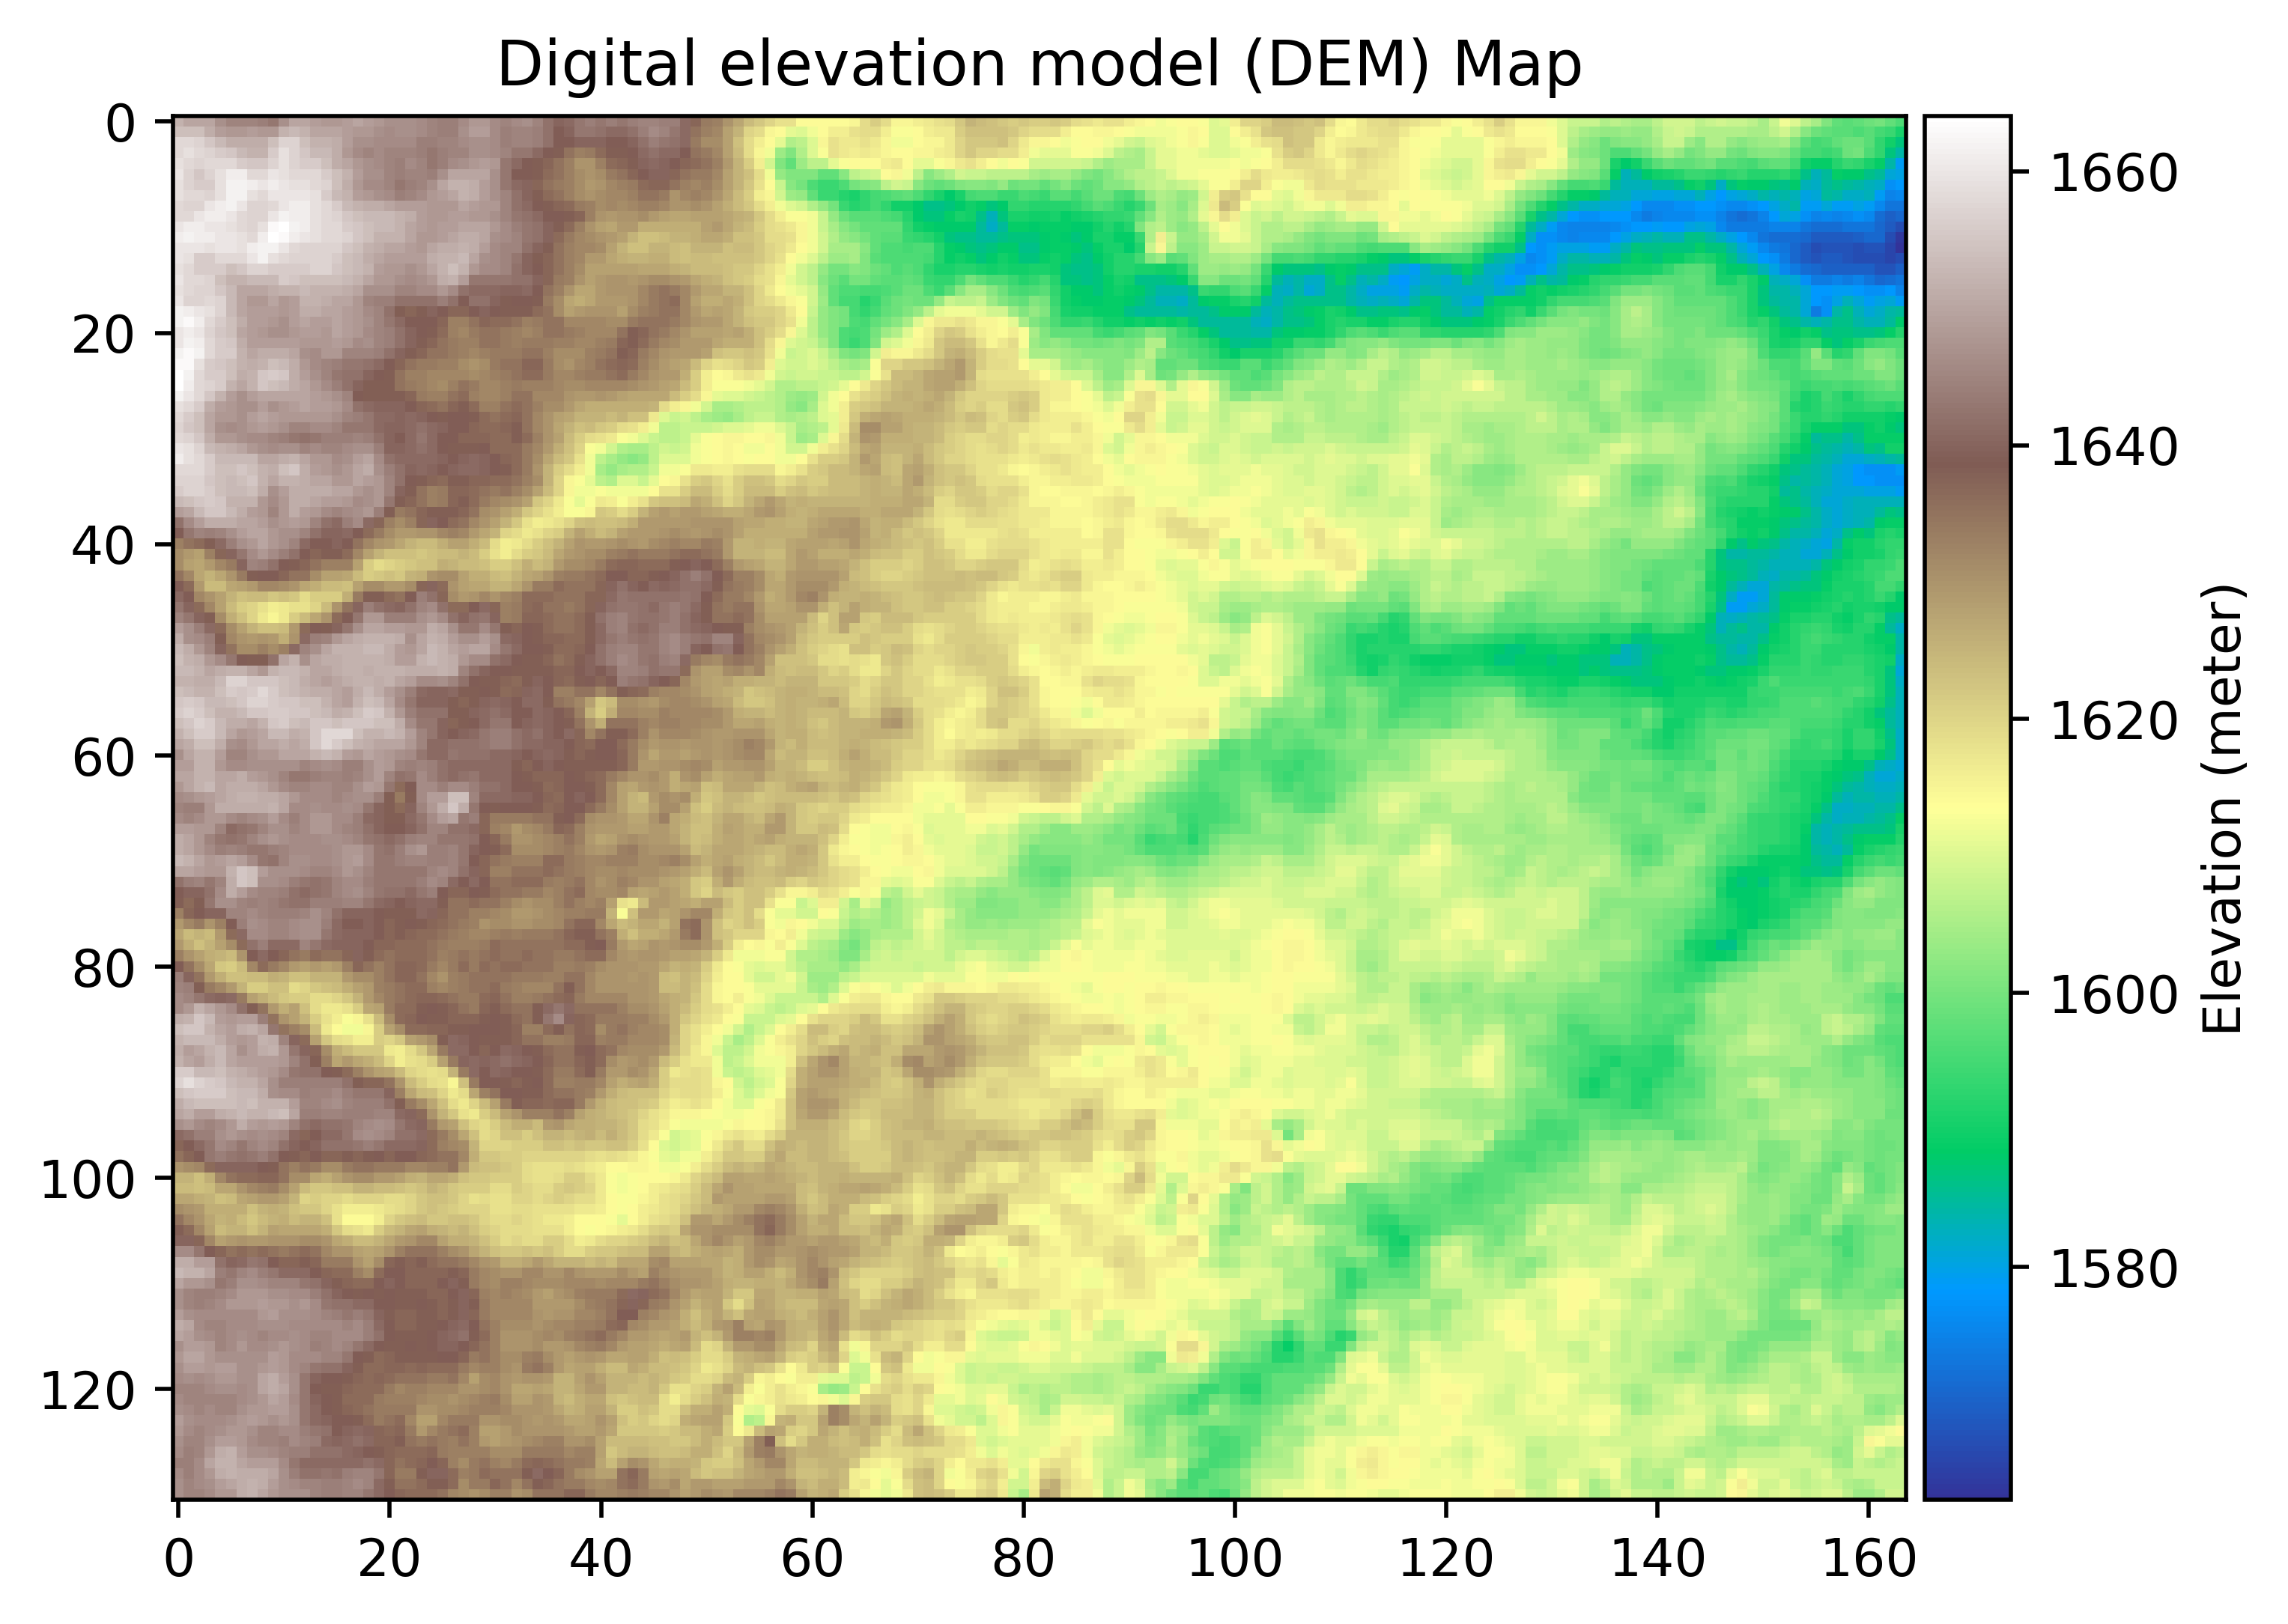

In [ ]:
dem = rasterio.open(out_dir+"/mosaic_clip.tif")
dem1 = dem.read(1)
dem1 = dem1.astype('f4') # f4 = float32
dem1[dem1==dem.nodata] = np.nan

plt.figure(dpi=500)
ax = plt.gca()
im = ax.imshow(dem1, cmap='terrain')
plt.title('Digital elevation model (DEM) Map')

divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=0.05)
plt.colorbar(im, cax=cax, label="Elevation (meter)")


# **Step 6**: Calculate slope from DEM

In [ ]:
with open(out_dir+'/boundary.json', 'w') as stream:
    json.dump(draw_control.last_draw, stream, indent=2)
gdf = gpd.read_file(out_dir+'/boundary.json')
gdf.to_file(out_dir+'/boundary.shp')

with fiona.open(out_dir+'/boundary.shp', "r") as shapefile:
    shapes = [feature["geometry"] for feature in shapefile]

In [ ]:
from rasterio.mask import mask
dem_path = out_dir+'/mosaic_clip.tif'
slope_path = out_dir+'/slope.tif'

dataset = rasterio.open(dem_path)
data = dataset.read()
data = np.squeeze(data)
sp_dem = rd.rdarray(data, no_data=dataset.nodata)
slope = rd.TerrainAttribute(sp_dem, attrib='slope_degrees')
#slope_fig = rd.rdShow(slope, axes=True, cmap='terrain', figsize=(9, 6))

dst_filename = out_dir+'/slope.tif'

with rasterio.open(out_dir+'/mosaic_clip.tif') as src:
    out_image, out_transform = mask(src, shapes, crop=True)
    out_meta = src.meta

with rasterio.open(dst_filename, 'w', driver='GTiff',
                   height=slope.shape[0],
                   width=slope.shape[1],
                   count=1,
                   dtype=slope.dtype,
                   crs=src.crs,
                   nodata=None, # change if data has nodata value
                   transform=src.transform) as dst:
  dst.write(slope, 1)

Warning! No geotransform defined. Choosing a standard one! (Top left cell's top let corner at <0,0>; cells are 1x1.)
Warning! No geotransform defined. Choosing a standard one! (Top left cell's top let corner at <0,0>; cells are 1x1.)


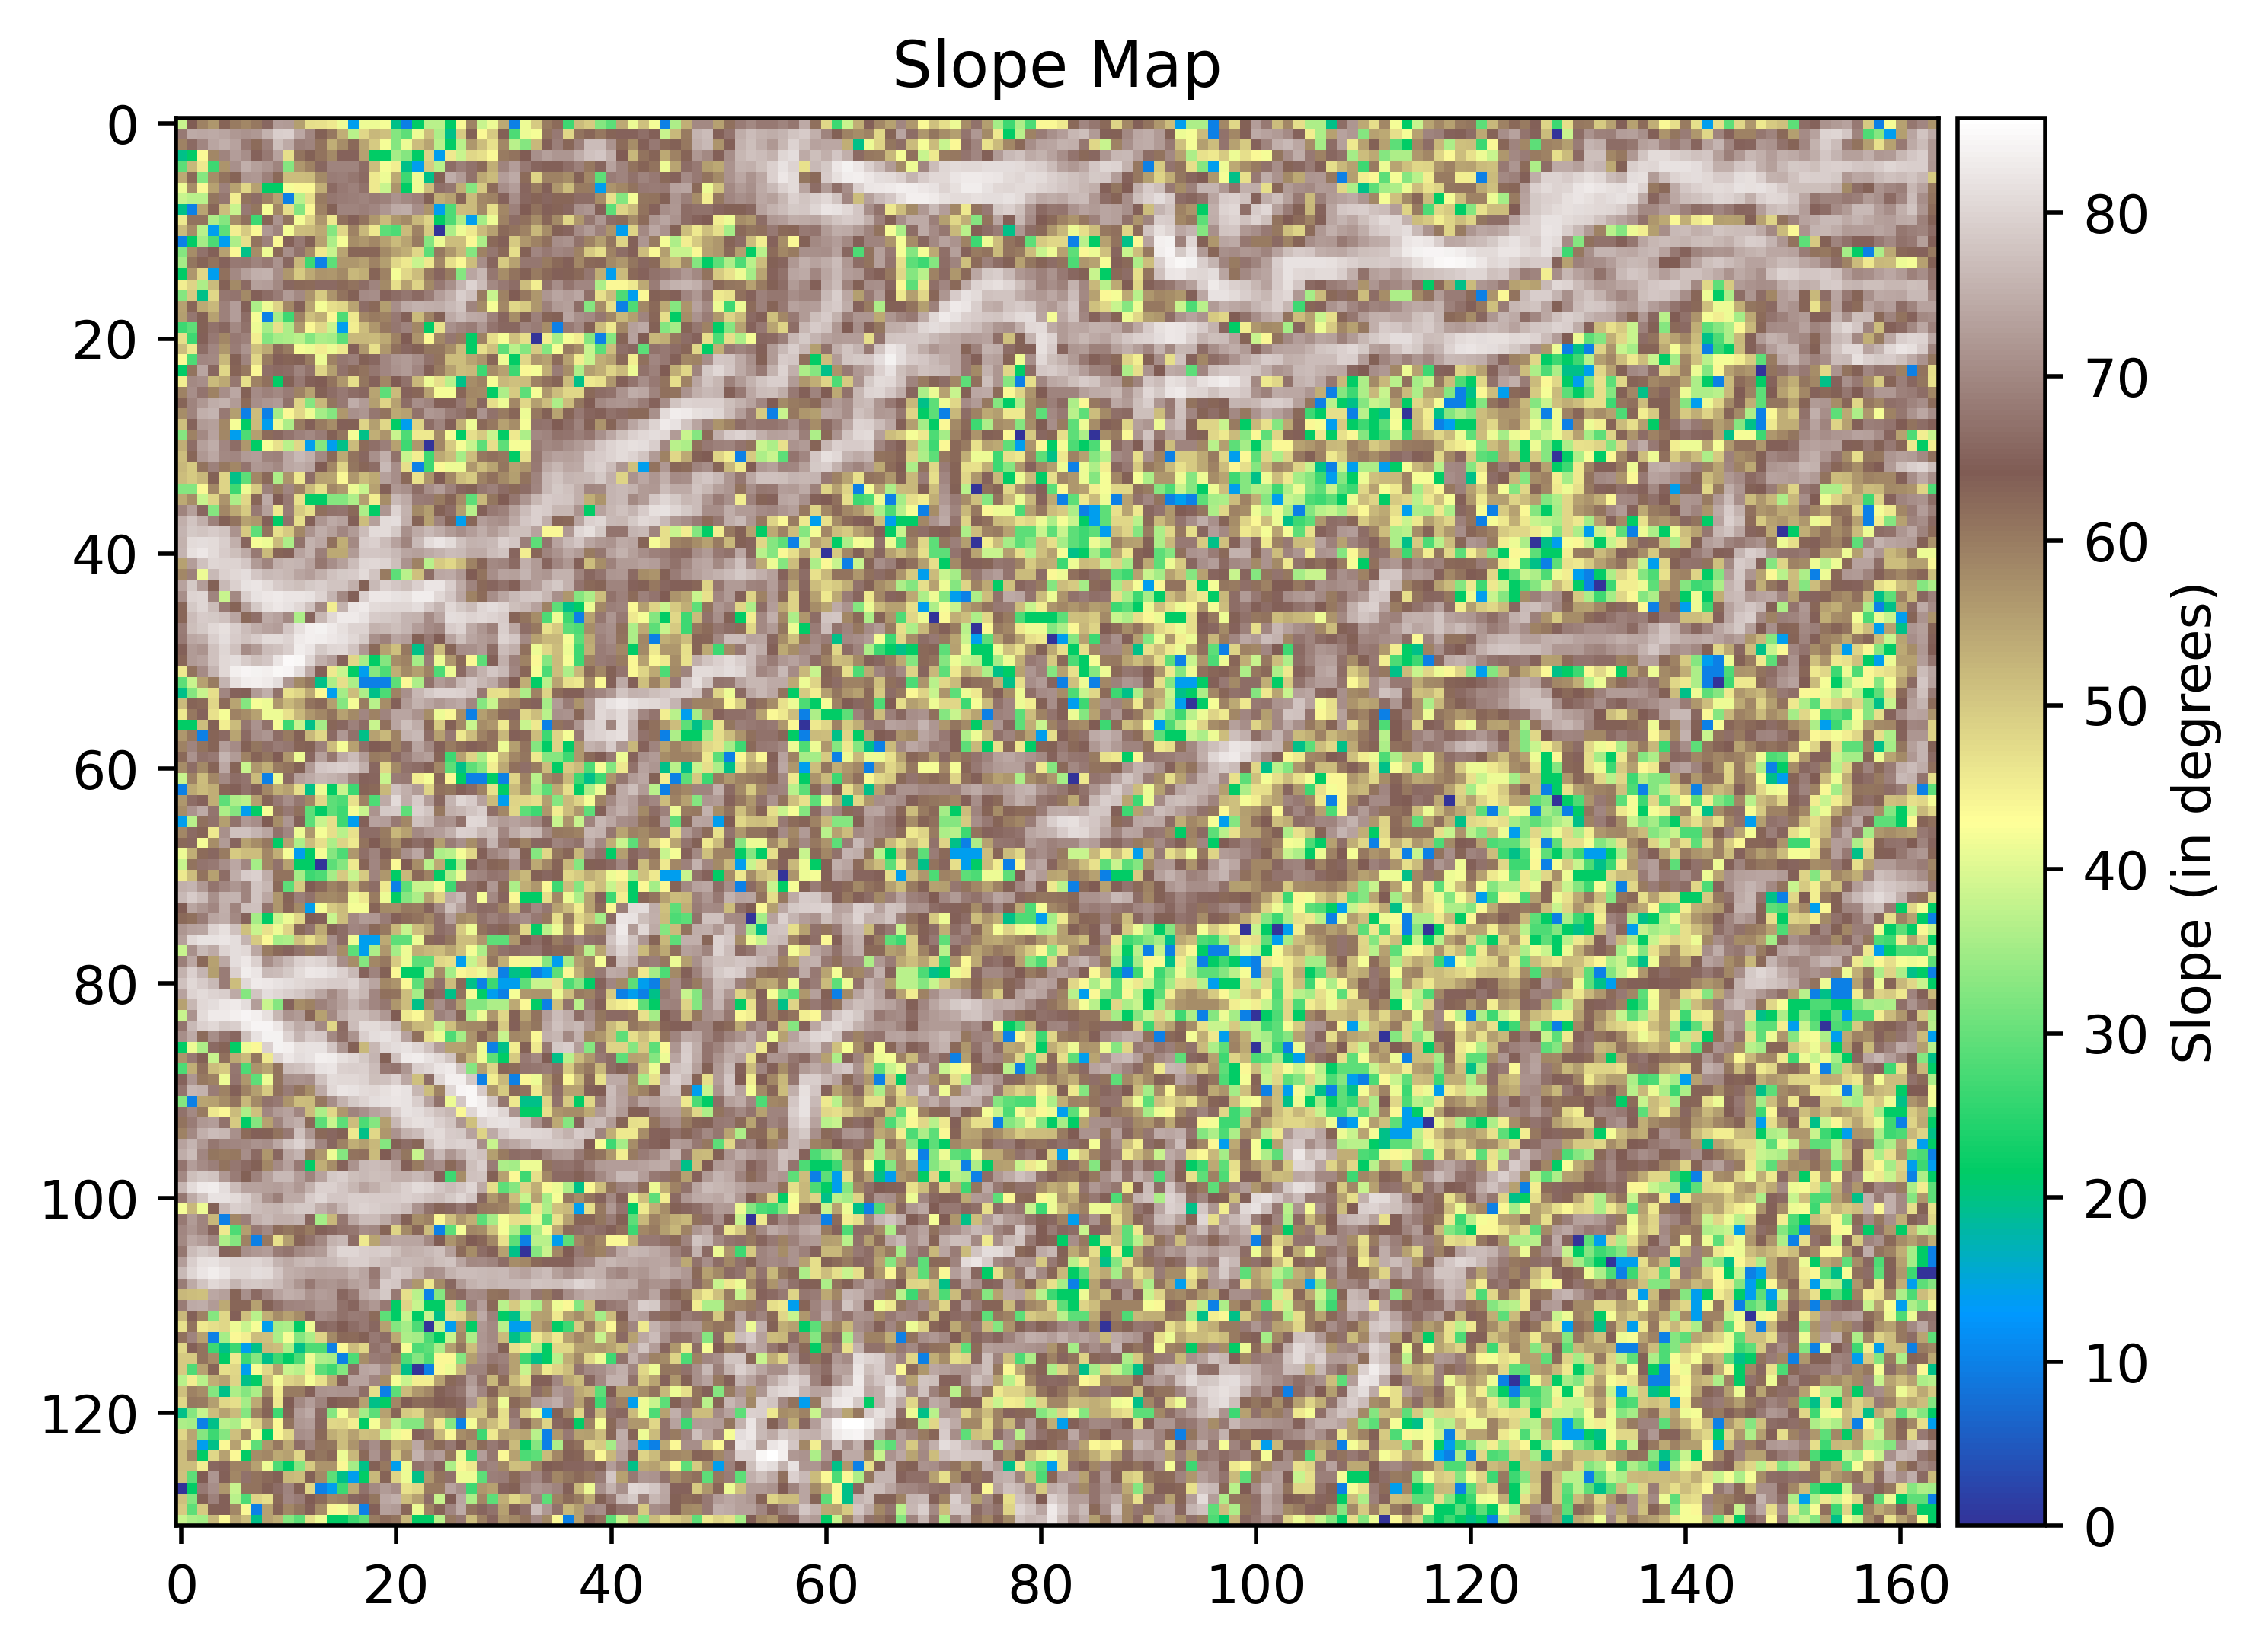

In [ ]:
slope1 = rasterio.open(out_dir+"/slope.tif")
slope_final = slope1.read(1)
slope_final = slope_final.astype('f4') # f4 = float32
slope_final[slope_final==-9999] = np.nan

plt.figure(dpi=500)
ax = plt.gca()
im = ax.imshow(slope_final, cmap='terrain')
plt.title('Slope Map')

divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=0.05)
plt.colorbar(im, cax=cax, label="Slope (in degrees)")

# **Step 7**: Generate flow accumulation

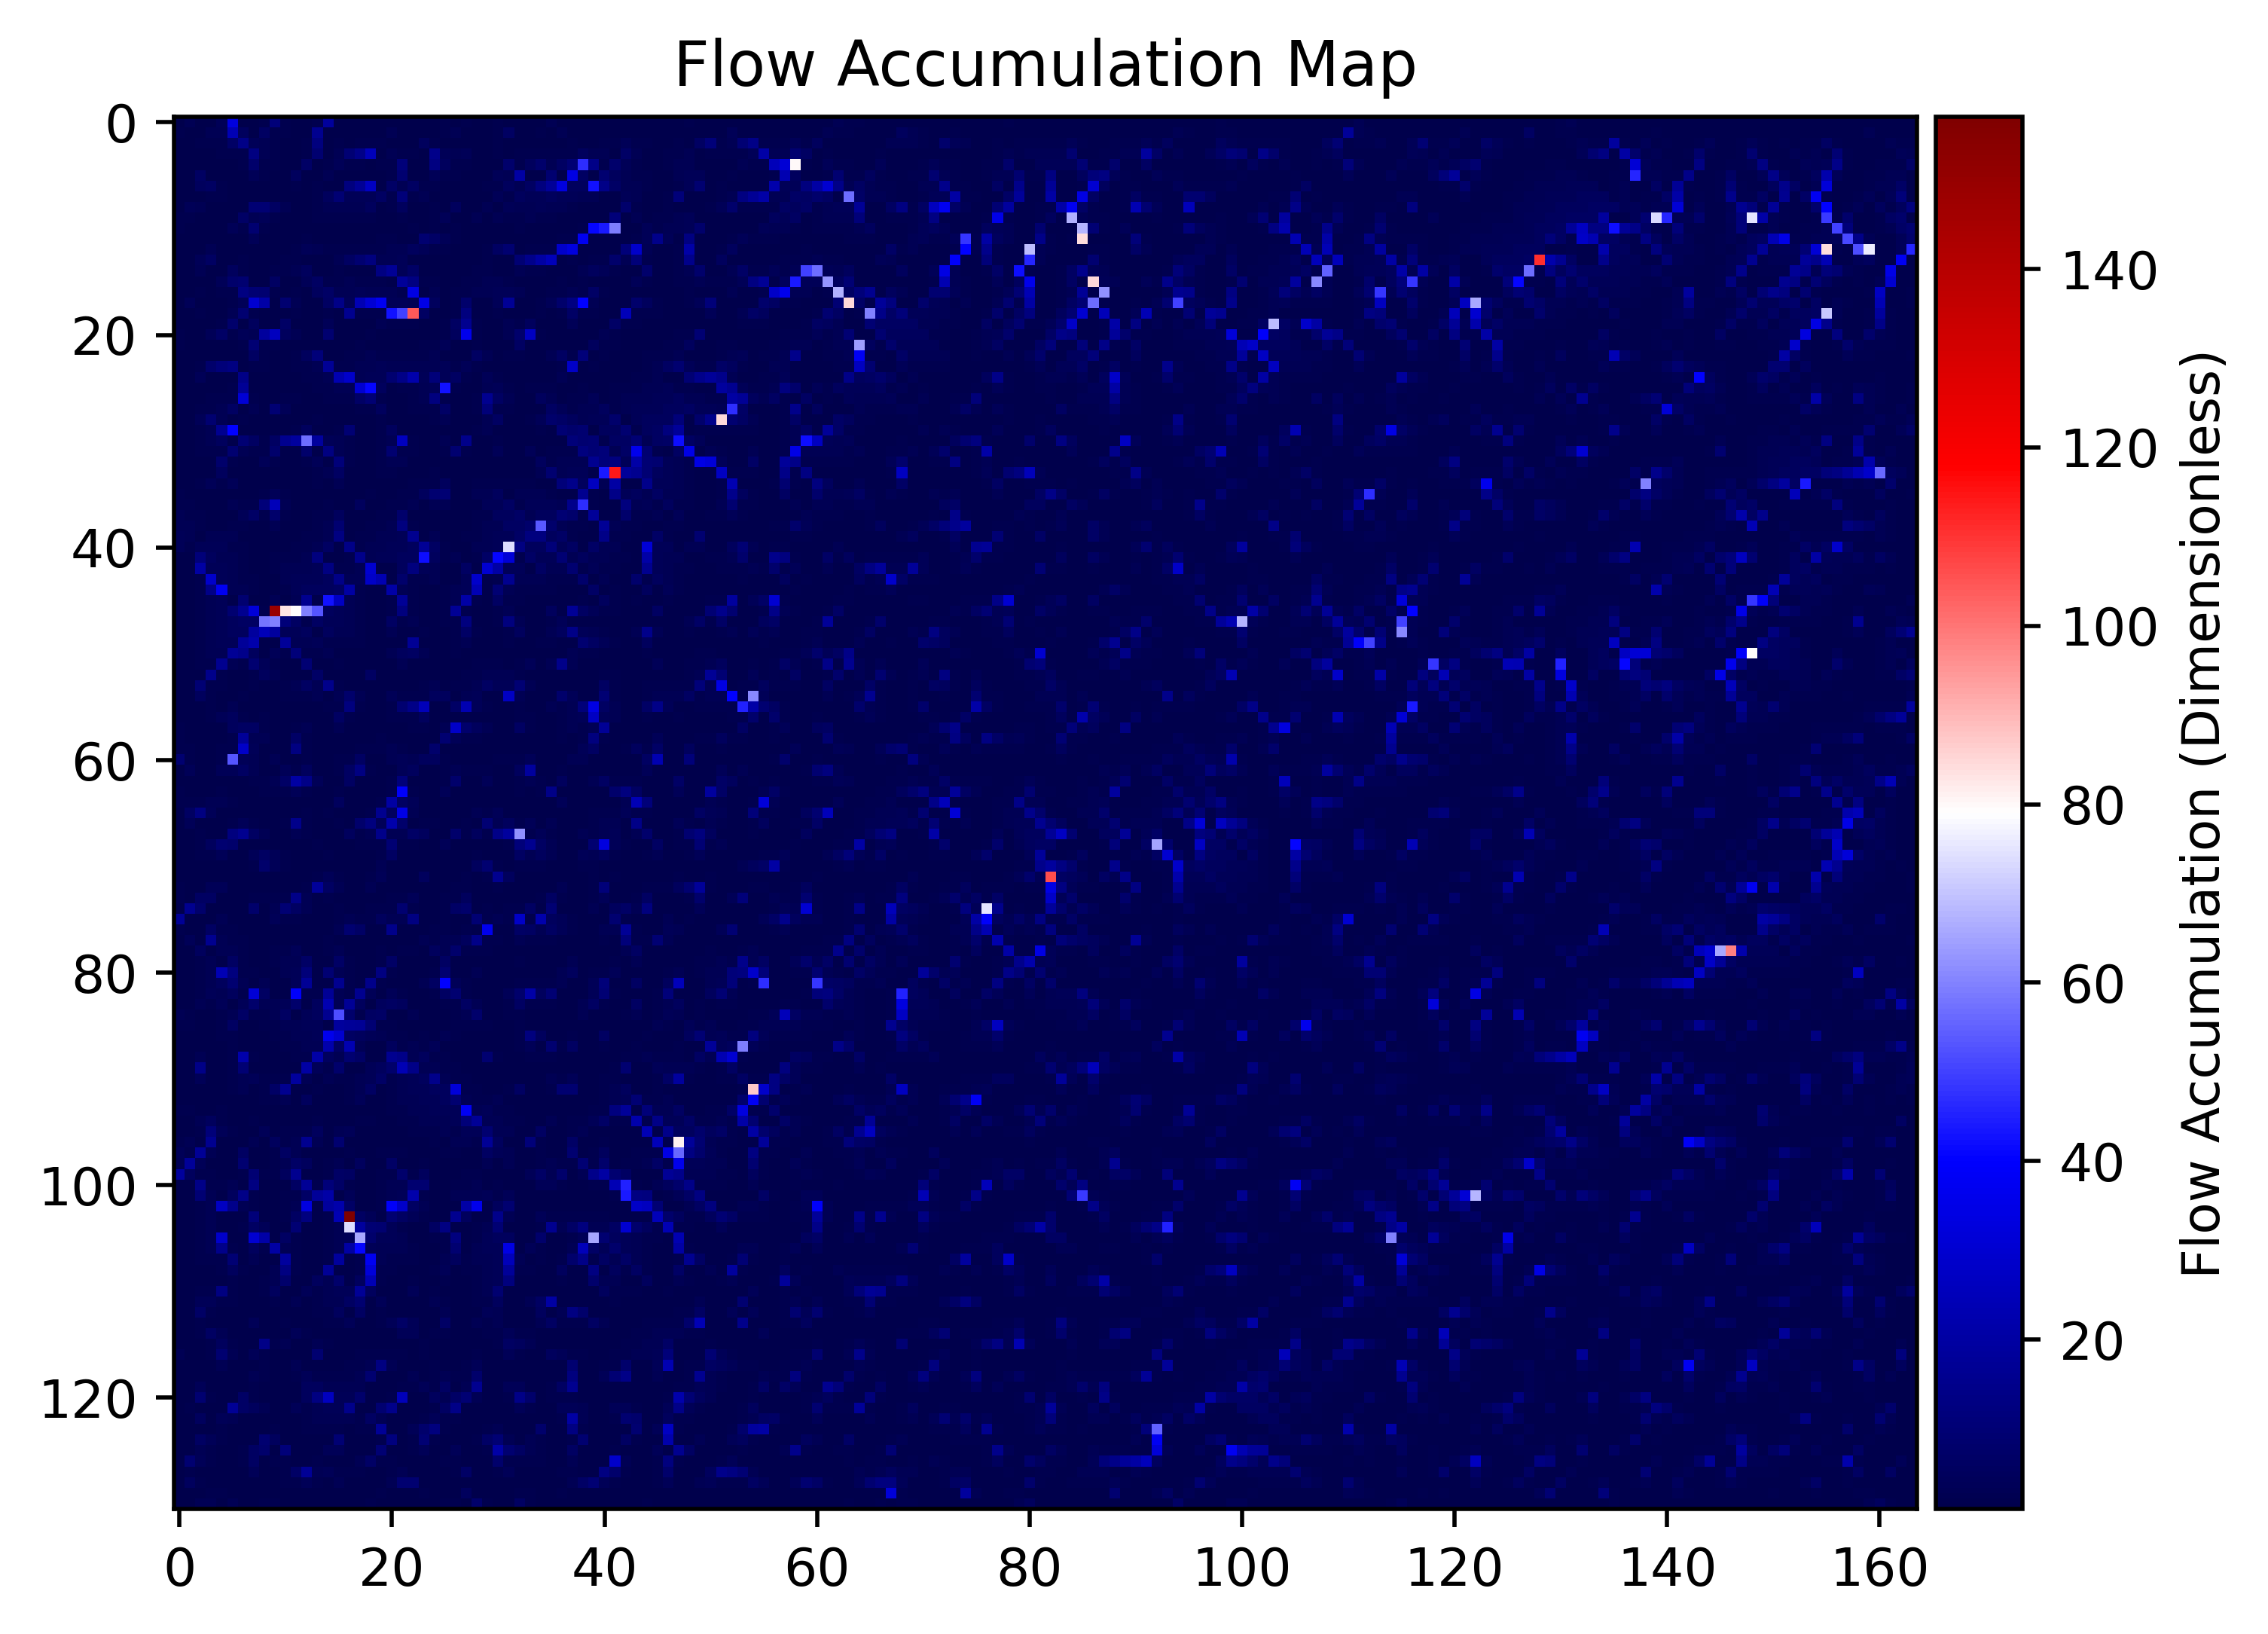

In [ ]:
dem = rd.LoadGDAL(dem_path)
rd.FillDepressions(dem, epsilon=True, in_place=True)
accum_d8 = rd.FlowAccumulation(dem, method='D8')
#accum_d8 = rd.FlowAccumulation(dem, method='Dinf')
#d8_fig = rd.rdShow(accum_d8, figsize=(8,5.5), axes=True, cmap='jet')
rd.SaveGDAL(out_dir+'/accum_d8.tif', accum_d8)

accum = rasterio.open(out_dir+"/accum_d8.tif")
accum_final = accum.read(1)
accum_final = accum_final.astype('f4') # f4 = float32
accum_final[accum_final==accum.nodata] = np.nan

plt.figure(dpi=500)
ax = plt.gca()
im = ax.imshow(accum_final, cmap='seismic')
plt.title('Flow Accumulation Map')

divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=0.05)
plt.colorbar(im, cax=cax, label="Flow Accumulation (Dimensionless)")

# **Step 8**: Calculate and map topographic wetness index (TWI)

In [ ]:
slope_mask = np.empty(slope.shape,dtype=rasterio.float32)

for i in range(slope.shape[0]):
    for j in range(slope.shape[1]):
        if slope[i,j] > 0 :
            slope_mask[i,j] = True
        else:
            slope_mask[i,j] = False

rasterslope = np.empty(slope.shape,dtype=rasterio.float32)
rasterslope = np.where(slope_mask,slope*1.570796/90, -999 )

slopetan = rasterslope.copy()
slopetan = np.where(slope_mask,np.tan(slopetan), -999 )

In [ ]:
src = rxr.open_rasterio(dem_path, masked=True)
xres = src.rio.resolution()[0]

acc_mask = np.empty(accum_d8.shape,dtype=rasterio.float32)

for i in range(accum_d8.shape[0]):
    for j in range(accum_d8.shape[1]):
        if accum_d8[i,j] > 0 :
            acc_mask[i,j] = True
        else:
            acc_mask[i,j] = False

acc2 = accum_d8.copy()
acc2 = np.where(acc_mask,(accum_d8+1)*xres, -999 )

In [ ]:
TWI = np.empty(slope.shape,dtype=rasterio.float32)

for i in range(TWI.shape[0]):
    for j in range(TWI.shape[1]):
        value = acc2[i,j]/slopetan[i,j]
        if value <= 0:
            TWI[i,j] == f'{-999:.6f}'
        else:
            TWI[i,j] = f'{math.log(value):.6f}'

In [ ]:
dst_filename = project_result+'/TWI_results.tif'

with rasterio.open(out_dir+'/mosaic_clip.tif') as src:
    out_image, out_transform = rasterio.mask.mask(src, shapes, crop=True)
    out_meta = src.meta

with rasterio.open(dst_filename, 'w', driver='GTiff',
                   height=TWI.shape[0],
                   width=TWI.shape[1],
                   count=1,
                   dtype=TWI.dtype,
                   crs=src.crs,
                   nodata=None, # change if data has nodata value
                   transform=src.transform) as dst:
  dst.write(TWI, 1)

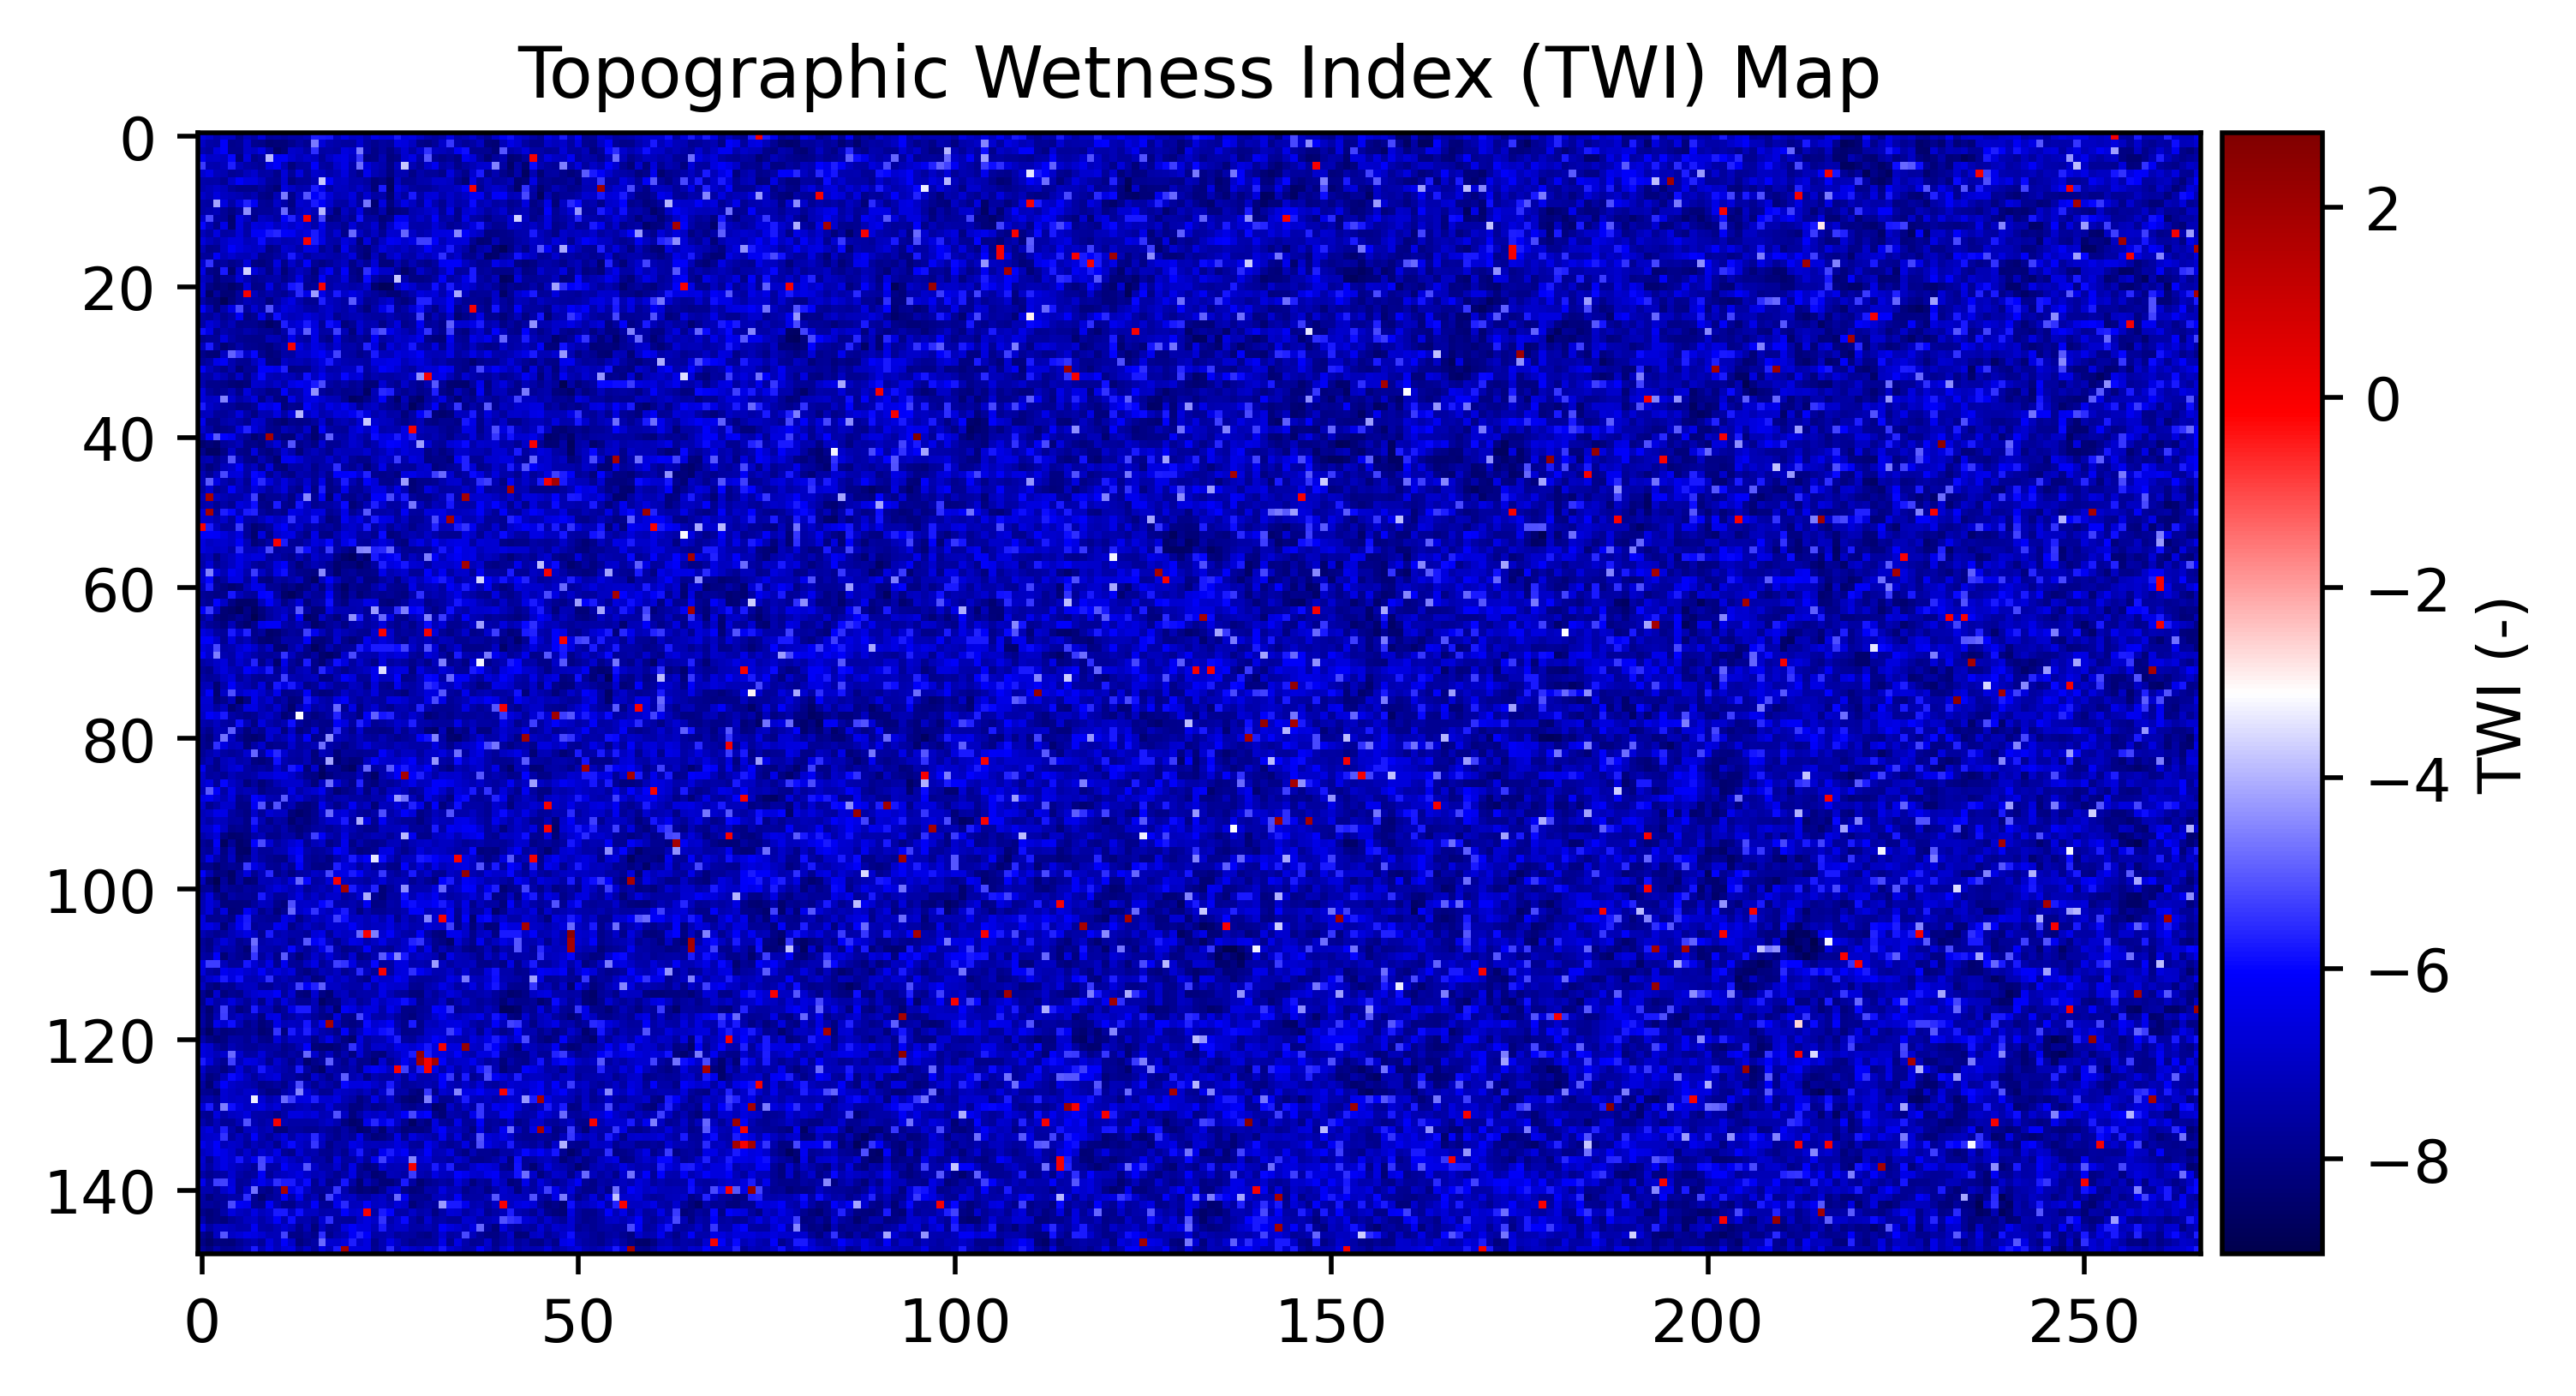

In [ ]:
TWI_map = rasterio.open(project_result+'/TWI_results.tif')
TWI_map1 = TWI_map.read(1)
TWI_map1 = TWI_map1.astype('f4') # f4 = float32
TWI_map1[TWI_map1==TWI_map.nodata] = np.nan

plt.figure(dpi=500)
ax = plt.gca()
im = ax.imshow(TWI_map1, cmap='seismic')
plt.title('Topographic Wetness Index (TWI) Map')

divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=0.05)
plt.colorbar(im, cax=cax, label="TWI (-)")

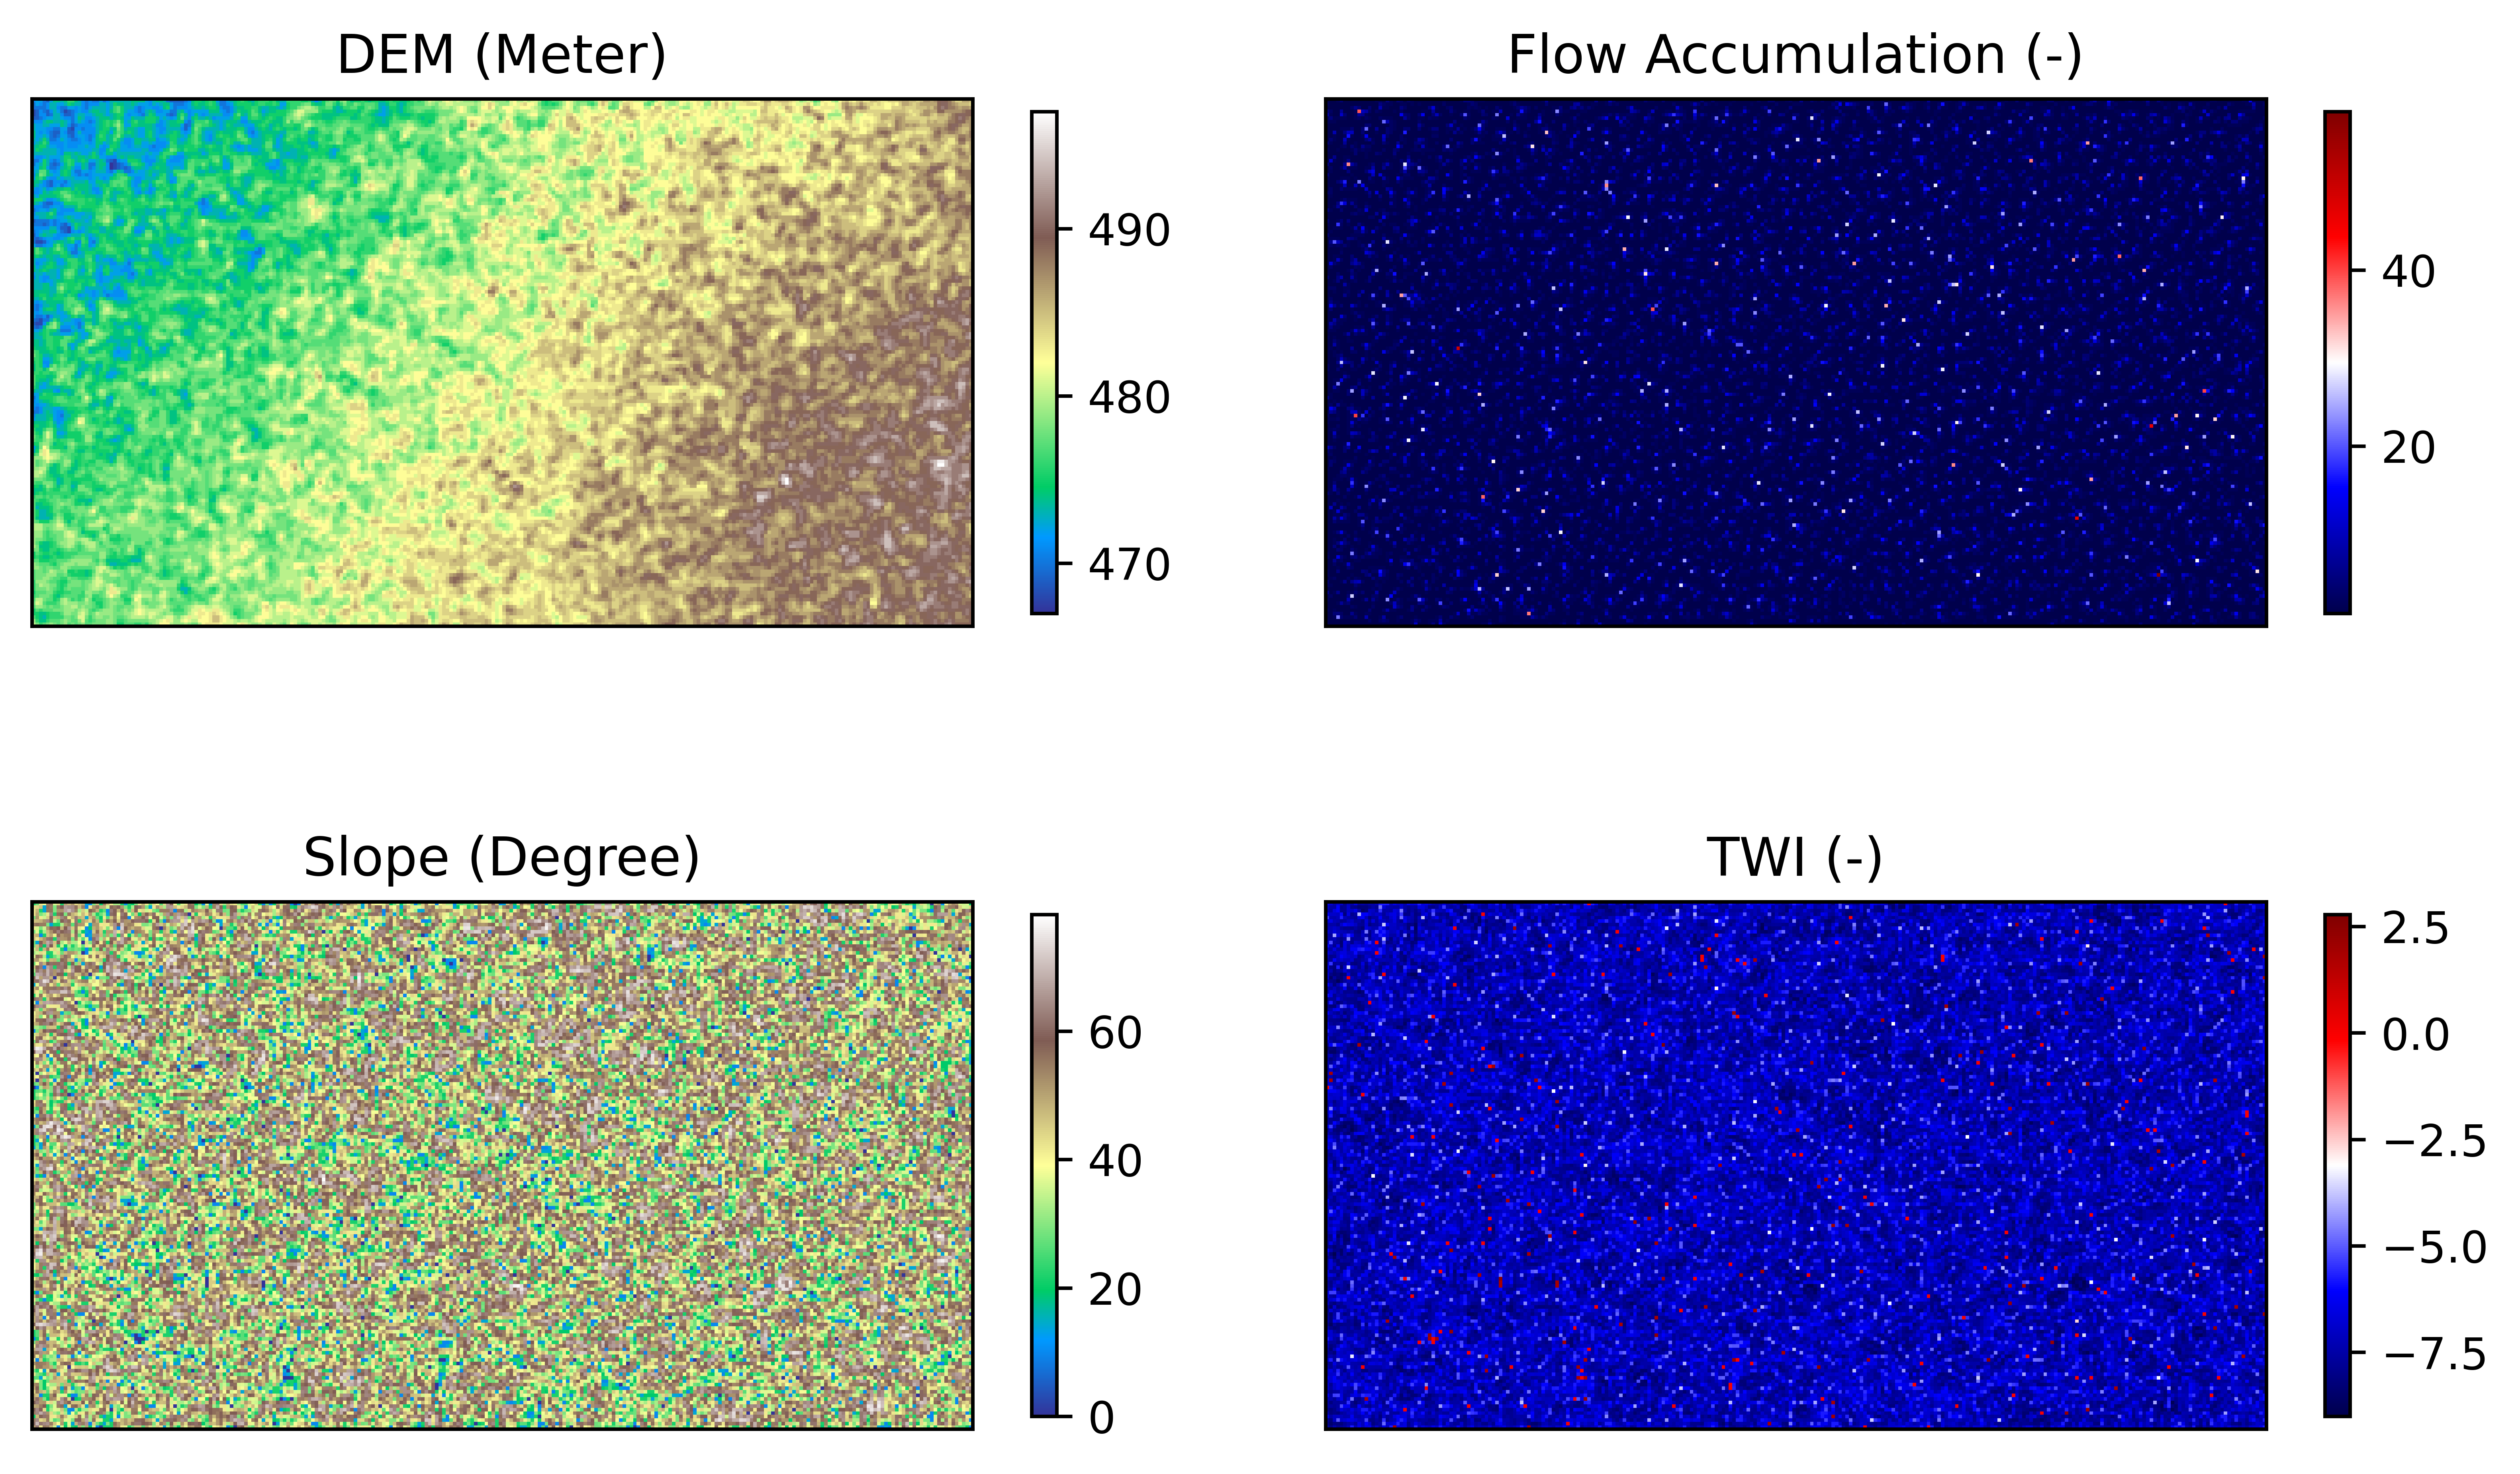

In [ ]:
fig = plt.figure(figsize=(10,6),dpi=800)
gs = fig.add_gridspec(2,2,hspace=0.2 ,wspace=0.1)
(ax1, ax2), (ax3, ax4) = gs.subplots(sharex='col', sharey='row')

pcm1 = ax1.imshow(dem, cmap='terrain')
ax1.set_title("DEM (Meter)")
fig.colorbar(pcm1, ax=ax1,shrink=0.75)
ax1.set_yticklabels([])
ax1.set_xticklabels([])
ax1.set_xticks([])
ax1.set_yticks([])

pcm2 = ax2.imshow(accum_final, cmap='seismic')
ax2.set_title("Flow Accumulation (-)")
fig.colorbar(pcm2, ax=ax2,shrink=0.75)
ax2.set_yticklabels([])
ax2.set_xticklabels([])
ax2.set_xticks([])
ax2.set_yticks([])

pcm3 = ax3.imshow(slope_final, cmap='terrain')
ax3.set_title("Slope (Degree)")
fig.colorbar(pcm3, ax=ax3,shrink=0.75)
ax3.set_yticklabels([])
ax3.set_xticklabels([])
ax3.set_xticks([])
ax3.set_yticks([])

pcm4 =ax4.imshow(TWI_map1, cmap='seismic')
ax4.set_title("TWI (-)")
fig.colorbar(pcm4, ax=ax4,shrink=0.75)
ax4.set_yticklabels([])
ax4.set_xticklabels([])
ax4.set_xticks([])
ax4.set_yticks([])

plt.savefig(project_result+'/Figures.pdf')

# **Step 9**: Download building footprint data for your location of interest

 Building footprints are useful for a range of important applications, from population estimation, urban planning and humanitarian response, to addressing environmental and climate challenges. This tool allows users to access two building footprint datasets.

**(1) The US building footprint:** available only for the United States.

**(2) Open Building Dataset:** derived from high-resolution 50 cm satellite imagery which covers **Africa, Latin America, Caribbean, South Asia, and Southeast Asia**.

 **Please select the correct option below corresponding to your study area.**

See the following references for more details.

---
**Reference:**

1. **[US building footprint]** Heris, M.P., Foks, N.L., Bagstad, K.J. et al. A rasterized building footprint dataset for the United States. Sci Data 7, 207 (2020). https://doi.org/10.1038/s41597-020-0542-3 **[Use this if your study area is in the US]**

2. **[Open Building Datasets]** W. Sirko, S. Kashubin, M. Ritter, A. Annkah, Y.S.E. Bouchareb, Y. Dauphin, D. Keysers, M. Neumann, M. Cisse, J.A. Quinn. Continental-scale building detection from high resolution satellite imagery. arXiv:2107.12283, 2021. **[Use this if your study area is NOT in the US]**

In [ ]:
Country = int(input("""Please use following options to select  your location(e.g.: 1, or 2):
1. USA;
2. Other than USA;
"""))

if Country==1:
  Urldata = pd.DataFrame(Urldata_lst,columns =["State","County","download_url"])

  if os.path.isfile(out_dir+'/SVI2020_US.zip'):
    pass
  else:
    SVI_url = 'https://svi.cdc.gov/Documents/Data/2020/db/states/SVI2020_US.zip'
    wget.download(SVI_url, out=out_dir)

  with ZipFile(out_dir+'/SVI2020_US.zip', 'r') as zipObj:
    zipObj.extractall(out_dir)

  US = read_dataframe(out_dir+'/SVI2020_US_tract.shp')
  US.COUNTY = US.COUNTY.str.replace(' ', '')
  US.COUNTY = US.COUNTY.str.replace('.', '')
  US = US[["ST","STATE","ST_ABBR","COUNTY","LOCATION","RPL_THEMES","geometry"]]
  US["COUNTY2"] = US["COUNTY"]

  AOI = gpd.read_file(out_dir+'/boundary.shp')
  AOI_pro = AOI.to_crs(US.crs)
  clipped = gpd.clip(US, AOI_pro)
  clipped = clipped.dissolve(by=['STATE','COUNTY2'],)
  clipped.reset_index(inplace=True)

  buildTemp = out_dir+'/temp'
  os.makedirs(buildTemp, exist_ok=True)

  os.chdir(out_dir)
  new_df = Urldata.merge(clipped,left_on=["State","County"],right_on=["STATE","COUNTY2"])[["State","County","download_url"]]
  for i in range(len(new_df)):
    url = new_df['download_url'][i]
    filename = new_df['State'][i] + "_" + new_df['County'][i]
    if os.path.isfile(out_dir+'/%s.zip'%filename):
      shutil.unpack_archive(out_dir+'/%s.zip'%filename, out_dir)
    else:
      wget.download(url)
      shutil.unpack_archive(out_dir+'/%s.zip'%filename, out_dir)

    building = read_dataframe(out_dir+"/%s/%s_building.shp" % (filename, filename))
    AOI_pro = AOI.to_crs(building.crs)
    Bclipped = gpd.clip(building, AOI_pro)
    if Bclipped.empty:
      pass
    else:
      Bclipped = Bclipped[(Bclipped.geometry.type == 'MultiPolygon')|(Bclipped.geometry.type == 'Polygon')]
      Bclipped.to_file(buildTemp+"/%s_building.shp" % (filename))

else:
  buildTemp = out_dir+'/temp'
  os.makedirs(buildTemp, exist_ok=True)
  os.chdir(out_dir)

  your_own_wkt_polygon = f'POLYGON(({x1} {y1},{x2} {y1},{x2} {y2},{x1} {y2},{x1} {y1}))'
  data_type= 'polygons'

  BUILDING_DOWNLOAD_PATH = ('gs://open-buildings-data/v3/'
                            f'{data_type}_s2_level_6_gzip_no_header')



  filename, region_df = get_filename_and_region_dataframe(your_own_wkt_polygon)
  for f in glob.glob('/content/project/temp/open_buildings_*'):
    os.remove(f)

  with gzip.open(f'/content/project/temp/{filename}', 'wt') as merged:
    if data_type == "polygons":
      merged.write(','.join([
          'latitude', 'longitude', 'area_in_meters', 'confidence', 'geometry',
          'full_plus_code'
      ]) + '\n')
    else:
      merged.write(','.join([
          'latitude', 'longitude', 'area_in_meters', 'confidence',
          'full_plus_code'
      ]) + '\n')
  download_s2_token_fn = functools.partial(download_s2_token, region_df=region_df)
  s2_tokens = get_bounding_box_s2_covering_tokens(region_df.iloc[0].geometry)

  with open(f'/content/project/temp/{filename}', 'ab') as merged:
    with multiprocessing.Pool(4) as e:
      for fname in tqdm.notebook.tqdm(
          e.imap_unordered(download_s2_token_fn, s2_tokens),
          total=len(s2_tokens)):
        if fname:
          with open(fname, 'rb') as tmp_f:
            shutil.copyfileobj(tmp_f, merged)
          os.unlink(fname)

  with gzip.open('/content/project/temp/open_buildings_v3_polygons_your_own_wkt_polygon.csv.gz') as f:
    features_train = pd.read_csv(f)

  from shapely import wkt

  features_train['geometry'] = features_train['geometry'].apply(wkt.loads)
  gdf = gpd.GeoDataFrame(features_train, crs='epsg:4326')
  gdf.to_file('/content/project/temp/building.shp')


Preparing your_own_wkt_polygon.


/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


  0%|          | 0/1 [00:00<?, ?it/s]

<ipython-input-21-5a9d4d4125cb>:107: UserWarning: Column names longer than 10 characters will be truncated when saved to ESRI Shapefile.
  gdf.to_file('/content/project/temp/building.shp')


# **Step 10**: Identify the building footprint in your location of interest

In [ ]:
lst_shp = [file for file in glob.glob(buildTemp+'/*.shp')]
if len(lst_shp) >= 1:
  files_to_merge = []
  for file in lst_shp:
    src = gpd.GeoDataFrame.from_file(file)
    files_to_merge.append(src)
  results=gpd.GeoDataFrame(pd.concat(files_to_merge,ignore_index=True))
  results.to_file(project_result+"/buildfp.shp")
else:
  print("There is no building dataset within your location of interest.")

# **Step 11**: Map building footprint and topographic wetness index in your location of interest

<ipython-input-23-3a2eb22fc1df>:32: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  bounds =[[float(bounds.miny),float(bounds.minx)],
<ipython-input-23-3a2eb22fc1df>:33: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  [float(bounds.maxy),float(bounds.maxx)]]))



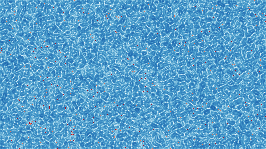

In [ ]:
with rasterio.open(project_result+'/TWI_results.tif') as src:
    boundary = src.bounds
    img = src.read()
    nodata = src.nodata

clat = (boundary.bottom + boundary.top)/2
clon = (boundary.left + boundary.right)/2
vmin = np.floor(np.nanmin(img))
vmax = np.ceil(np.nanmax(img))
colormap = cm.linear.RdBu_11.scale(vmin, vmax)
colormap.colors.reverse()

AOI = gpd.read_file(out_dir+'/boundary.shp')
bounds = AOI.to_crs(epsg='4326').bounds
coords = bounds.iloc[0]
lat = (coords['miny'] + coords['maxy']) / 2
lon = (coords['minx'] + coords['maxx']) / 2

bf = gpd.read_file(project_result+"/buildfp.shp")
city_gjson = bf.to_crs(epsg='4326').to_json()

m = folium.Map([lat, lon], zoom_start=10)
style_city = {'fillColor':'#FF0000','color':'#FF0000'}
city = folium.features.GeoJson(city_gjson, name='Building footprint', style_function = lambda x:style_city)

m.add_child(folium.raster_layers.ImageOverlay(img[0],
                                              opacity=1,
                                              interactive=True,
                                              colormap= lambda value: mapvalue2color(value, colormap),
                                              overlay=True,
                                              name = "Topographic Wetness Index",
                                              bounds =[[float(bounds.miny),float(bounds.minx)],
                                               [float(bounds.maxy),float(bounds.maxx)]]))
m.add_child(city)
m.add_child(folium.LatLngPopup())
m.add_child(folium.LayerControl())
colormap.caption = 'TWI'
m.add_child(colormap)
m.save(project_result+"/TWI_Building_map.html")
m

# **Step 12**: Save your results and download to your computer

In [ ]:
base_name = out_dir+'/results'
format = 'zip'
root_dir = out_dir
base_dir = './results'
shutil.make_archive(base_name,format,root_dir,base_dir)

'/content/project/results.zip'

In [ ]:
files.download(out_dir+'/results.zip')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>